# Sciplex Dose

In [1]:
ood_seed = 2

In [2]:
num_ood = 1

In [3]:
obs_key = "condition"

In [4]:
import warnings
import os
import sys
import gc
import warnings

In [5]:
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import sklearn
import scipy.stats
from sklearn.dummy import DummyClassifier

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
from tardis._utils.functions import label_transfer
tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False


In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [7]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "cpa_GSM_new.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)

adata.X = adata.layers["counts"].copy()
del adata.layers
adata.obs.loc[adata.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata.obs["dose"].astype(float).unique()))}
adata.obs["dose_training"] = [d[float(i)] for i in adata.obs["dose"]]
gc.collect()

12

In [8]:
df = adata.obs.groupby(["condition", "dose"]).size()
df2 = adata.obs.groupby(["condition"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 30 and df2[i[0]] > 200 and float(i[1])>4]
df

condition  dose 
BMS        0.0         0
           0.1       654
           0.5       542
           1.0       344
           5.0       193
           10.0      153
           50.0       34
           100.0      19
Dex        0.0         0
           0.1       327
           0.5       372
           1.0       717
           5.0       694
           10.0      704
           50.0      864
           100.0     790
Nutlin     0.0         0
           0.1       419
           0.5       359
           1.0       567
           5.0       486
           10.0      657
           50.0      265
           100.0       7
SAHA       0.0         0
           0.1       561
           0.5       519
           1.0       543
           5.0       417
           10.0      426
           50.0      604
           100.0     419
Vehicle    0.0      2155
           0.1         0
           0.5         0
           1.0         0
           5.0         0
           10.0        0
           50.0        0
        

In [9]:
availables, len(availables)

([(('BMS', '5.0'), 193),
  (('BMS', '10.0'), 153),
  (('BMS', '50.0'), 34),
  (('Dex', '5.0'), 694),
  (('Dex', '10.0'), 704),
  (('Dex', '50.0'), 864),
  (('Dex', '100.0'), 790),
  (('Nutlin', '5.0'), 486),
  (('Nutlin', '10.0'), 657),
  (('Nutlin', '50.0'), 265),
  (('SAHA', '5.0'), 417),
  (('SAHA', '10.0'), 426),
  (('SAHA', '50.0'), 604),
  (('SAHA', '100.0'), 419)],
 14)

In [10]:
def adata_ood_creator(adata, seed, size):
    df = adata.obs.groupby(["condition", "dose"]).size()
    df2 = adata.obs.groupby(["condition"]).size()
    # availables = [(i, df[i]) for i in df.index if df[i] > 200 and df2[i[0]] > 100 and float(i[1])>4]
    # rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["condition"] == choice[0][0]) & (adata.obs["dose"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

adata, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)

(('BMS', '50.0'), 34)

Removed datapoint: 34


In [11]:
adata

AnnData object with n_obs × n_vars = 14777 × 4999
    obs: 'sample', 'size_factor', 'n.umi', 'hash_umis', 'pval', 'qval', 'top_to_second_best_ratio', 'top_oligo', 'drug', 'dose', 'vehicle', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'product_dose', 'louvain', 'dose_val', 'cell_type', 'drug_dose_name', 'cov_drug_dose_name', 'condition', 'control', 'split', 'dose_training'
    var: 'id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dose_colors', 'drug_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'product_dose_colors', 'rank_genes_groups_cov', 'umap', 'vehicle_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [12]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    f"sciplex_cat_ood-seed_expression-{ood_seed}_size-{num_ood}_obs-{obs_key}"
)

In [13]:
# vae = tardis.MyModel.load(dir_path, adata=adata)

In [14]:
model_level_metrics = [
    dict(
        metric_identifier = "metric_mi|dose_training",
        training_set = ["train", "validation"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 256,
            latent_subset=None,
            reduce=np.mean
        )
    ),
    dict(
        metric_identifier = "metric_mi|condition",
        training_set = ["train", "validation"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 256,
            latent_subset=None,
            reduce=np.mean
        )
    )
]

In [15]:
warmup_epoch_range = [6, 48]
dtc_w1 = 100
dtc_w2 = 10

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = None,
        seed = "forward",
    )
)

disentenglement_targets_configurations=[
    dict(
        obs_key = obs_key,
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    ),
]

In [16]:
n_epochs_kl_warmup = 600

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=(24 + 8 * len(disentenglement_targets_configurations)),
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.25,
    deeply_inject_disentengled_latents = True,
    include_auxillary_loss = True,
    beta_kl_weight = 0.5,
    encode_covariates=True
)

train_params = dict(
    max_epochs=600,
    train_size=0.8,
    batch_size=128,
    check_val_every_n_epoch=10,
    limit_train_batches=1.0, 
    limit_val_batches=1.0,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=False,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=1e-4,
        weight_decay=1e-4,
        optimizer="AdamW",
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    )
)

dataset_params = dict(
    layer=None, 
    labels_key=None,
    batch_key=None,
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations,
    model_level_metrics=model_level_metrics,
    model_level_metrics_helper_covariates=['condition', 'dose_training']
)

tardis.MyModel.setup_anndata(adata, **dataset_params)
dataset_params["adata_path"] = adata_file_path
dataset_params["adata"] = os.path.split(adata_file_path)[1]

# tardis.MyModel.setup_wandb(
#     wandb_configurations=tardis.config.wandb,
#     hyperparams=dict(
#         model_params=model_params,
#         train_params=train_params,
#         dataset_params=dataset_params,
#     )
# )

vae = tardis.MyModel(
    adata,
    **model_params
)
vae.train(**train_params)

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
  rank_zero_warn(


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
  rank_zero_warn(
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1/600:   0%|          | 0/600 [00:00<?, ?it/s]

/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `condition` for `training` set. Number of elements in each group: 1549,3541,2252,2774,1706
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `condition` for `validation` set. Number of elements in each group: 356,927,508,715,449
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 1/600:   0%|          | 1/600 [00:05<58:30,  5.86s/it]

Epoch 1/600:   0%|          | 1/600 [00:05<58:30,  5.86s/it, v_num=1, total_loss_train=2.65e+3, kl_local_train=36.4]

Epoch 2/600:   0%|          | 1/600 [00:05<58:30,  5.86s/it, v_num=1, total_loss_train=2.65e+3, kl_local_train=36.4]

Epoch 2/600:   0%|          | 2/600 [00:11<56:02,  5.62s/it, v_num=1, total_loss_train=2.65e+3, kl_local_train=36.4]

Epoch 2/600:   0%|          | 2/600 [00:11<56:02,  5.62s/it, v_num=1, total_loss_train=2.23e+3, kl_local_train=62.5]

Epoch 3/600:   0%|          | 2/600 [00:11<56:02,  5.62s/it, v_num=1, total_loss_train=2.23e+3, kl_local_train=62.5]

Epoch 3/600:   0%|          | 3/600 [00:16<55:17,  5.56s/it, v_num=1, total_loss_train=2.23e+3, kl_local_train=62.5]

Epoch 3/600:   0%|          | 3/600 [00:16<55:17,  5.56s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=66.4]

Epoch 4/600:   0%|          | 3/600 [00:16<55:17,  5.56s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=66.4]

Epoch 4/600:   1%|          | 4/600 [00:22<54:39,  5.50s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=66.4]

Epoch 4/600:   1%|          | 4/600 [00:22<54:39,  5.50s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=62.9] 

Epoch 5/600:   1%|          | 4/600 [00:22<54:39,  5.50s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=62.9]

Epoch 5/600:   1%|          | 5/600 [00:27<55:29,  5.60s/it, v_num=1, total_loss_train=2.2e+3, kl_local_train=62.9]

Epoch 5/600:   1%|          | 5/600 [00:27<55:29,  5.60s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=54] 

Epoch 6/600:   1%|          | 5/600 [00:28<55:29,  5.60s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=54]

Epoch 6/600:   1%|          | 6/600 [00:33<54:46,  5.53s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=54]

Epoch 6/600:   1%|          | 6/600 [00:33<54:46,  5.53s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=59.4, metric_mi|dose_training_train=0.0504, metric_mi|condition_train=0.117]

Epoch 7/600:   1%|          | 6/600 [00:33<54:46,  5.53s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=59.4, metric_mi|dose_training_train=0.0504, metric_mi|condition_train=0.117]

Epoch 7/600:   1%|          | 7/600 [00:38<52:55,  5.35s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=59.4, metric_mi|dose_training_train=0.0504, metric_mi|condition_train=0.117]

Epoch 7/600:   1%|          | 7/600 [00:38<52:55,  5.35s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=59.9, metric_mi|dose_training_train=0.0504, metric_mi|condition_train=0.117]

Epoch 8/600:   1%|          | 7/600 [00:38<52:55,  5.35s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=59.9, metric_mi|dose_training_train=0.0504, metric_mi|condition_train=0.117]

Epoch 8/600:   1%|▏         | 8/600 [00:43<51:49,  5.25s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=59.9, metric_mi|dose_training_train=0.0504, metric_mi|condition_train=0.117]

Epoch 8/600:   1%|▏         | 8/600 [00:43<51:49,  5.25s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.0504, metric_mi|condition_train=0.117]

Epoch 9/600:   1%|▏         | 8/600 [00:43<51:49,  5.25s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.0504, metric_mi|condition_train=0.117]

Epoch 9/600:   2%|▏         | 9/600 [00:48<51:08,  5.19s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.0504, metric_mi|condition_train=0.117]

Epoch 9/600:   2%|▏         | 9/600 [00:48<51:08,  5.19s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=54.9, metric_mi|dose_training_train=0.0504, metric_mi|condition_train=0.117]

Epoch 10/600:   2%|▏         | 9/600 [00:48<51:08,  5.19s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=54.9, metric_mi|dose_training_train=0.0504, metric_mi|condition_train=0.117]

Epoch 10/600:   2%|▏         | 10/600 [00:53<51:29,  5.24s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=54.9, metric_mi|dose_training_train=0.0504, metric_mi|condition_train=0.117]

Epoch 10/600:   2%|▏         | 10/600 [00:53<51:29,  5.24s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0504, metric_mi|condition_train=0.117]

Epoch 11/600:   2%|▏         | 10/600 [00:54<51:29,  5.24s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0504, metric_mi|condition_train=0.117]

Epoch 11/600:   2%|▏         | 11/600 [00:59<52:04,  5.30s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0504, metric_mi|condition_train=0.117]

Epoch 11/600:   2%|▏         | 11/600 [00:59<52:04,  5.30s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0718, metric_mi|condition_train=0.237]

Epoch 12/600:   2%|▏         | 11/600 [00:59<52:04,  5.30s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0718, metric_mi|condition_train=0.237]

Epoch 12/600:   2%|▏         | 12/600 [01:04<51:05,  5.21s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0718, metric_mi|condition_train=0.237]

Epoch 12/600:   2%|▏         | 12/600 [01:04<51:05,  5.21s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0718, metric_mi|condition_train=0.237]

Epoch 13/600:   2%|▏         | 12/600 [01:04<51:05,  5.21s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0718, metric_mi|condition_train=0.237]

Epoch 13/600:   2%|▏         | 13/600 [01:09<50:22,  5.15s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0718, metric_mi|condition_train=0.237]

Epoch 13/600:   2%|▏         | 13/600 [01:09<50:22,  5.15s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.0718, metric_mi|condition_train=0.237]

Epoch 14/600:   2%|▏         | 13/600 [01:09<50:22,  5.15s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.0718, metric_mi|condition_train=0.237]

Epoch 14/600:   2%|▏         | 14/600 [01:14<49:48,  5.10s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.0718, metric_mi|condition_train=0.237]

Epoch 14/600:   2%|▏         | 14/600 [01:14<49:48,  5.10s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=65.3, metric_mi|dose_training_train=0.0718, metric_mi|condition_train=0.237]

Epoch 15/600:   2%|▏         | 14/600 [01:14<49:48,  5.10s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=65.3, metric_mi|dose_training_train=0.0718, metric_mi|condition_train=0.237]

Epoch 15/600:   2%|▎         | 15/600 [01:19<50:14,  5.15s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=65.3, metric_mi|dose_training_train=0.0718, metric_mi|condition_train=0.237]

Epoch 15/600:   2%|▎         | 15/600 [01:19<50:14,  5.15s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=71.6, metric_mi|dose_training_train=0.0718, metric_mi|condition_train=0.237]

Epoch 16/600:   2%|▎         | 15/600 [01:19<50:14,  5.15s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=71.6, metric_mi|dose_training_train=0.0718, metric_mi|condition_train=0.237]

Epoch 16/600:   3%|▎         | 16/600 [01:24<50:59,  5.24s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=71.6, metric_mi|dose_training_train=0.0718, metric_mi|condition_train=0.237]

Epoch 16/600:   3%|▎         | 16/600 [01:24<50:59,  5.24s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=75.1, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.172]

Epoch 17/600:   3%|▎         | 16/600 [01:24<50:59,  5.24s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=75.1, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.172]

Epoch 17/600:   3%|▎         | 17/600 [01:29<50:08,  5.16s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=75.1, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.172]

Epoch 17/600:   3%|▎         | 17/600 [01:29<50:08,  5.16s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=78.5, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.172]

Epoch 18/600:   3%|▎         | 17/600 [01:29<50:08,  5.16s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=78.5, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.172]

Epoch 18/600:   3%|▎         | 18/600 [01:34<49:28,  5.10s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=78.5, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.172]

Epoch 18/600:   3%|▎         | 18/600 [01:34<49:28,  5.10s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=82.4, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.172]

Epoch 19/600:   3%|▎         | 18/600 [01:34<49:28,  5.10s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=82.4, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.172]

Epoch 19/600:   3%|▎         | 19/600 [01:39<48:59,  5.06s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=82.4, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.172]

Epoch 19/600:   3%|▎         | 19/600 [01:39<48:59,  5.06s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.172]

Epoch 20/600:   3%|▎         | 19/600 [01:39<48:59,  5.06s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.172]

Epoch 20/600:   3%|▎         | 20/600 [01:45<49:40,  5.14s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.172]

Epoch 20/600:   3%|▎         | 20/600 [01:45<49:40,  5.14s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.8, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.172]

Epoch 21/600:   3%|▎         | 20/600 [01:45<49:40,  5.14s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.8, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.172]

Epoch 21/600:   4%|▎         | 21/600 [01:50<50:25,  5.23s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=86.8, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.172]

Epoch 21/600:   4%|▎         | 21/600 [01:50<50:25,  5.23s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.189]  

Epoch 22/600:   4%|▎         | 21/600 [01:50<50:25,  5.23s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.189]

Epoch 22/600:   4%|▎         | 22/600 [01:55<49:37,  5.15s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=95, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.189]

Epoch 22/600:   4%|▎         | 22/600 [01:55<49:37,  5.15s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=92.3, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.189]

Epoch 23/600:   4%|▎         | 22/600 [01:55<49:37,  5.15s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=92.3, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.189]

Epoch 23/600:   4%|▍         | 23/600 [02:00<48:59,  5.09s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=92.3, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.189]

Epoch 23/600:   4%|▍         | 23/600 [02:00<48:59,  5.09s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.4, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.189]

Epoch 24/600:   4%|▍         | 23/600 [02:00<48:59,  5.09s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.4, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.189]

Epoch 24/600:   4%|▍         | 24/600 [02:05<48:32,  5.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.4, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.189]

Epoch 24/600:   4%|▍         | 24/600 [02:05<48:32,  5.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.6, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.189]

Epoch 25/600:   4%|▍         | 24/600 [02:05<48:32,  5.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.6, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.189]

Epoch 25/600:   4%|▍         | 25/600 [02:10<49:00,  5.11s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.6, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.189]

Epoch 25/600:   4%|▍         | 25/600 [02:10<49:00,  5.11s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.3, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.189]

Epoch 26/600:   4%|▍         | 25/600 [02:11<49:00,  5.11s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.3, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.189]

Epoch 26/600:   4%|▍         | 26/600 [02:16<49:52,  5.21s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.3, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.189]

Epoch 26/600:   4%|▍         | 26/600 [02:16<49:52,  5.21s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=89.7, metric_mi|dose_training_train=0.0851, metric_mi|condition_train=0.211]

Epoch 27/600:   4%|▍         | 26/600 [02:16<49:52,  5.21s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=89.7, metric_mi|dose_training_train=0.0851, metric_mi|condition_train=0.211]

Epoch 27/600:   4%|▍         | 27/600 [02:21<49:07,  5.14s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=89.7, metric_mi|dose_training_train=0.0851, metric_mi|condition_train=0.211]

Epoch 27/600:   4%|▍         | 27/600 [02:21<49:07,  5.14s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.8, metric_mi|dose_training_train=0.0851, metric_mi|condition_train=0.211]

Epoch 28/600:   4%|▍         | 27/600 [02:21<49:07,  5.14s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.8, metric_mi|dose_training_train=0.0851, metric_mi|condition_train=0.211]

Epoch 28/600:   5%|▍         | 28/600 [02:26<48:32,  5.09s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.8, metric_mi|dose_training_train=0.0851, metric_mi|condition_train=0.211]

Epoch 28/600:   5%|▍         | 28/600 [02:26<48:32,  5.09s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.9, metric_mi|dose_training_train=0.0851, metric_mi|condition_train=0.211]

Epoch 29/600:   5%|▍         | 28/600 [02:26<48:32,  5.09s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.9, metric_mi|dose_training_train=0.0851, metric_mi|condition_train=0.211]

Epoch 29/600:   5%|▍         | 29/600 [02:31<48:05,  5.05s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.9, metric_mi|dose_training_train=0.0851, metric_mi|condition_train=0.211]

Epoch 29/600:   5%|▍         | 29/600 [02:31<48:05,  5.05s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.8, metric_mi|dose_training_train=0.0851, metric_mi|condition_train=0.211]

Epoch 30/600:   5%|▍         | 29/600 [02:31<48:05,  5.05s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.8, metric_mi|dose_training_train=0.0851, metric_mi|condition_train=0.211]

Epoch 30/600:   5%|▌         | 30/600 [02:36<48:35,  5.11s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.8, metric_mi|dose_training_train=0.0851, metric_mi|condition_train=0.211]

Epoch 30/600:   5%|▌         | 30/600 [02:36<48:35,  5.11s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=93.7, metric_mi|dose_training_train=0.0851, metric_mi|condition_train=0.211]

Epoch 31/600:   5%|▌         | 30/600 [02:36<48:35,  5.11s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=93.7, metric_mi|dose_training_train=0.0851, metric_mi|condition_train=0.211]

Epoch 31/600:   5%|▌         | 31/600 [02:41<49:23,  5.21s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=93.7, metric_mi|dose_training_train=0.0851, metric_mi|condition_train=0.211]

Epoch 31/600:   5%|▌         | 31/600 [02:41<49:23,  5.21s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.0903, metric_mi|condition_train=0.225]

Epoch 32/600:   5%|▌         | 31/600 [02:41<49:23,  5.21s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.0903, metric_mi|condition_train=0.225]

Epoch 32/600:   5%|▌         | 32/600 [02:46<48:37,  5.14s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.0903, metric_mi|condition_train=0.225]

Epoch 32/600:   5%|▌         | 32/600 [02:46<48:37,  5.14s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=92.8, metric_mi|dose_training_train=0.0903, metric_mi|condition_train=0.225]

Epoch 33/600:   5%|▌         | 32/600 [02:46<48:37,  5.14s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=92.8, metric_mi|dose_training_train=0.0903, metric_mi|condition_train=0.225]

Epoch 33/600:   6%|▌         | 33/600 [02:51<48:07,  5.09s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=92.8, metric_mi|dose_training_train=0.0903, metric_mi|condition_train=0.225]

Epoch 33/600:   6%|▌         | 33/600 [02:51<48:07,  5.09s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.5, metric_mi|dose_training_train=0.0903, metric_mi|condition_train=0.225]

Epoch 34/600:   6%|▌         | 33/600 [02:51<48:07,  5.09s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.5, metric_mi|dose_training_train=0.0903, metric_mi|condition_train=0.225]

Epoch 34/600:   6%|▌         | 34/600 [02:56<47:43,  5.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.5, metric_mi|dose_training_train=0.0903, metric_mi|condition_train=0.225]

Epoch 34/600:   6%|▌         | 34/600 [02:56<47:43,  5.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.1, metric_mi|dose_training_train=0.0903, metric_mi|condition_train=0.225]

Epoch 35/600:   6%|▌         | 34/600 [02:56<47:43,  5.06s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.1, metric_mi|dose_training_train=0.0903, metric_mi|condition_train=0.225]

Epoch 35/600:   6%|▌         | 35/600 [03:02<48:27,  5.15s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.1, metric_mi|dose_training_train=0.0903, metric_mi|condition_train=0.225]

Epoch 35/600:   6%|▌         | 35/600 [03:02<48:27,  5.15s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=92.4, metric_mi|dose_training_train=0.0903, metric_mi|condition_train=0.225]

Epoch 36/600:   6%|▌         | 35/600 [03:02<48:27,  5.15s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=92.4, metric_mi|dose_training_train=0.0903, metric_mi|condition_train=0.225]

Epoch 36/600:   6%|▌         | 36/600 [03:07<49:47,  5.30s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=92.4, metric_mi|dose_training_train=0.0903, metric_mi|condition_train=0.225]

Epoch 36/600:   6%|▌         | 36/600 [03:07<49:47,  5.30s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.6, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.234]

Epoch 37/600:   6%|▌         | 36/600 [03:07<49:47,  5.30s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.6, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.234]

Epoch 37/600:   6%|▌         | 37/600 [03:12<48:51,  5.21s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.6, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.234]

Epoch 37/600:   6%|▌         | 37/600 [03:12<48:51,  5.21s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.234]

Epoch 38/600:   6%|▌         | 37/600 [03:12<48:51,  5.21s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.234]

Epoch 38/600:   6%|▋         | 38/600 [03:17<48:09,  5.14s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.234]

Epoch 38/600:   6%|▋         | 38/600 [03:17<48:09,  5.14s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.7, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.234]

Epoch 39/600:   6%|▋         | 38/600 [03:17<48:09,  5.14s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.7, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.234]

Epoch 39/600:   6%|▋         | 39/600 [03:22<47:39,  5.10s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.7, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.234]

Epoch 39/600:   6%|▋         | 39/600 [03:22<47:39,  5.10s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.6, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.234]

Epoch 40/600:   6%|▋         | 39/600 [03:22<47:39,  5.10s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.6, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.234]

Epoch 40/600:   7%|▋         | 40/600 [03:28<48:16,  5.17s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.6, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.234]

Epoch 40/600:   7%|▋         | 40/600 [03:28<48:16,  5.17s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=92.4, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.234]

Epoch 41/600:   7%|▋         | 40/600 [03:28<48:16,  5.17s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=92.4, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.234]

Epoch 41/600:   7%|▋         | 41/600 [03:33<49:16,  5.29s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=92.4, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.234]

Epoch 41/600:   7%|▋         | 41/600 [03:33<49:16,  5.29s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90, metric_mi|dose_training_train=0.092, metric_mi|condition_train=0.231]   

Epoch 42/600:   7%|▋         | 41/600 [03:33<49:16,  5.29s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90, metric_mi|dose_training_train=0.092, metric_mi|condition_train=0.231]

Epoch 42/600:   7%|▋         | 42/600 [03:38<48:22,  5.20s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90, metric_mi|dose_training_train=0.092, metric_mi|condition_train=0.231]

Epoch 42/600:   7%|▋         | 42/600 [03:38<48:22,  5.20s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.3, metric_mi|dose_training_train=0.092, metric_mi|condition_train=0.231]

Epoch 43/600:   7%|▋         | 42/600 [03:38<48:22,  5.20s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.3, metric_mi|dose_training_train=0.092, metric_mi|condition_train=0.231]

Epoch 43/600:   7%|▋         | 43/600 [03:43<47:44,  5.14s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.3, metric_mi|dose_training_train=0.092, metric_mi|condition_train=0.231]

Epoch 43/600:   7%|▋         | 43/600 [03:43<47:44,  5.14s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=89.9, metric_mi|dose_training_train=0.092, metric_mi|condition_train=0.231]

Epoch 44/600:   7%|▋         | 43/600 [03:43<47:44,  5.14s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=89.9, metric_mi|dose_training_train=0.092, metric_mi|condition_train=0.231]

Epoch 44/600:   7%|▋         | 44/600 [03:48<47:16,  5.10s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=89.9, metric_mi|dose_training_train=0.092, metric_mi|condition_train=0.231]

Epoch 44/600:   7%|▋         | 44/600 [03:48<47:16,  5.10s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.7, metric_mi|dose_training_train=0.092, metric_mi|condition_train=0.231]

Epoch 45/600:   7%|▋         | 44/600 [03:48<47:16,  5.10s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.7, metric_mi|dose_training_train=0.092, metric_mi|condition_train=0.231]

Epoch 45/600:   8%|▊         | 45/600 [03:54<48:22,  5.23s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.7, metric_mi|dose_training_train=0.092, metric_mi|condition_train=0.231]

Epoch 45/600:   8%|▊         | 45/600 [03:54<48:22,  5.23s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91, metric_mi|dose_training_train=0.092, metric_mi|condition_train=0.231]  

Epoch 46/600:   8%|▊         | 45/600 [03:54<48:22,  5.23s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91, metric_mi|dose_training_train=0.092, metric_mi|condition_train=0.231]

Epoch 46/600:   8%|▊         | 46/600 [03:59<49:33,  5.37s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91, metric_mi|dose_training_train=0.092, metric_mi|condition_train=0.231]

Epoch 46/600:   8%|▊         | 46/600 [03:59<49:33,  5.37s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.0946, metric_mi|condition_train=0.237]

Epoch 47/600:   8%|▊         | 46/600 [03:59<49:33,  5.37s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.0946, metric_mi|condition_train=0.237]

Epoch 47/600:   8%|▊         | 47/600 [04:05<49:07,  5.33s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.0946, metric_mi|condition_train=0.237]

Epoch 47/600:   8%|▊         | 47/600 [04:05<49:07,  5.33s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.9, metric_mi|dose_training_train=0.0946, metric_mi|condition_train=0.237]

Epoch 48/600:   8%|▊         | 47/600 [04:05<49:07,  5.33s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.9, metric_mi|dose_training_train=0.0946, metric_mi|condition_train=0.237]

Epoch 48/600:   8%|▊         | 48/600 [04:10<48:46,  5.30s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.9, metric_mi|dose_training_train=0.0946, metric_mi|condition_train=0.237]

Epoch 48/600:   8%|▊         | 48/600 [04:10<48:46,  5.30s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.9, metric_mi|dose_training_train=0.0946, metric_mi|condition_train=0.237]

Epoch 49/600:   8%|▊         | 48/600 [04:10<48:46,  5.30s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.9, metric_mi|dose_training_train=0.0946, metric_mi|condition_train=0.237]

Epoch 49/600:   8%|▊         | 49/600 [04:15<48:29,  5.28s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.9, metric_mi|dose_training_train=0.0946, metric_mi|condition_train=0.237]

Epoch 49/600:   8%|▊         | 49/600 [04:15<48:29,  5.28s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.6, metric_mi|dose_training_train=0.0946, metric_mi|condition_train=0.237]

Epoch 50/600:   8%|▊         | 49/600 [04:15<48:29,  5.28s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.6, metric_mi|dose_training_train=0.0946, metric_mi|condition_train=0.237]

Epoch 50/600:   8%|▊         | 50/600 [04:21<49:22,  5.39s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=91.6, metric_mi|dose_training_train=0.0946, metric_mi|condition_train=0.237]

Epoch 50/600:   8%|▊         | 50/600 [04:21<49:22,  5.39s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.0946, metric_mi|condition_train=0.237]

Epoch 51/600:   8%|▊         | 50/600 [04:21<49:22,  5.39s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.0946, metric_mi|condition_train=0.237]

Epoch 51/600:   8%|▊         | 51/600 [04:26<50:05,  5.47s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.0946, metric_mi|condition_train=0.237]

Epoch 51/600:   8%|▊         | 51/600 [04:26<50:05,  5.47s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.0961, metric_mi|condition_train=0.241]

Epoch 52/600:   8%|▊         | 51/600 [04:26<50:05,  5.47s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.0961, metric_mi|condition_train=0.241]

Epoch 52/600:   9%|▊         | 52/600 [04:32<49:21,  5.40s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.0961, metric_mi|condition_train=0.241]

Epoch 52/600:   9%|▊         | 52/600 [04:32<49:21,  5.40s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.4, metric_mi|dose_training_train=0.0961, metric_mi|condition_train=0.241]

Epoch 53/600:   9%|▊         | 52/600 [04:32<49:21,  5.40s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.4, metric_mi|dose_training_train=0.0961, metric_mi|condition_train=0.241]

Epoch 53/600:   9%|▉         | 53/600 [04:37<48:59,  5.37s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90.4, metric_mi|dose_training_train=0.0961, metric_mi|condition_train=0.241]

Epoch 53/600:   9%|▉         | 53/600 [04:37<48:59,  5.37s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90, metric_mi|dose_training_train=0.0961, metric_mi|condition_train=0.241]  

Epoch 54/600:   9%|▉         | 53/600 [04:37<48:59,  5.37s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90, metric_mi|dose_training_train=0.0961, metric_mi|condition_train=0.241]

Epoch 54/600:   9%|▉         | 54/600 [04:42<48:40,  5.35s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=90, metric_mi|dose_training_train=0.0961, metric_mi|condition_train=0.241]

Epoch 54/600:   9%|▉         | 54/600 [04:42<48:40,  5.35s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=89.6, metric_mi|dose_training_train=0.0961, metric_mi|condition_train=0.241]

Epoch 55/600:   9%|▉         | 54/600 [04:42<48:40,  5.35s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=89.6, metric_mi|dose_training_train=0.0961, metric_mi|condition_train=0.241]

Epoch 55/600:   9%|▉         | 55/600 [04:48<48:56,  5.39s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=89.6, metric_mi|dose_training_train=0.0961, metric_mi|condition_train=0.241]

Epoch 55/600:   9%|▉         | 55/600 [04:48<48:56,  5.39s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.7, metric_mi|dose_training_train=0.0961, metric_mi|condition_train=0.241]

Epoch 56/600:   9%|▉         | 55/600 [04:48<48:56,  5.39s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.7, metric_mi|dose_training_train=0.0961, metric_mi|condition_train=0.241]

Epoch 56/600:   9%|▉         | 56/600 [04:53<49:06,  5.42s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=88.7, metric_mi|dose_training_train=0.0961, metric_mi|condition_train=0.241]

Epoch 56/600:   9%|▉         | 56/600 [04:53<49:06,  5.42s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.4, metric_mi|dose_training_train=0.0958, metric_mi|condition_train=0.241]

Epoch 57/600:   9%|▉         | 56/600 [04:53<49:06,  5.42s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.4, metric_mi|dose_training_train=0.0958, metric_mi|condition_train=0.241]

Epoch 57/600:  10%|▉         | 57/600 [04:58<47:55,  5.29s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.4, metric_mi|dose_training_train=0.0958, metric_mi|condition_train=0.241]

Epoch 57/600:  10%|▉         | 57/600 [04:58<47:55,  5.29s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.7, metric_mi|dose_training_train=0.0958, metric_mi|condition_train=0.241]

Epoch 58/600:  10%|▉         | 57/600 [04:58<47:55,  5.29s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.7, metric_mi|dose_training_train=0.0958, metric_mi|condition_train=0.241]

Epoch 58/600:  10%|▉         | 58/600 [05:03<47:00,  5.20s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.7, metric_mi|dose_training_train=0.0958, metric_mi|condition_train=0.241]

Epoch 58/600:  10%|▉         | 58/600 [05:03<47:00,  5.20s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.2, metric_mi|dose_training_train=0.0958, metric_mi|condition_train=0.241]

Epoch 59/600:  10%|▉         | 58/600 [05:03<47:00,  5.20s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.2, metric_mi|dose_training_train=0.0958, metric_mi|condition_train=0.241]

Epoch 59/600:  10%|▉         | 59/600 [05:08<46:22,  5.14s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=87.2, metric_mi|dose_training_train=0.0958, metric_mi|condition_train=0.241]

Epoch 59/600:  10%|▉         | 59/600 [05:08<46:22,  5.14s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.7, metric_mi|dose_training_train=0.0958, metric_mi|condition_train=0.241]

Epoch 60/600:  10%|▉         | 59/600 [05:08<46:22,  5.14s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.7, metric_mi|dose_training_train=0.0958, metric_mi|condition_train=0.241]

Epoch 60/600:  10%|█         | 60/600 [05:14<46:44,  5.19s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.7, metric_mi|dose_training_train=0.0958, metric_mi|condition_train=0.241]

Epoch 60/600:  10%|█         | 60/600 [05:14<46:44,  5.19s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.6, metric_mi|dose_training_train=0.0958, metric_mi|condition_train=0.241]

Epoch 61/600:  10%|█         | 60/600 [05:14<46:44,  5.19s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.6, metric_mi|dose_training_train=0.0958, metric_mi|condition_train=0.241]

Epoch 61/600:  10%|█         | 61/600 [05:19<47:19,  5.27s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.6, metric_mi|dose_training_train=0.0958, metric_mi|condition_train=0.241]

Epoch 61/600:  10%|█         | 61/600 [05:19<47:19,  5.27s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=85.4, metric_mi|dose_training_train=0.0956, metric_mi|condition_train=0.241]

Epoch 62/600:  10%|█         | 61/600 [05:19<47:19,  5.27s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=85.4, metric_mi|dose_training_train=0.0956, metric_mi|condition_train=0.241]

Epoch 62/600:  10%|█         | 62/600 [05:24<46:29,  5.19s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=85.4, metric_mi|dose_training_train=0.0956, metric_mi|condition_train=0.241]

Epoch 62/600:  10%|█         | 62/600 [05:24<46:29,  5.19s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=84.9, metric_mi|dose_training_train=0.0956, metric_mi|condition_train=0.241]

Epoch 63/600:  10%|█         | 62/600 [05:24<46:29,  5.19s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=84.9, metric_mi|dose_training_train=0.0956, metric_mi|condition_train=0.241]

Epoch 63/600:  10%|█         | 63/600 [05:29<45:53,  5.13s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=84.9, metric_mi|dose_training_train=0.0956, metric_mi|condition_train=0.241]

Epoch 63/600:  10%|█         | 63/600 [05:29<45:53,  5.13s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=84.8, metric_mi|dose_training_train=0.0956, metric_mi|condition_train=0.241]

Epoch 64/600:  10%|█         | 63/600 [05:29<45:53,  5.13s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=84.8, metric_mi|dose_training_train=0.0956, metric_mi|condition_train=0.241]

Epoch 64/600:  11%|█         | 64/600 [05:34<45:31,  5.10s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=84.8, metric_mi|dose_training_train=0.0956, metric_mi|condition_train=0.241]

Epoch 64/600:  11%|█         | 64/600 [05:34<45:31,  5.10s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=85.3, metric_mi|dose_training_train=0.0956, metric_mi|condition_train=0.241]

Epoch 65/600:  11%|█         | 64/600 [05:34<45:31,  5.10s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=85.3, metric_mi|dose_training_train=0.0956, metric_mi|condition_train=0.241]

Epoch 65/600:  11%|█         | 65/600 [05:39<46:31,  5.22s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=85.3, metric_mi|dose_training_train=0.0956, metric_mi|condition_train=0.241]

Epoch 65/600:  11%|█         | 65/600 [05:39<46:31,  5.22s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=85.4, metric_mi|dose_training_train=0.0956, metric_mi|condition_train=0.241]

Epoch 66/600:  11%|█         | 65/600 [05:40<46:31,  5.22s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=85.4, metric_mi|dose_training_train=0.0956, metric_mi|condition_train=0.241]

Epoch 66/600:  11%|█         | 66/600 [05:45<47:39,  5.35s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=85.4, metric_mi|dose_training_train=0.0956, metric_mi|condition_train=0.241]

Epoch 66/600:  11%|█         | 66/600 [05:45<47:39,  5.35s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=84.8, metric_mi|dose_training_train=0.0938, metric_mi|condition_train=0.237]

Epoch 67/600:  11%|█         | 66/600 [05:45<47:39,  5.35s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=84.8, metric_mi|dose_training_train=0.0938, metric_mi|condition_train=0.237]

Epoch 67/600:  11%|█         | 67/600 [05:50<46:36,  5.25s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=84.8, metric_mi|dose_training_train=0.0938, metric_mi|condition_train=0.237]

Epoch 67/600:  11%|█         | 67/600 [05:50<46:36,  5.25s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=85.4, metric_mi|dose_training_train=0.0938, metric_mi|condition_train=0.237]

Epoch 68/600:  11%|█         | 67/600 [05:50<46:36,  5.25s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=85.4, metric_mi|dose_training_train=0.0938, metric_mi|condition_train=0.237]

Epoch 68/600:  11%|█▏        | 68/600 [05:55<45:50,  5.17s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=85.4, metric_mi|dose_training_train=0.0938, metric_mi|condition_train=0.237]

Epoch 68/600:  11%|█▏        | 68/600 [05:55<45:50,  5.17s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=85.6, metric_mi|dose_training_train=0.0938, metric_mi|condition_train=0.237]

Epoch 69/600:  11%|█▏        | 68/600 [05:55<45:50,  5.17s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=85.6, metric_mi|dose_training_train=0.0938, metric_mi|condition_train=0.237]

Epoch 69/600:  12%|█▏        | 69/600 [06:00<45:17,  5.12s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=85.6, metric_mi|dose_training_train=0.0938, metric_mi|condition_train=0.237]

Epoch 69/600:  12%|█▏        | 69/600 [06:00<45:17,  5.12s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=84.9, metric_mi|dose_training_train=0.0938, metric_mi|condition_train=0.237]

Epoch 70/600:  12%|█▏        | 69/600 [06:00<45:17,  5.12s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=84.9, metric_mi|dose_training_train=0.0938, metric_mi|condition_train=0.237]

Epoch 70/600:  12%|█▏        | 70/600 [06:05<45:42,  5.17s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=84.9, metric_mi|dose_training_train=0.0938, metric_mi|condition_train=0.237]

Epoch 70/600:  12%|█▏        | 70/600 [06:05<45:42,  5.17s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=84.9, metric_mi|dose_training_train=0.0938, metric_mi|condition_train=0.237]

Epoch 71/600:  12%|█▏        | 70/600 [06:06<45:42,  5.17s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=84.9, metric_mi|dose_training_train=0.0938, metric_mi|condition_train=0.237]

Epoch 71/600:  12%|█▏        | 71/600 [06:11<46:19,  5.25s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=84.9, metric_mi|dose_training_train=0.0938, metric_mi|condition_train=0.237]

Epoch 71/600:  12%|█▏        | 71/600 [06:11<46:19,  5.25s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=83.8, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.233]

Epoch 72/600:  12%|█▏        | 71/600 [06:11<46:19,  5.25s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=83.8, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.233]

Epoch 72/600:  12%|█▏        | 72/600 [06:16<45:32,  5.18s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=83.8, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.233]

Epoch 72/600:  12%|█▏        | 72/600 [06:16<45:32,  5.18s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=83, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.233]  

Epoch 73/600:  12%|█▏        | 72/600 [06:16<45:32,  5.18s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=83, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.233]

Epoch 73/600:  12%|█▏        | 73/600 [06:21<44:57,  5.12s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=83, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.233]

Epoch 73/600:  12%|█▏        | 73/600 [06:21<44:57,  5.12s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=82.8, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.233]

Epoch 74/600:  12%|█▏        | 73/600 [06:21<44:57,  5.12s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=82.8, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.233]

Epoch 74/600:  12%|█▏        | 74/600 [06:26<44:33,  5.08s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=82.8, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.233]

Epoch 74/600:  12%|█▏        | 74/600 [06:26<44:33,  5.08s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=82.8, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.233] 

Epoch 75/600:  12%|█▏        | 74/600 [06:26<44:33,  5.08s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=82.8, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.233]

Epoch 75/600:  12%|█▎        | 75/600 [06:31<45:34,  5.21s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=82.8, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.233]

Epoch 75/600:  12%|█▎        | 75/600 [06:31<45:34,  5.21s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=82.4, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.233]

Epoch 76/600:  12%|█▎        | 75/600 [06:32<45:34,  5.21s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=82.4, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.233]

Epoch 76/600:  13%|█▎        | 76/600 [06:37<46:06,  5.28s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=82.4, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.233]

Epoch 76/600:  13%|█▎        | 76/600 [06:37<46:06,  5.28s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=81.9, metric_mi|dose_training_train=0.0903, metric_mi|condition_train=0.23] 

Epoch 77/600:  13%|█▎        | 76/600 [06:37<46:06,  5.28s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=81.9, metric_mi|dose_training_train=0.0903, metric_mi|condition_train=0.23]

Epoch 77/600:  13%|█▎        | 77/600 [06:42<45:16,  5.19s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=81.9, metric_mi|dose_training_train=0.0903, metric_mi|condition_train=0.23]

Epoch 77/600:  13%|█▎        | 77/600 [06:42<45:16,  5.19s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=82.2, metric_mi|dose_training_train=0.0903, metric_mi|condition_train=0.23]

Epoch 78/600:  13%|█▎        | 77/600 [06:42<45:16,  5.19s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=82.2, metric_mi|dose_training_train=0.0903, metric_mi|condition_train=0.23]

Epoch 78/600:  13%|█▎        | 78/600 [06:47<44:39,  5.13s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=82.2, metric_mi|dose_training_train=0.0903, metric_mi|condition_train=0.23]

Epoch 78/600:  13%|█▎        | 78/600 [06:47<44:39,  5.13s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.0903, metric_mi|condition_train=0.23]

Epoch 79/600:  13%|█▎        | 78/600 [06:47<44:39,  5.13s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.0903, metric_mi|condition_train=0.23]

Epoch 79/600:  13%|█▎        | 79/600 [06:52<44:12,  5.09s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.0903, metric_mi|condition_train=0.23]

Epoch 79/600:  13%|█▎        | 79/600 [06:52<44:12,  5.09s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=81.7, metric_mi|dose_training_train=0.0903, metric_mi|condition_train=0.23]

Epoch 80/600:  13%|█▎        | 79/600 [06:52<44:12,  5.09s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=81.7, metric_mi|dose_training_train=0.0903, metric_mi|condition_train=0.23]

Epoch 80/600:  13%|█▎        | 80/600 [06:57<44:46,  5.17s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=81.7, metric_mi|dose_training_train=0.0903, metric_mi|condition_train=0.23]

Epoch 80/600:  13%|█▎        | 80/600 [06:57<44:46,  5.17s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=81.2, metric_mi|dose_training_train=0.0903, metric_mi|condition_train=0.23]

Epoch 81/600:  13%|█▎        | 80/600 [06:58<44:46,  5.17s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=81.2, metric_mi|dose_training_train=0.0903, metric_mi|condition_train=0.23]

Epoch 81/600:  14%|█▎        | 81/600 [07:03<45:23,  5.25s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=81.2, metric_mi|dose_training_train=0.0903, metric_mi|condition_train=0.23]

Epoch 81/600:  14%|█▎        | 81/600 [07:03<45:23,  5.25s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.0895, metric_mi|condition_train=0.229]

Epoch 82/600:  14%|█▎        | 81/600 [07:03<45:23,  5.25s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.0895, metric_mi|condition_train=0.229]

Epoch 82/600:  14%|█▎        | 82/600 [07:08<44:39,  5.17s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.0895, metric_mi|condition_train=0.229]

Epoch 82/600:  14%|█▎        | 82/600 [07:08<44:39,  5.17s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=81.1, metric_mi|dose_training_train=0.0895, metric_mi|condition_train=0.229]

Epoch 83/600:  14%|█▎        | 82/600 [07:08<44:39,  5.17s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=81.1, metric_mi|dose_training_train=0.0895, metric_mi|condition_train=0.229]

Epoch 83/600:  14%|█▍        | 83/600 [07:13<44:07,  5.12s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=81.1, metric_mi|dose_training_train=0.0895, metric_mi|condition_train=0.229]

Epoch 83/600:  14%|█▍        | 83/600 [07:13<44:07,  5.12s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=80.3, metric_mi|dose_training_train=0.0895, metric_mi|condition_train=0.229]

Epoch 84/600:  14%|█▍        | 83/600 [07:13<44:07,  5.12s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=80.3, metric_mi|dose_training_train=0.0895, metric_mi|condition_train=0.229]

Epoch 84/600:  14%|█▍        | 84/600 [07:18<44:05,  5.13s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=80.3, metric_mi|dose_training_train=0.0895, metric_mi|condition_train=0.229]

Epoch 84/600:  14%|█▍        | 84/600 [07:18<44:05,  5.13s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=80.4, metric_mi|dose_training_train=0.0895, metric_mi|condition_train=0.229]

Epoch 85/600:  14%|█▍        | 84/600 [07:18<44:05,  5.13s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=80.4, metric_mi|dose_training_train=0.0895, metric_mi|condition_train=0.229]

Epoch 85/600:  14%|█▍        | 85/600 [07:23<44:21,  5.17s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=80.4, metric_mi|dose_training_train=0.0895, metric_mi|condition_train=0.229]

Epoch 85/600:  14%|█▍        | 85/600 [07:23<44:21,  5.17s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=80, metric_mi|dose_training_train=0.0895, metric_mi|condition_train=0.229]  

Epoch 86/600:  14%|█▍        | 85/600 [07:23<44:21,  5.17s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=80, metric_mi|dose_training_train=0.0895, metric_mi|condition_train=0.229]

Epoch 86/600:  14%|█▍        | 86/600 [07:28<44:53,  5.24s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=80, metric_mi|dose_training_train=0.0895, metric_mi|condition_train=0.229]

Epoch 86/600:  14%|█▍        | 86/600 [07:28<44:53,  5.24s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=79.6, metric_mi|dose_training_train=0.0904, metric_mi|condition_train=0.24]

Epoch 87/600:  14%|█▍        | 86/600 [07:28<44:53,  5.24s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=79.6, metric_mi|dose_training_train=0.0904, metric_mi|condition_train=0.24]

Epoch 87/600:  14%|█▍        | 87/600 [07:33<44:06,  5.16s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=79.6, metric_mi|dose_training_train=0.0904, metric_mi|condition_train=0.24]

Epoch 87/600:  14%|█▍        | 87/600 [07:33<44:06,  5.16s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=79.2, metric_mi|dose_training_train=0.0904, metric_mi|condition_train=0.24]

Epoch 88/600:  14%|█▍        | 87/600 [07:33<44:06,  5.16s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=79.2, metric_mi|dose_training_train=0.0904, metric_mi|condition_train=0.24]

Epoch 88/600:  15%|█▍        | 88/600 [07:38<43:32,  5.10s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=79.2, metric_mi|dose_training_train=0.0904, metric_mi|condition_train=0.24]

Epoch 88/600:  15%|█▍        | 88/600 [07:38<43:32,  5.10s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=79.1, metric_mi|dose_training_train=0.0904, metric_mi|condition_train=0.24]

Epoch 89/600:  15%|█▍        | 88/600 [07:38<43:32,  5.10s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=79.1, metric_mi|dose_training_train=0.0904, metric_mi|condition_train=0.24]

Epoch 89/600:  15%|█▍        | 89/600 [07:43<43:07,  5.06s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=79.1, metric_mi|dose_training_train=0.0904, metric_mi|condition_train=0.24]

Epoch 89/600:  15%|█▍        | 89/600 [07:43<43:07,  5.06s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.0904, metric_mi|condition_train=0.24]

Epoch 90/600:  15%|█▍        | 89/600 [07:43<43:07,  5.06s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.0904, metric_mi|condition_train=0.24]

Epoch 90/600:  15%|█▌        | 90/600 [07:48<43:24,  5.11s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.0904, metric_mi|condition_train=0.24]

Epoch 90/600:  15%|█▌        | 90/600 [07:48<43:24,  5.11s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=78.9, metric_mi|dose_training_train=0.0904, metric_mi|condition_train=0.24]

Epoch 91/600:  15%|█▌        | 90/600 [07:49<43:24,  5.11s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=78.9, metric_mi|dose_training_train=0.0904, metric_mi|condition_train=0.24]

Epoch 91/600:  15%|█▌        | 91/600 [07:54<44:07,  5.20s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=78.9, metric_mi|dose_training_train=0.0904, metric_mi|condition_train=0.24]

Epoch 91/600:  15%|█▌        | 91/600 [07:54<44:07,  5.20s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=79.1, metric_mi|dose_training_train=0.0913, metric_mi|condition_train=0.243]

Epoch 92/600:  15%|█▌        | 91/600 [07:54<44:07,  5.20s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=79.1, metric_mi|dose_training_train=0.0913, metric_mi|condition_train=0.243]

Epoch 92/600:  15%|█▌        | 92/600 [07:59<43:28,  5.13s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=79.1, metric_mi|dose_training_train=0.0913, metric_mi|condition_train=0.243]

Epoch 92/600:  15%|█▌        | 92/600 [07:59<43:28,  5.13s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=78.2, metric_mi|dose_training_train=0.0913, metric_mi|condition_train=0.243]

Epoch 93/600:  15%|█▌        | 92/600 [07:59<43:28,  5.13s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=78.2, metric_mi|dose_training_train=0.0913, metric_mi|condition_train=0.243]

Epoch 93/600:  16%|█▌        | 93/600 [08:04<43:00,  5.09s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=78.2, metric_mi|dose_training_train=0.0913, metric_mi|condition_train=0.243]

Epoch 93/600:  16%|█▌        | 93/600 [08:04<43:00,  5.09s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=78.4, metric_mi|dose_training_train=0.0913, metric_mi|condition_train=0.243]

Epoch 94/600:  16%|█▌        | 93/600 [08:04<43:00,  5.09s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=78.4, metric_mi|dose_training_train=0.0913, metric_mi|condition_train=0.243]

Epoch 94/600:  16%|█▌        | 94/600 [08:09<42:38,  5.06s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=78.4, metric_mi|dose_training_train=0.0913, metric_mi|condition_train=0.243]

Epoch 94/600:  16%|█▌        | 94/600 [08:09<42:38,  5.06s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=77.5, metric_mi|dose_training_train=0.0913, metric_mi|condition_train=0.243]

Epoch 95/600:  16%|█▌        | 94/600 [08:09<42:38,  5.06s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=77.5, metric_mi|dose_training_train=0.0913, metric_mi|condition_train=0.243]

Epoch 95/600:  16%|█▌        | 95/600 [08:14<44:03,  5.23s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=77.5, metric_mi|dose_training_train=0.0913, metric_mi|condition_train=0.243]

Epoch 95/600:  16%|█▌        | 95/600 [08:14<44:03,  5.23s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=78.1, metric_mi|dose_training_train=0.0913, metric_mi|condition_train=0.243]

Epoch 96/600:  16%|█▌        | 95/600 [08:15<44:03,  5.23s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=78.1, metric_mi|dose_training_train=0.0913, metric_mi|condition_train=0.243]

Epoch 96/600:  16%|█▌        | 96/600 [08:20<44:25,  5.29s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=78.1, metric_mi|dose_training_train=0.0913, metric_mi|condition_train=0.243]

Epoch 96/600:  16%|█▌        | 96/600 [08:20<44:25,  5.29s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=78.2, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.249]

Epoch 97/600:  16%|█▌        | 96/600 [08:20<44:25,  5.29s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=78.2, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.249]

Epoch 97/600:  16%|█▌        | 97/600 [08:25<43:33,  5.19s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=78.2, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.249]

Epoch 97/600:  16%|█▌        | 97/600 [08:25<43:33,  5.19s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=78.4, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.249]

Epoch 98/600:  16%|█▌        | 97/600 [08:25<43:33,  5.19s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=78.4, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.249]

Epoch 98/600:  16%|█▋        | 98/600 [08:30<42:54,  5.13s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=78.4, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.249]

Epoch 98/600:  16%|█▋        | 98/600 [08:30<42:54,  5.13s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=77.5, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.249]

Epoch 99/600:  16%|█▋        | 98/600 [08:30<42:54,  5.13s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=77.5, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.249]

Epoch 99/600:  16%|█▋        | 99/600 [08:35<42:25,  5.08s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=77.5, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.249]

Epoch 99/600:  16%|█▋        | 99/600 [08:35<42:25,  5.08s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=77.6, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.249]

Epoch 100/600:  16%|█▋        | 99/600 [08:35<42:25,  5.08s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=77.6, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.249]

Epoch 100/600:  17%|█▋        | 100/600 [08:40<43:38,  5.24s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=77.6, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.249]

Epoch 100/600:  17%|█▋        | 100/600 [08:40<43:38,  5.24s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=77.2, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.249]

Epoch 101/600:  17%|█▋        | 100/600 [08:41<43:38,  5.24s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=77.2, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.249]

Epoch 101/600:  17%|█▋        | 101/600 [08:46<44:01,  5.29s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=77.2, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.249]

Epoch 101/600:  17%|█▋        | 101/600 [08:46<44:01,  5.29s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=76.5, metric_mi|dose_training_train=0.0944, metric_mi|condition_train=0.25] 

Epoch 102/600:  17%|█▋        | 101/600 [08:46<44:01,  5.29s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=76.5, metric_mi|dose_training_train=0.0944, metric_mi|condition_train=0.25]

Epoch 102/600:  17%|█▋        | 102/600 [08:51<43:09,  5.20s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=76.5, metric_mi|dose_training_train=0.0944, metric_mi|condition_train=0.25]

Epoch 102/600:  17%|█▋        | 102/600 [08:51<43:09,  5.20s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=77.1, metric_mi|dose_training_train=0.0944, metric_mi|condition_train=0.25]

Epoch 103/600:  17%|█▋        | 102/600 [08:51<43:09,  5.20s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=77.1, metric_mi|dose_training_train=0.0944, metric_mi|condition_train=0.25]

Epoch 103/600:  17%|█▋        | 103/600 [08:56<42:32,  5.14s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=77.1, metric_mi|dose_training_train=0.0944, metric_mi|condition_train=0.25]

Epoch 103/600:  17%|█▋        | 103/600 [08:56<42:32,  5.14s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=77.1, metric_mi|dose_training_train=0.0944, metric_mi|condition_train=0.25]

Epoch 104/600:  17%|█▋        | 103/600 [08:56<42:32,  5.14s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=77.1, metric_mi|dose_training_train=0.0944, metric_mi|condition_train=0.25]

Epoch 104/600:  17%|█▋        | 104/600 [09:01<42:03,  5.09s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=77.1, metric_mi|dose_training_train=0.0944, metric_mi|condition_train=0.25]

Epoch 104/600:  17%|█▋        | 104/600 [09:01<42:03,  5.09s/it, v_num=1, total_loss_train=2084.25, kl_local_train=76.7, metric_mi|dose_training_train=0.0944, metric_mi|condition_train=0.25]

Epoch 105/600:  17%|█▋        | 104/600 [09:01<42:03,  5.09s/it, v_num=1, total_loss_train=2084.25, kl_local_train=76.7, metric_mi|dose_training_train=0.0944, metric_mi|condition_train=0.25]

Epoch 105/600:  18%|█▊        | 105/600 [09:06<43:03,  5.22s/it, v_num=1, total_loss_train=2084.25, kl_local_train=76.7, metric_mi|dose_training_train=0.0944, metric_mi|condition_train=0.25]

Epoch 105/600:  18%|█▊        | 105/600 [09:06<43:03,  5.22s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=76.7, metric_mi|dose_training_train=0.0944, metric_mi|condition_train=0.25]

Epoch 106/600:  18%|█▊        | 105/600 [09:07<43:03,  5.22s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=76.7, metric_mi|dose_training_train=0.0944, metric_mi|condition_train=0.25]

Epoch 106/600:  18%|█▊        | 106/600 [09:12<43:27,  5.28s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=76.7, metric_mi|dose_training_train=0.0944, metric_mi|condition_train=0.25]

Epoch 106/600:  18%|█▊        | 106/600 [09:12<43:27,  5.28s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=76.4, metric_mi|dose_training_train=0.0921, metric_mi|condition_train=0.247]

Epoch 107/600:  18%|█▊        | 106/600 [09:12<43:27,  5.28s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=76.4, metric_mi|dose_training_train=0.0921, metric_mi|condition_train=0.247]

Epoch 107/600:  18%|█▊        | 107/600 [09:17<42:36,  5.19s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=76.4, metric_mi|dose_training_train=0.0921, metric_mi|condition_train=0.247]

Epoch 107/600:  18%|█▊        | 107/600 [09:17<42:36,  5.19s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=75.7, metric_mi|dose_training_train=0.0921, metric_mi|condition_train=0.247]

Epoch 108/600:  18%|█▊        | 107/600 [09:17<42:36,  5.19s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=75.7, metric_mi|dose_training_train=0.0921, metric_mi|condition_train=0.247]

Epoch 108/600:  18%|█▊        | 108/600 [09:22<42:00,  5.12s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=75.7, metric_mi|dose_training_train=0.0921, metric_mi|condition_train=0.247]

Epoch 108/600:  18%|█▊        | 108/600 [09:22<42:00,  5.12s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=75.3, metric_mi|dose_training_train=0.0921, metric_mi|condition_train=0.247]

Epoch 109/600:  18%|█▊        | 108/600 [09:22<42:00,  5.12s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=75.3, metric_mi|dose_training_train=0.0921, metric_mi|condition_train=0.247]

Epoch 109/600:  18%|█▊        | 109/600 [09:27<41:33,  5.08s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=75.3, metric_mi|dose_training_train=0.0921, metric_mi|condition_train=0.247]

Epoch 109/600:  18%|█▊        | 109/600 [09:27<41:33,  5.08s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=76, metric_mi|dose_training_train=0.0921, metric_mi|condition_train=0.247]  

Epoch 110/600:  18%|█▊        | 109/600 [09:27<41:33,  5.08s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=76, metric_mi|dose_training_train=0.0921, metric_mi|condition_train=0.247]

Epoch 110/600:  18%|█▊        | 110/600 [09:32<42:45,  5.24s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=76, metric_mi|dose_training_train=0.0921, metric_mi|condition_train=0.247]

Epoch 110/600:  18%|█▊        | 110/600 [09:32<42:45,  5.24s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=76, metric_mi|dose_training_train=0.0921, metric_mi|condition_train=0.247]

Epoch 111/600:  18%|█▊        | 110/600 [09:33<42:45,  5.24s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=76, metric_mi|dose_training_train=0.0921, metric_mi|condition_train=0.247]

Epoch 111/600:  18%|█▊        | 111/600 [09:38<43:07,  5.29s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=76, metric_mi|dose_training_train=0.0921, metric_mi|condition_train=0.247]

Epoch 111/600:  18%|█▊        | 111/600 [09:38<43:07,  5.29s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=75.7, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.248]

Epoch 112/600:  18%|█▊        | 111/600 [09:38<43:07,  5.29s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=75.7, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.248]

Epoch 112/600:  19%|█▊        | 112/600 [09:43<42:17,  5.20s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=75.7, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.248]

Epoch 112/600:  19%|█▊        | 112/600 [09:43<42:17,  5.20s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=74.6, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.248]

Epoch 113/600:  19%|█▊        | 112/600 [09:43<42:17,  5.20s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=74.6, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.248]

Epoch 113/600:  19%|█▉        | 113/600 [09:48<41:40,  5.14s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=74.6, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.248]

Epoch 113/600:  19%|█▉        | 113/600 [09:48<41:40,  5.14s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=74.9, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.248]

Epoch 114/600:  19%|█▉        | 113/600 [09:48<41:40,  5.14s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=74.9, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.248]

Epoch 114/600:  19%|█▉        | 114/600 [09:53<41:15,  5.09s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=74.9, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.248]

Epoch 114/600:  19%|█▉        | 114/600 [09:53<41:15,  5.09s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=75.3, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.248]

Epoch 115/600:  19%|█▉        | 114/600 [09:53<41:15,  5.09s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=75.3, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.248]

Epoch 115/600:  19%|█▉        | 115/600 [09:58<42:11,  5.22s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=75.3, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.248]

Epoch 115/600:  19%|█▉        | 115/600 [09:58<42:11,  5.22s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=74.8, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.248]

Epoch 116/600:  19%|█▉        | 115/600 [09:59<42:11,  5.22s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=74.8, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.248]

Epoch 116/600:  19%|█▉        | 116/600 [10:04<42:35,  5.28s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=74.8, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.248]

Epoch 116/600:  19%|█▉        | 116/600 [10:04<42:35,  5.28s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=74.8, metric_mi|dose_training_train=0.0901, metric_mi|condition_train=0.243]

Epoch 117/600:  19%|█▉        | 116/600 [10:04<42:35,  5.28s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=74.8, metric_mi|dose_training_train=0.0901, metric_mi|condition_train=0.243]

Epoch 117/600:  20%|█▉        | 117/600 [10:09<41:45,  5.19s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=74.8, metric_mi|dose_training_train=0.0901, metric_mi|condition_train=0.243]

Epoch 117/600:  20%|█▉        | 117/600 [10:09<41:45,  5.19s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=74.9, metric_mi|dose_training_train=0.0901, metric_mi|condition_train=0.243]

Epoch 118/600:  20%|█▉        | 117/600 [10:09<41:45,  5.19s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=74.9, metric_mi|dose_training_train=0.0901, metric_mi|condition_train=0.243]

Epoch 118/600:  20%|█▉        | 118/600 [10:14<41:12,  5.13s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=74.9, metric_mi|dose_training_train=0.0901, metric_mi|condition_train=0.243]

Epoch 118/600:  20%|█▉        | 118/600 [10:14<41:12,  5.13s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=74.9, metric_mi|dose_training_train=0.0901, metric_mi|condition_train=0.243]

Epoch 119/600:  20%|█▉        | 118/600 [10:14<41:12,  5.13s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=74.9, metric_mi|dose_training_train=0.0901, metric_mi|condition_train=0.243]

Epoch 119/600:  20%|█▉        | 119/600 [10:19<40:44,  5.08s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=74.9, metric_mi|dose_training_train=0.0901, metric_mi|condition_train=0.243]

Epoch 119/600:  20%|█▉        | 119/600 [10:19<40:44,  5.08s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=74.6, metric_mi|dose_training_train=0.0901, metric_mi|condition_train=0.243]

Epoch 120/600:  20%|█▉        | 119/600 [10:19<40:44,  5.08s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=74.6, metric_mi|dose_training_train=0.0901, metric_mi|condition_train=0.243]

Epoch 120/600:  20%|██        | 120/600 [10:24<41:46,  5.22s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=74.6, metric_mi|dose_training_train=0.0901, metric_mi|condition_train=0.243]

Epoch 120/600:  20%|██        | 120/600 [10:24<41:46,  5.22s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=73.7, metric_mi|dose_training_train=0.0901, metric_mi|condition_train=0.243]

Epoch 121/600:  20%|██        | 120/600 [10:25<41:46,  5.22s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=73.7, metric_mi|dose_training_train=0.0901, metric_mi|condition_train=0.243]

Epoch 121/600:  20%|██        | 121/600 [10:30<42:14,  5.29s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=73.7, metric_mi|dose_training_train=0.0901, metric_mi|condition_train=0.243]

Epoch 121/600:  20%|██        | 121/600 [10:30<42:14,  5.29s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=74, metric_mi|dose_training_train=0.0891, metric_mi|condition_train=0.237]  

Epoch 122/600:  20%|██        | 121/600 [10:30<42:14,  5.29s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=74, metric_mi|dose_training_train=0.0891, metric_mi|condition_train=0.237]

Epoch 122/600:  20%|██        | 122/600 [10:35<41:29,  5.21s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=74, metric_mi|dose_training_train=0.0891, metric_mi|condition_train=0.237]

Epoch 122/600:  20%|██        | 122/600 [10:35<41:29,  5.21s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=73.5, metric_mi|dose_training_train=0.0891, metric_mi|condition_train=0.237]

Epoch 123/600:  20%|██        | 122/600 [10:35<41:29,  5.21s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=73.5, metric_mi|dose_training_train=0.0891, metric_mi|condition_train=0.237]

Epoch 123/600:  20%|██        | 123/600 [10:40<40:57,  5.15s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=73.5, metric_mi|dose_training_train=0.0891, metric_mi|condition_train=0.237]

Epoch 123/600:  20%|██        | 123/600 [10:40<40:57,  5.15s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=73.8, metric_mi|dose_training_train=0.0891, metric_mi|condition_train=0.237]

Epoch 124/600:  20%|██        | 123/600 [10:40<40:57,  5.15s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=73.8, metric_mi|dose_training_train=0.0891, metric_mi|condition_train=0.237]

Epoch 124/600:  21%|██        | 124/600 [10:45<40:26,  5.10s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=73.8, metric_mi|dose_training_train=0.0891, metric_mi|condition_train=0.237]

Epoch 124/600:  21%|██        | 124/600 [10:45<40:26,  5.10s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=73.6, metric_mi|dose_training_train=0.0891, metric_mi|condition_train=0.237]

Epoch 125/600:  21%|██        | 124/600 [10:45<40:26,  5.10s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=73.6, metric_mi|dose_training_train=0.0891, metric_mi|condition_train=0.237]

Epoch 125/600:  21%|██        | 125/600 [10:50<40:46,  5.15s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=73.6, metric_mi|dose_training_train=0.0891, metric_mi|condition_train=0.237]

Epoch 125/600:  21%|██        | 125/600 [10:50<40:46,  5.15s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=73.7, metric_mi|dose_training_train=0.0891, metric_mi|condition_train=0.237]

Epoch 126/600:  21%|██        | 125/600 [10:50<40:46,  5.15s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=73.7, metric_mi|dose_training_train=0.0891, metric_mi|condition_train=0.237]

Epoch 126/600:  21%|██        | 126/600 [10:55<41:14,  5.22s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=73.7, metric_mi|dose_training_train=0.0891, metric_mi|condition_train=0.237]

Epoch 126/600:  21%|██        | 126/600 [10:55<41:14,  5.22s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=73.5, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.231]

Epoch 127/600:  21%|██        | 126/600 [10:55<41:14,  5.22s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=73.5, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.231]

Epoch 127/600:  21%|██        | 127/600 [11:00<40:34,  5.15s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=73.5, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.231]

Epoch 127/600:  21%|██        | 127/600 [11:00<40:34,  5.15s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=73.7, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.231]

Epoch 128/600:  21%|██        | 127/600 [11:00<40:34,  5.15s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=73.7, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.231]

Epoch 128/600:  21%|██▏       | 128/600 [11:05<40:06,  5.10s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=73.7, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.231]

Epoch 128/600:  21%|██▏       | 128/600 [11:05<40:06,  5.10s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=73.8, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.231]

Epoch 129/600:  21%|██▏       | 128/600 [11:05<40:06,  5.10s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=73.8, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.231]

Epoch 129/600:  22%|██▏       | 129/600 [11:10<39:43,  5.06s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=73.8, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.231]

Epoch 129/600:  22%|██▏       | 129/600 [11:10<39:43,  5.06s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=73.5, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.231]

Epoch 130/600:  22%|██▏       | 129/600 [11:10<39:43,  5.06s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=73.5, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.231]

Epoch 130/600:  22%|██▏       | 130/600 [11:15<40:05,  5.12s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=73.5, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.231]

Epoch 130/600:  22%|██▏       | 130/600 [11:15<40:05,  5.12s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=73.5, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.231]

Epoch 131/600:  22%|██▏       | 130/600 [11:16<40:05,  5.12s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=73.5, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.231]

Epoch 131/600:  22%|██▏       | 131/600 [11:21<40:44,  5.21s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=73.5, metric_mi|dose_training_train=0.0873, metric_mi|condition_train=0.231]

Epoch 131/600:  22%|██▏       | 131/600 [11:21<40:44,  5.21s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=72.5, metric_mi|dose_training_train=0.0872, metric_mi|condition_train=0.221]

Epoch 132/600:  22%|██▏       | 131/600 [11:21<40:44,  5.21s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=72.5, metric_mi|dose_training_train=0.0872, metric_mi|condition_train=0.221]

Epoch 132/600:  22%|██▏       | 132/600 [11:26<40:06,  5.14s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=72.5, metric_mi|dose_training_train=0.0872, metric_mi|condition_train=0.221]

Epoch 132/600:  22%|██▏       | 132/600 [11:26<40:06,  5.14s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=72.2, metric_mi|dose_training_train=0.0872, metric_mi|condition_train=0.221]

Epoch 133/600:  22%|██▏       | 132/600 [11:26<40:06,  5.14s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=72.2, metric_mi|dose_training_train=0.0872, metric_mi|condition_train=0.221]

Epoch 133/600:  22%|██▏       | 133/600 [11:31<39:39,  5.10s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=72.2, metric_mi|dose_training_train=0.0872, metric_mi|condition_train=0.221]

Epoch 133/600:  22%|██▏       | 133/600 [11:31<39:39,  5.10s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=72.7, metric_mi|dose_training_train=0.0872, metric_mi|condition_train=0.221]

Epoch 134/600:  22%|██▏       | 133/600 [11:31<39:39,  5.10s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=72.7, metric_mi|dose_training_train=0.0872, metric_mi|condition_train=0.221]

Epoch 134/600:  22%|██▏       | 134/600 [11:36<39:17,  5.06s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=72.7, metric_mi|dose_training_train=0.0872, metric_mi|condition_train=0.221]

Epoch 134/600:  22%|██▏       | 134/600 [11:36<39:17,  5.06s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=72.8, metric_mi|dose_training_train=0.0872, metric_mi|condition_train=0.221]

Epoch 135/600:  22%|██▏       | 134/600 [11:36<39:17,  5.06s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=72.8, metric_mi|dose_training_train=0.0872, metric_mi|condition_train=0.221]

Epoch 135/600:  22%|██▎       | 135/600 [11:41<40:22,  5.21s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=72.8, metric_mi|dose_training_train=0.0872, metric_mi|condition_train=0.221]

Epoch 135/600:  22%|██▎       | 135/600 [11:41<40:22,  5.21s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=72, metric_mi|dose_training_train=0.0872, metric_mi|condition_train=0.221]  

Epoch 136/600:  22%|██▎       | 135/600 [11:42<40:22,  5.21s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=72, metric_mi|dose_training_train=0.0872, metric_mi|condition_train=0.221]

Epoch 136/600:  23%|██▎       | 136/600 [11:47<40:46,  5.27s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=72, metric_mi|dose_training_train=0.0872, metric_mi|condition_train=0.221]

Epoch 136/600:  23%|██▎       | 136/600 [11:47<40:46,  5.27s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=72.2, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.218]

Epoch 137/600:  23%|██▎       | 136/600 [11:47<40:46,  5.27s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=72.2, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.218]

Epoch 137/600:  23%|██▎       | 137/600 [11:52<40:00,  5.18s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=72.2, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.218]

Epoch 137/600:  23%|██▎       | 137/600 [11:52<40:00,  5.18s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=72.1, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.218]

Epoch 138/600:  23%|██▎       | 137/600 [11:52<40:00,  5.18s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=72.1, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.218]

Epoch 138/600:  23%|██▎       | 138/600 [11:57<39:26,  5.12s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=72.1, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.218]

Epoch 138/600:  23%|██▎       | 138/600 [11:57<39:26,  5.12s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=71.7, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.218]

Epoch 139/600:  23%|██▎       | 138/600 [11:57<39:26,  5.12s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=71.7, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.218]

Epoch 139/600:  23%|██▎       | 139/600 [12:02<39:02,  5.08s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=71.7, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.218]

Epoch 139/600:  23%|██▎       | 139/600 [12:02<39:02,  5.08s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=72.5, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.218]

Epoch 140/600:  23%|██▎       | 139/600 [12:02<39:02,  5.08s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=72.5, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.218]

Epoch 140/600:  23%|██▎       | 140/600 [12:07<39:59,  5.22s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=72.5, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.218]

Epoch 140/600:  23%|██▎       | 140/600 [12:07<39:59,  5.22s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=71.9, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.218]

Epoch 141/600:  23%|██▎       | 140/600 [12:08<39:59,  5.22s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=71.9, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.218]

Epoch 141/600:  24%|██▎       | 141/600 [12:13<40:22,  5.28s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=71.9, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.218]

Epoch 141/600:  24%|██▎       | 141/600 [12:13<40:22,  5.28s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=71.9, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.214]

Epoch 142/600:  24%|██▎       | 141/600 [12:13<40:22,  5.28s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=71.9, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.214]

Epoch 142/600:  24%|██▎       | 142/600 [12:18<39:50,  5.22s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=71.9, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.214]

Epoch 142/600:  24%|██▎       | 142/600 [12:18<39:50,  5.22s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=71.6, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.214]

Epoch 143/600:  24%|██▎       | 142/600 [12:18<39:50,  5.22s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=71.6, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.214]

Epoch 143/600:  24%|██▍       | 143/600 [12:23<39:20,  5.17s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=71.6, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.214]

Epoch 143/600:  24%|██▍       | 143/600 [12:23<39:20,  5.17s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=71.7, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.214]

Epoch 144/600:  24%|██▍       | 143/600 [12:23<39:20,  5.17s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=71.7, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.214]

Epoch 144/600:  24%|██▍       | 144/600 [12:28<38:51,  5.11s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=71.7, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.214]

Epoch 144/600:  24%|██▍       | 144/600 [12:28<38:51,  5.11s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=71.6, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.214]

Epoch 145/600:  24%|██▍       | 144/600 [12:28<38:51,  5.11s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=71.6, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.214]

Epoch 145/600:  24%|██▍       | 145/600 [12:33<39:46,  5.24s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=71.6, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.214]

Epoch 145/600:  24%|██▍       | 145/600 [12:33<39:46,  5.24s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=71.5, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.214]

Epoch 146/600:  24%|██▍       | 145/600 [12:34<39:46,  5.24s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=71.5, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.214]

Epoch 146/600:  24%|██▍       | 146/600 [12:39<40:04,  5.30s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=71.5, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.214]

Epoch 146/600:  24%|██▍       | 146/600 [12:39<40:04,  5.30s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.0847, metric_mi|condition_train=0.211]

Epoch 147/600:  24%|██▍       | 146/600 [12:39<40:04,  5.30s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.0847, metric_mi|condition_train=0.211]

Epoch 147/600:  24%|██▍       | 147/600 [12:44<41:01,  5.43s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.0847, metric_mi|condition_train=0.211]

Epoch 147/600:  24%|██▍       | 147/600 [12:44<41:01,  5.43s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=71.2, metric_mi|dose_training_train=0.0847, metric_mi|condition_train=0.211]

Epoch 148/600:  24%|██▍       | 147/600 [12:44<41:01,  5.43s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=71.2, metric_mi|dose_training_train=0.0847, metric_mi|condition_train=0.211]

Epoch 148/600:  25%|██▍       | 148/600 [12:50<41:39,  5.53s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=71.2, metric_mi|dose_training_train=0.0847, metric_mi|condition_train=0.211]

Epoch 148/600:  25%|██▍       | 148/600 [12:50<41:39,  5.53s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=70.8, metric_mi|dose_training_train=0.0847, metric_mi|condition_train=0.211]

Epoch 149/600:  25%|██▍       | 148/600 [12:50<41:39,  5.53s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=70.8, metric_mi|dose_training_train=0.0847, metric_mi|condition_train=0.211]

Epoch 149/600:  25%|██▍       | 149/600 [12:56<42:02,  5.59s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=70.8, metric_mi|dose_training_train=0.0847, metric_mi|condition_train=0.211]

Epoch 149/600:  25%|██▍       | 149/600 [12:56<42:02,  5.59s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=70.9, metric_mi|dose_training_train=0.0847, metric_mi|condition_train=0.211]

Epoch 150/600:  25%|██▍       | 149/600 [12:56<42:02,  5.59s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=70.9, metric_mi|dose_training_train=0.0847, metric_mi|condition_train=0.211]

Epoch 150/600:  25%|██▌       | 150/600 [13:02<43:35,  5.81s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=70.9, metric_mi|dose_training_train=0.0847, metric_mi|condition_train=0.211]

Epoch 150/600:  25%|██▌       | 150/600 [13:02<43:35,  5.81s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=70.9, metric_mi|dose_training_train=0.0847, metric_mi|condition_train=0.211]

Epoch 151/600:  25%|██▌       | 150/600 [13:03<43:35,  5.81s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=70.9, metric_mi|dose_training_train=0.0847, metric_mi|condition_train=0.211]

Epoch 151/600:  25%|██▌       | 151/600 [13:08<44:21,  5.93s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=70.9, metric_mi|dose_training_train=0.0847, metric_mi|condition_train=0.211]

Epoch 151/600:  25%|██▌       | 151/600 [13:08<44:21,  5.93s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=70.8, metric_mi|dose_training_train=0.0849, metric_mi|condition_train=0.215]

Epoch 152/600:  25%|██▌       | 151/600 [13:08<44:21,  5.93s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=70.8, metric_mi|dose_training_train=0.0849, metric_mi|condition_train=0.215]

Epoch 152/600:  25%|██▌       | 152/600 [13:14<43:50,  5.87s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=70.8, metric_mi|dose_training_train=0.0849, metric_mi|condition_train=0.215]

Epoch 152/600:  25%|██▌       | 152/600 [13:14<43:50,  5.87s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=70.3, metric_mi|dose_training_train=0.0849, metric_mi|condition_train=0.215]

Epoch 153/600:  25%|██▌       | 152/600 [13:14<43:50,  5.87s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=70.3, metric_mi|dose_training_train=0.0849, metric_mi|condition_train=0.215]

Epoch 153/600:  26%|██▌       | 153/600 [13:20<43:27,  5.83s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=70.3, metric_mi|dose_training_train=0.0849, metric_mi|condition_train=0.215]

Epoch 153/600:  26%|██▌       | 153/600 [13:20<43:27,  5.83s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=70.3, metric_mi|dose_training_train=0.0849, metric_mi|condition_train=0.215]

Epoch 154/600:  26%|██▌       | 153/600 [13:20<43:27,  5.83s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=70.3, metric_mi|dose_training_train=0.0849, metric_mi|condition_train=0.215]

Epoch 154/600:  26%|██▌       | 154/600 [13:26<43:10,  5.81s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=70.3, metric_mi|dose_training_train=0.0849, metric_mi|condition_train=0.215]

Epoch 154/600:  26%|██▌       | 154/600 [13:26<43:10,  5.81s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=70, metric_mi|dose_training_train=0.0849, metric_mi|condition_train=0.215]  

Epoch 155/600:  26%|██▌       | 154/600 [13:26<43:10,  5.81s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=70, metric_mi|dose_training_train=0.0849, metric_mi|condition_train=0.215]

Epoch 155/600:  26%|██▌       | 155/600 [13:32<43:30,  5.87s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=70, metric_mi|dose_training_train=0.0849, metric_mi|condition_train=0.215]

Epoch 155/600:  26%|██▌       | 155/600 [13:32<43:30,  5.87s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=70.3, metric_mi|dose_training_train=0.0849, metric_mi|condition_train=0.215]

Epoch 156/600:  26%|██▌       | 155/600 [13:32<43:30,  5.87s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=70.3, metric_mi|dose_training_train=0.0849, metric_mi|condition_train=0.215]

Epoch 156/600:  26%|██▌       | 156/600 [13:38<44:05,  5.96s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=70.3, metric_mi|dose_training_train=0.0849, metric_mi|condition_train=0.215]

Epoch 156/600:  26%|██▌       | 156/600 [13:38<44:05,  5.96s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=70, metric_mi|dose_training_train=0.0856, metric_mi|condition_train=0.221]  

Epoch 157/600:  26%|██▌       | 156/600 [13:38<44:05,  5.96s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=70, metric_mi|dose_training_train=0.0856, metric_mi|condition_train=0.221]

Epoch 157/600:  26%|██▌       | 157/600 [13:44<43:27,  5.89s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=70, metric_mi|dose_training_train=0.0856, metric_mi|condition_train=0.221]

Epoch 157/600:  26%|██▌       | 157/600 [13:44<43:27,  5.89s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=69.9, metric_mi|dose_training_train=0.0856, metric_mi|condition_train=0.221]

Epoch 158/600:  26%|██▌       | 157/600 [13:44<43:27,  5.89s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=69.9, metric_mi|dose_training_train=0.0856, metric_mi|condition_train=0.221]

Epoch 158/600:  26%|██▋       | 158/600 [13:49<43:00,  5.84s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=69.9, metric_mi|dose_training_train=0.0856, metric_mi|condition_train=0.221]

Epoch 158/600:  26%|██▋       | 158/600 [13:49<43:00,  5.84s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=69.8, metric_mi|dose_training_train=0.0856, metric_mi|condition_train=0.221]

Epoch 159/600:  26%|██▋       | 158/600 [13:49<43:00,  5.84s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=69.8, metric_mi|dose_training_train=0.0856, metric_mi|condition_train=0.221]

Epoch 159/600:  26%|██▋       | 159/600 [13:55<42:38,  5.80s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=69.8, metric_mi|dose_training_train=0.0856, metric_mi|condition_train=0.221]

Epoch 159/600:  26%|██▋       | 159/600 [13:55<42:38,  5.80s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=69.7, metric_mi|dose_training_train=0.0856, metric_mi|condition_train=0.221]

Epoch 160/600:  26%|██▋       | 159/600 [13:55<42:38,  5.80s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=69.7, metric_mi|dose_training_train=0.0856, metric_mi|condition_train=0.221]

Epoch 160/600:  27%|██▋       | 160/600 [14:01<43:00,  5.86s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=69.7, metric_mi|dose_training_train=0.0856, metric_mi|condition_train=0.221]

Epoch 160/600:  27%|██▋       | 160/600 [14:01<43:00,  5.86s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=69.5, metric_mi|dose_training_train=0.0856, metric_mi|condition_train=0.221]

Epoch 161/600:  27%|██▋       | 160/600 [14:02<43:00,  5.86s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=69.5, metric_mi|dose_training_train=0.0856, metric_mi|condition_train=0.221]

Epoch 161/600:  27%|██▋       | 161/600 [14:07<43:36,  5.96s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=69.5, metric_mi|dose_training_train=0.0856, metric_mi|condition_train=0.221]

Epoch 161/600:  27%|██▋       | 161/600 [14:07<43:36,  5.96s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=69.7, metric_mi|dose_training_train=0.087, metric_mi|condition_train=0.226] 

Epoch 162/600:  27%|██▋       | 161/600 [14:07<43:36,  5.96s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=69.7, metric_mi|dose_training_train=0.087, metric_mi|condition_train=0.226]

Epoch 162/600:  27%|██▋       | 162/600 [14:13<42:58,  5.89s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=69.7, metric_mi|dose_training_train=0.087, metric_mi|condition_train=0.226]

Epoch 162/600:  27%|██▋       | 162/600 [14:13<42:58,  5.89s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=69.7, metric_mi|dose_training_train=0.087, metric_mi|condition_train=0.226]

Epoch 163/600:  27%|██▋       | 162/600 [14:13<42:58,  5.89s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=69.7, metric_mi|dose_training_train=0.087, metric_mi|condition_train=0.226]

Epoch 163/600:  27%|██▋       | 163/600 [14:19<42:30,  5.84s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=69.7, metric_mi|dose_training_train=0.087, metric_mi|condition_train=0.226]

Epoch 163/600:  27%|██▋       | 163/600 [14:19<42:30,  5.84s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=69.1, metric_mi|dose_training_train=0.087, metric_mi|condition_train=0.226]

Epoch 164/600:  27%|██▋       | 163/600 [14:19<42:30,  5.84s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=69.1, metric_mi|dose_training_train=0.087, metric_mi|condition_train=0.226]

Epoch 164/600:  27%|██▋       | 164/600 [14:24<42:09,  5.80s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=69.1, metric_mi|dose_training_train=0.087, metric_mi|condition_train=0.226]

Epoch 164/600:  27%|██▋       | 164/600 [14:24<42:09,  5.80s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=69.3, metric_mi|dose_training_train=0.087, metric_mi|condition_train=0.226]

Epoch 165/600:  27%|██▋       | 164/600 [14:24<42:09,  5.80s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=69.3, metric_mi|dose_training_train=0.087, metric_mi|condition_train=0.226]

Epoch 165/600:  28%|██▊       | 165/600 [14:30<42:32,  5.87s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=69.3, metric_mi|dose_training_train=0.087, metric_mi|condition_train=0.226]

Epoch 165/600:  28%|██▊       | 165/600 [14:30<42:32,  5.87s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=69.1, metric_mi|dose_training_train=0.087, metric_mi|condition_train=0.226]

Epoch 166/600:  28%|██▊       | 165/600 [14:31<42:32,  5.87s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=69.1, metric_mi|dose_training_train=0.087, metric_mi|condition_train=0.226]

Epoch 166/600:  28%|██▊       | 166/600 [14:37<43:08,  5.96s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=69.1, metric_mi|dose_training_train=0.087, metric_mi|condition_train=0.226]

Epoch 166/600:  28%|██▊       | 166/600 [14:37<43:08,  5.96s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=69.1, metric_mi|dose_training_train=0.0865, metric_mi|condition_train=0.226]

Epoch 167/600:  28%|██▊       | 166/600 [14:37<43:08,  5.96s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=69.1, metric_mi|dose_training_train=0.0865, metric_mi|condition_train=0.226]

Epoch 167/600:  28%|██▊       | 167/600 [14:42<41:01,  5.68s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=69.1, metric_mi|dose_training_train=0.0865, metric_mi|condition_train=0.226]

Epoch 167/600:  28%|██▊       | 167/600 [14:42<41:01,  5.68s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=69.3, metric_mi|dose_training_train=0.0865, metric_mi|condition_train=0.226]

Epoch 168/600:  28%|██▊       | 167/600 [14:42<41:01,  5.68s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=69.3, metric_mi|dose_training_train=0.0865, metric_mi|condition_train=0.226]

Epoch 168/600:  28%|██▊       | 168/600 [14:47<39:27,  5.48s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=69.3, metric_mi|dose_training_train=0.0865, metric_mi|condition_train=0.226]

Epoch 168/600:  28%|██▊       | 168/600 [14:47<39:27,  5.48s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=68.9, metric_mi|dose_training_train=0.0865, metric_mi|condition_train=0.226]

Epoch 169/600:  28%|██▊       | 168/600 [14:47<39:27,  5.48s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=68.9, metric_mi|dose_training_train=0.0865, metric_mi|condition_train=0.226]

Epoch 169/600:  28%|██▊       | 169/600 [14:52<38:21,  5.34s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=68.9, metric_mi|dose_training_train=0.0865, metric_mi|condition_train=0.226]

Epoch 169/600:  28%|██▊       | 169/600 [14:52<38:21,  5.34s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=68.7, metric_mi|dose_training_train=0.0865, metric_mi|condition_train=0.226]

Epoch 170/600:  28%|██▊       | 169/600 [14:52<38:21,  5.34s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=68.7, metric_mi|dose_training_train=0.0865, metric_mi|condition_train=0.226]

Epoch 170/600:  28%|██▊       | 170/600 [14:57<38:08,  5.32s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=68.7, metric_mi|dose_training_train=0.0865, metric_mi|condition_train=0.226]

Epoch 170/600:  28%|██▊       | 170/600 [14:57<38:08,  5.32s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=68.9, metric_mi|dose_training_train=0.0865, metric_mi|condition_train=0.226]

Epoch 171/600:  28%|██▊       | 170/600 [14:57<38:08,  5.32s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=68.9, metric_mi|dose_training_train=0.0865, metric_mi|condition_train=0.226]

Epoch 171/600:  28%|██▊       | 171/600 [15:02<38:21,  5.37s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=68.9, metric_mi|dose_training_train=0.0865, metric_mi|condition_train=0.226]

Epoch 171/600:  28%|██▊       | 171/600 [15:02<38:21,  5.37s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=68.4, metric_mi|dose_training_train=0.089, metric_mi|condition_train=0.232] 

Epoch 172/600:  28%|██▊       | 171/600 [15:02<38:21,  5.37s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=68.4, metric_mi|dose_training_train=0.089, metric_mi|condition_train=0.232]

Epoch 172/600:  29%|██▊       | 172/600 [15:07<37:31,  5.26s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=68.4, metric_mi|dose_training_train=0.089, metric_mi|condition_train=0.232]

Epoch 172/600:  29%|██▊       | 172/600 [15:07<37:31,  5.26s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=68.6, metric_mi|dose_training_train=0.089, metric_mi|condition_train=0.232]

Epoch 173/600:  29%|██▊       | 172/600 [15:07<37:31,  5.26s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=68.6, metric_mi|dose_training_train=0.089, metric_mi|condition_train=0.232]

Epoch 173/600:  29%|██▉       | 173/600 [15:12<36:54,  5.19s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=68.6, metric_mi|dose_training_train=0.089, metric_mi|condition_train=0.232]

Epoch 173/600:  29%|██▉       | 173/600 [15:12<36:54,  5.19s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=68.5, metric_mi|dose_training_train=0.089, metric_mi|condition_train=0.232]

Epoch 174/600:  29%|██▉       | 173/600 [15:12<36:54,  5.19s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=68.5, metric_mi|dose_training_train=0.089, metric_mi|condition_train=0.232]

Epoch 174/600:  29%|██▉       | 174/600 [15:17<36:26,  5.13s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=68.5, metric_mi|dose_training_train=0.089, metric_mi|condition_train=0.232]

Epoch 174/600:  29%|██▉       | 174/600 [15:17<36:26,  5.13s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=68.3, metric_mi|dose_training_train=0.089, metric_mi|condition_train=0.232]

Epoch 175/600:  29%|██▉       | 174/600 [15:17<36:26,  5.13s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=68.3, metric_mi|dose_training_train=0.089, metric_mi|condition_train=0.232]

Epoch 175/600:  29%|██▉       | 175/600 [15:23<36:34,  5.16s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=68.3, metric_mi|dose_training_train=0.089, metric_mi|condition_train=0.232]

Epoch 175/600:  29%|██▉       | 175/600 [15:23<36:34,  5.16s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=68.3, metric_mi|dose_training_train=0.089, metric_mi|condition_train=0.232]

Epoch 176/600:  29%|██▉       | 175/600 [15:23<36:34,  5.16s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=68.3, metric_mi|dose_training_train=0.089, metric_mi|condition_train=0.232]

Epoch 176/600:  29%|██▉       | 176/600 [15:28<37:05,  5.25s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=68.3, metric_mi|dose_training_train=0.089, metric_mi|condition_train=0.232]

Epoch 176/600:  29%|██▉       | 176/600 [15:28<37:05,  5.25s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=68.1, metric_mi|dose_training_train=0.0887, metric_mi|condition_train=0.232]

Epoch 177/600:  29%|██▉       | 176/600 [15:28<37:05,  5.25s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=68.1, metric_mi|dose_training_train=0.0887, metric_mi|condition_train=0.232]

Epoch 177/600:  30%|██▉       | 177/600 [15:33<36:30,  5.18s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=68.1, metric_mi|dose_training_train=0.0887, metric_mi|condition_train=0.232]

Epoch 177/600:  30%|██▉       | 177/600 [15:33<36:30,  5.18s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=68.2, metric_mi|dose_training_train=0.0887, metric_mi|condition_train=0.232]

Epoch 178/600:  30%|██▉       | 177/600 [15:33<36:30,  5.18s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=68.2, metric_mi|dose_training_train=0.0887, metric_mi|condition_train=0.232]

Epoch 178/600:  30%|██▉       | 178/600 [15:38<36:03,  5.13s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=68.2, metric_mi|dose_training_train=0.0887, metric_mi|condition_train=0.232]

Epoch 178/600:  30%|██▉       | 178/600 [15:38<36:03,  5.13s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=67.8, metric_mi|dose_training_train=0.0887, metric_mi|condition_train=0.232]

Epoch 179/600:  30%|██▉       | 178/600 [15:38<36:03,  5.13s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=67.8, metric_mi|dose_training_train=0.0887, metric_mi|condition_train=0.232]

Epoch 179/600:  30%|██▉       | 179/600 [15:43<35:43,  5.09s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=67.8, metric_mi|dose_training_train=0.0887, metric_mi|condition_train=0.232]

Epoch 179/600:  30%|██▉       | 179/600 [15:43<35:43,  5.09s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=68, metric_mi|dose_training_train=0.0887, metric_mi|condition_train=0.232]  

Epoch 180/600:  30%|██▉       | 179/600 [15:43<35:43,  5.09s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=68, metric_mi|dose_training_train=0.0887, metric_mi|condition_train=0.232]

Epoch 180/600:  30%|███       | 180/600 [15:48<35:52,  5.12s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=68, metric_mi|dose_training_train=0.0887, metric_mi|condition_train=0.232]

Epoch 180/600:  30%|███       | 180/600 [15:48<35:52,  5.12s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=67.7, metric_mi|dose_training_train=0.0887, metric_mi|condition_train=0.232]

Epoch 181/600:  30%|███       | 180/600 [15:49<35:52,  5.12s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=67.7, metric_mi|dose_training_train=0.0887, metric_mi|condition_train=0.232]

Epoch 181/600:  30%|███       | 181/600 [15:54<36:37,  5.24s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=67.7, metric_mi|dose_training_train=0.0887, metric_mi|condition_train=0.232]

Epoch 181/600:  30%|███       | 181/600 [15:54<36:37,  5.24s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=67.7, metric_mi|dose_training_train=0.0884, metric_mi|condition_train=0.23] 

Epoch 182/600:  30%|███       | 181/600 [15:54<36:37,  5.24s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=67.7, metric_mi|dose_training_train=0.0884, metric_mi|condition_train=0.23]

Epoch 182/600:  30%|███       | 182/600 [15:59<36:04,  5.18s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=67.7, metric_mi|dose_training_train=0.0884, metric_mi|condition_train=0.23]

Epoch 182/600:  30%|███       | 182/600 [15:59<36:04,  5.18s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=67.6, metric_mi|dose_training_train=0.0884, metric_mi|condition_train=0.23]

Epoch 183/600:  30%|███       | 182/600 [15:59<36:04,  5.18s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=67.6, metric_mi|dose_training_train=0.0884, metric_mi|condition_train=0.23]

Epoch 183/600:  30%|███       | 183/600 [16:04<35:37,  5.13s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=67.6, metric_mi|dose_training_train=0.0884, metric_mi|condition_train=0.23]

Epoch 183/600:  30%|███       | 183/600 [16:04<35:37,  5.13s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=67.6, metric_mi|dose_training_train=0.0884, metric_mi|condition_train=0.23]

Epoch 184/600:  30%|███       | 183/600 [16:04<35:37,  5.13s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=67.6, metric_mi|dose_training_train=0.0884, metric_mi|condition_train=0.23]

Epoch 184/600:  31%|███       | 184/600 [16:09<35:15,  5.09s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=67.6, metric_mi|dose_training_train=0.0884, metric_mi|condition_train=0.23]

Epoch 184/600:  31%|███       | 184/600 [16:09<35:15,  5.09s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=67.6, metric_mi|dose_training_train=0.0884, metric_mi|condition_train=0.23]

Epoch 185/600:  31%|███       | 184/600 [16:09<35:15,  5.09s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=67.6, metric_mi|dose_training_train=0.0884, metric_mi|condition_train=0.23]

Epoch 185/600:  31%|███       | 185/600 [16:14<35:29,  5.13s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=67.6, metric_mi|dose_training_train=0.0884, metric_mi|condition_train=0.23]

Epoch 185/600:  31%|███       | 185/600 [16:14<35:29,  5.13s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=67.3, metric_mi|dose_training_train=0.0884, metric_mi|condition_train=0.23]

Epoch 186/600:  31%|███       | 185/600 [16:15<35:29,  5.13s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=67.3, metric_mi|dose_training_train=0.0884, metric_mi|condition_train=0.23]

Epoch 186/600:  31%|███       | 186/600 [16:20<35:57,  5.21s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=67.3, metric_mi|dose_training_train=0.0884, metric_mi|condition_train=0.23]

Epoch 186/600:  31%|███       | 186/600 [16:20<35:57,  5.21s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=67.6, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.23]

Epoch 187/600:  31%|███       | 186/600 [16:20<35:57,  5.21s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=67.6, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.23]

Epoch 187/600:  31%|███       | 187/600 [16:25<35:25,  5.15s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=67.6, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.23]

Epoch 187/600:  31%|███       | 187/600 [16:25<35:25,  5.15s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=67.4, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.23]

Epoch 188/600:  31%|███       | 187/600 [16:25<35:25,  5.15s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=67.4, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.23]

Epoch 188/600:  31%|███▏      | 188/600 [16:30<34:59,  5.10s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=67.4, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.23]

Epoch 188/600:  31%|███▏      | 188/600 [16:30<34:59,  5.10s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=67.8, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.23]

Epoch 189/600:  31%|███▏      | 188/600 [16:30<34:59,  5.10s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=67.8, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.23]

Epoch 189/600:  32%|███▏      | 189/600 [16:34<34:39,  5.06s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=67.8, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.23]

Epoch 189/600:  32%|███▏      | 189/600 [16:34<34:39,  5.06s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=67.4, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.23]

Epoch 190/600:  32%|███▏      | 189/600 [16:34<34:39,  5.06s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=67.4, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.23]

Epoch 190/600:  32%|███▏      | 190/600 [16:40<34:57,  5.12s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=67.4, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.23]

Epoch 190/600:  32%|███▏      | 190/600 [16:40<34:57,  5.12s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=67.5, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.23]

Epoch 191/600:  32%|███▏      | 190/600 [16:40<34:57,  5.12s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=67.5, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.23]

Epoch 191/600:  32%|███▏      | 191/600 [16:45<35:29,  5.21s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=67.5, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.23]

Epoch 191/600:  32%|███▏      | 191/600 [16:45<35:29,  5.21s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=66.8, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.228]

Epoch 192/600:  32%|███▏      | 191/600 [16:45<35:29,  5.21s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=66.8, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.228]

Epoch 192/600:  32%|███▏      | 192/600 [16:50<34:59,  5.15s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=66.8, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.228]

Epoch 192/600:  32%|███▏      | 192/600 [16:50<34:59,  5.15s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=67.1, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.228]

Epoch 193/600:  32%|███▏      | 192/600 [16:50<34:59,  5.15s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=67.1, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.228]

Epoch 193/600:  32%|███▏      | 193/600 [16:55<34:35,  5.10s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=67.1, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.228]

Epoch 193/600:  32%|███▏      | 193/600 [16:55<34:35,  5.10s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=67, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.228]  

Epoch 194/600:  32%|███▏      | 193/600 [16:55<34:35,  5.10s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=67, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.228]

Epoch 194/600:  32%|███▏      | 194/600 [17:00<34:17,  5.07s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=67, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.228]

Epoch 194/600:  32%|███▏      | 194/600 [17:00<34:17,  5.07s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=66.8, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.228]

Epoch 195/600:  32%|███▏      | 194/600 [17:00<34:17,  5.07s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=66.8, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.228]

Epoch 195/600:  32%|███▎      | 195/600 [17:05<34:36,  5.13s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=66.8, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.228]

Epoch 195/600:  32%|███▎      | 195/600 [17:05<34:36,  5.13s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=66.9, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.228]

Epoch 196/600:  32%|███▎      | 195/600 [17:06<34:36,  5.13s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=66.9, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.228]

Epoch 196/600:  33%|███▎      | 196/600 [17:11<35:08,  5.22s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=66.9, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.228]

Epoch 196/600:  33%|███▎      | 196/600 [17:11<35:08,  5.22s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.224]

Epoch 197/600:  33%|███▎      | 196/600 [17:11<35:08,  5.22s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.224]

Epoch 197/600:  33%|███▎      | 197/600 [17:16<34:34,  5.15s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.224]

Epoch 197/600:  33%|███▎      | 197/600 [17:16<34:34,  5.15s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=66.7, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.224]

Epoch 198/600:  33%|███▎      | 197/600 [17:16<34:34,  5.15s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=66.7, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.224]

Epoch 198/600:  33%|███▎      | 198/600 [17:21<34:29,  5.15s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=66.7, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.224]

Epoch 198/600:  33%|███▎      | 198/600 [17:21<34:29,  5.15s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.224]

Epoch 199/600:  33%|███▎      | 198/600 [17:21<34:29,  5.15s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.224]

Epoch 199/600:  33%|███▎      | 199/600 [17:26<34:08,  5.11s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.224]

Epoch 199/600:  33%|███▎      | 199/600 [17:26<34:08,  5.11s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=66.5, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.224]

Epoch 200/600:  33%|███▎      | 199/600 [17:26<34:08,  5.11s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=66.5, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.224]

Epoch 200/600:  33%|███▎      | 200/600 [17:31<34:19,  5.15s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=66.5, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.224]

Epoch 200/600:  33%|███▎      | 200/600 [17:31<34:19,  5.15s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=66.5, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.224]

Epoch 201/600:  33%|███▎      | 200/600 [17:32<34:19,  5.15s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=66.5, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.224]

Epoch 201/600:  34%|███▎      | 201/600 [17:37<34:48,  5.23s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=66.5, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.224]

Epoch 201/600:  34%|███▎      | 201/600 [17:37<34:48,  5.23s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=66, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.22]   

Epoch 202/600:  34%|███▎      | 201/600 [17:37<34:48,  5.23s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=66, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.22]

Epoch 202/600:  34%|███▎      | 202/600 [17:42<34:12,  5.16s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=66, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.22]

Epoch 202/600:  34%|███▎      | 202/600 [17:42<34:12,  5.16s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=66, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.22]

Epoch 203/600:  34%|███▎      | 202/600 [17:42<34:12,  5.16s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=66, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.22]

Epoch 203/600:  34%|███▍      | 203/600 [17:47<33:44,  5.10s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=66, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.22]

Epoch 203/600:  34%|███▍      | 203/600 [17:47<33:44,  5.10s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=65.9, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.22]

Epoch 204/600:  34%|███▍      | 203/600 [17:47<33:44,  5.10s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=65.9, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.22]

Epoch 204/600:  34%|███▍      | 204/600 [17:52<33:24,  5.06s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=65.9, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.22]

Epoch 204/600:  34%|███▍      | 204/600 [17:52<33:24,  5.06s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=66.2, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.22]

Epoch 205/600:  34%|███▍      | 204/600 [17:52<33:24,  5.06s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=66.2, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.22]

Epoch 205/600:  34%|███▍      | 205/600 [17:57<33:39,  5.11s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=66.2, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.22]

Epoch 205/600:  34%|███▍      | 205/600 [17:57<33:39,  5.11s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=66, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.22]  

Epoch 206/600:  34%|███▍      | 205/600 [17:57<33:39,  5.11s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=66, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.22]

Epoch 206/600:  34%|███▍      | 206/600 [18:02<34:10,  5.20s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=66, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.22]

Epoch 206/600:  34%|███▍      | 206/600 [18:02<34:10,  5.20s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=65.7, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.214]

Epoch 207/600:  34%|███▍      | 206/600 [18:02<34:10,  5.20s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=65.7, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.214]

Epoch 207/600:  34%|███▍      | 207/600 [18:07<33:37,  5.13s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=65.7, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.214]

Epoch 207/600:  34%|███▍      | 207/600 [18:07<33:37,  5.13s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=65.8, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.214]

Epoch 208/600:  34%|███▍      | 207/600 [18:07<33:37,  5.13s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=65.8, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.214]

Epoch 208/600:  35%|███▍      | 208/600 [18:12<33:13,  5.09s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=65.8, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.214]

Epoch 208/600:  35%|███▍      | 208/600 [18:12<33:13,  5.09s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=65.6, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.214]

Epoch 209/600:  35%|███▍      | 208/600 [18:12<33:13,  5.09s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=65.6, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.214]

Epoch 209/600:  35%|███▍      | 209/600 [18:17<32:54,  5.05s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=65.6, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.214]

Epoch 209/600:  35%|███▍      | 209/600 [18:17<32:54,  5.05s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=65.3, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.214]

Epoch 210/600:  35%|███▍      | 209/600 [18:17<32:54,  5.05s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=65.3, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.214]

Epoch 210/600:  35%|███▌      | 210/600 [18:23<33:44,  5.19s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=65.3, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.214]

Epoch 210/600:  35%|███▌      | 210/600 [18:23<33:44,  5.19s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=65.5, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.214]

Epoch 211/600:  35%|███▌      | 210/600 [18:23<33:44,  5.19s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=65.5, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.214]

Epoch 211/600:  35%|███▌      | 211/600 [18:28<34:05,  5.26s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=65.5, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.214]

Epoch 211/600:  35%|███▌      | 211/600 [18:28<34:05,  5.26s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.208]

Epoch 212/600:  35%|███▌      | 211/600 [18:28<34:05,  5.26s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.208]

Epoch 212/600:  35%|███▌      | 212/600 [18:33<33:27,  5.17s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.208]

Epoch 212/600:  35%|███▌      | 212/600 [18:33<33:27,  5.17s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=65.2, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.208]

Epoch 213/600:  35%|███▌      | 212/600 [18:33<33:27,  5.17s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=65.2, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.208]

Epoch 213/600:  36%|███▌      | 213/600 [18:38<32:58,  5.11s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=65.2, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.208]

Epoch 213/600:  36%|███▌      | 213/600 [18:38<32:58,  5.11s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=65.5, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.208]

Epoch 214/600:  36%|███▌      | 213/600 [18:38<32:58,  5.11s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=65.5, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.208]

Epoch 214/600:  36%|███▌      | 214/600 [18:43<32:37,  5.07s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=65.5, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.208]

Epoch 214/600:  36%|███▌      | 214/600 [18:43<32:37,  5.07s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=65.2, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.208]

Epoch 215/600:  36%|███▌      | 214/600 [18:43<32:37,  5.07s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=65.2, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.208]

Epoch 215/600:  36%|███▌      | 215/600 [18:49<33:26,  5.21s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=65.2, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.208]

Epoch 215/600:  36%|███▌      | 215/600 [18:49<33:26,  5.21s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=65.1, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.208]

Epoch 216/600:  36%|███▌      | 215/600 [18:49<33:26,  5.21s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=65.1, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.208]

Epoch 216/600:  36%|███▌      | 216/600 [18:54<33:55,  5.30s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=65.1, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.208]

Epoch 216/600:  36%|███▌      | 216/600 [18:54<33:55,  5.30s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=65, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.204]   

Epoch 217/600:  36%|███▌      | 216/600 [18:54<33:55,  5.30s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=65, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.204]

Epoch 217/600:  36%|███▌      | 217/600 [18:59<33:13,  5.21s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=65, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.204]

Epoch 217/600:  36%|███▌      | 217/600 [18:59<33:13,  5.21s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=65.3, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.204]

Epoch 218/600:  36%|███▌      | 217/600 [18:59<33:13,  5.21s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=65.3, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.204]

Epoch 218/600:  36%|███▋      | 218/600 [19:04<32:42,  5.14s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=65.3, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.204]

Epoch 218/600:  36%|███▋      | 218/600 [19:04<32:42,  5.14s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=64.8, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.204]

Epoch 219/600:  36%|███▋      | 218/600 [19:04<32:42,  5.14s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=64.8, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.204]

Epoch 219/600:  36%|███▋      | 219/600 [19:09<32:18,  5.09s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=64.8, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.204]

Epoch 219/600:  36%|███▋      | 219/600 [19:09<32:18,  5.09s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=64.9, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.204]

Epoch 220/600:  36%|███▋      | 219/600 [19:09<32:18,  5.09s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=64.9, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.204]

Epoch 220/600:  37%|███▋      | 220/600 [19:14<32:59,  5.21s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=64.9, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.204]

Epoch 220/600:  37%|███▋      | 220/600 [19:14<32:59,  5.21s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=64.8, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.204]

Epoch 221/600:  37%|███▋      | 220/600 [19:15<32:59,  5.21s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=64.8, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.204]

Epoch 221/600:  37%|███▋      | 221/600 [19:20<33:38,  5.32s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=64.8, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.204]

Epoch 221/600:  37%|███▋      | 221/600 [19:20<33:38,  5.32s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=64.9, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.205]

Epoch 222/600:  37%|███▋      | 221/600 [19:20<33:38,  5.32s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=64.9, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.205]

Epoch 222/600:  37%|███▋      | 222/600 [19:25<32:53,  5.22s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=64.9, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.205]

Epoch 222/600:  37%|███▋      | 222/600 [19:25<32:53,  5.22s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=64.8, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.205]

Epoch 223/600:  37%|███▋      | 222/600 [19:25<32:53,  5.22s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=64.8, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.205]

Epoch 223/600:  37%|███▋      | 223/600 [19:30<32:21,  5.15s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=64.8, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.205]

Epoch 223/600:  37%|███▋      | 223/600 [19:30<32:21,  5.15s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=64.6, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.205]

Epoch 224/600:  37%|███▋      | 223/600 [19:30<32:21,  5.15s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=64.6, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.205]

Epoch 224/600:  37%|███▋      | 224/600 [19:35<31:56,  5.10s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=64.6, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.205]

Epoch 224/600:  37%|███▋      | 224/600 [19:35<31:56,  5.10s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=64.3, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.205]

Epoch 225/600:  37%|███▋      | 224/600 [19:35<31:56,  5.10s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=64.3, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.205]

Epoch 225/600:  38%|███▊      | 225/600 [19:41<32:37,  5.22s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=64.3, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.205]

Epoch 225/600:  38%|███▊      | 225/600 [19:41<32:37,  5.22s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=64.6, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.205]

Epoch 226/600:  38%|███▊      | 225/600 [19:41<32:37,  5.22s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=64.6, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.205]

Epoch 226/600:  38%|███▊      | 226/600 [19:46<33:06,  5.31s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=64.6, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.205]

Epoch 226/600:  38%|███▊      | 226/600 [19:46<33:06,  5.31s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=64.5, metric_mi|dose_training_train=0.0851, metric_mi|condition_train=0.211]

Epoch 227/600:  38%|███▊      | 226/600 [19:46<33:06,  5.31s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=64.5, metric_mi|dose_training_train=0.0851, metric_mi|condition_train=0.211]

Epoch 227/600:  38%|███▊      | 227/600 [19:51<32:24,  5.21s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=64.5, metric_mi|dose_training_train=0.0851, metric_mi|condition_train=0.211]

Epoch 227/600:  38%|███▊      | 227/600 [19:51<32:24,  5.21s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=64.2, metric_mi|dose_training_train=0.0851, metric_mi|condition_train=0.211]

Epoch 228/600:  38%|███▊      | 227/600 [19:51<32:24,  5.21s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=64.2, metric_mi|dose_training_train=0.0851, metric_mi|condition_train=0.211]

Epoch 228/600:  38%|███▊      | 228/600 [19:56<31:52,  5.14s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=64.2, metric_mi|dose_training_train=0.0851, metric_mi|condition_train=0.211]

Epoch 228/600:  38%|███▊      | 228/600 [19:56<31:52,  5.14s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=64.2, metric_mi|dose_training_train=0.0851, metric_mi|condition_train=0.211]

Epoch 229/600:  38%|███▊      | 228/600 [19:56<31:52,  5.14s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=64.2, metric_mi|dose_training_train=0.0851, metric_mi|condition_train=0.211]

Epoch 229/600:  38%|███▊      | 229/600 [20:01<31:29,  5.09s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=64.2, metric_mi|dose_training_train=0.0851, metric_mi|condition_train=0.211]

Epoch 229/600:  38%|███▊      | 229/600 [20:01<31:29,  5.09s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=64.3, metric_mi|dose_training_train=0.0851, metric_mi|condition_train=0.211]

Epoch 230/600:  38%|███▊      | 229/600 [20:01<31:29,  5.09s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=64.3, metric_mi|dose_training_train=0.0851, metric_mi|condition_train=0.211]

Epoch 230/600:  38%|███▊      | 230/600 [20:06<31:43,  5.14s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=64.3, metric_mi|dose_training_train=0.0851, metric_mi|condition_train=0.211]

Epoch 230/600:  38%|███▊      | 230/600 [20:06<31:43,  5.14s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=64, metric_mi|dose_training_train=0.0851, metric_mi|condition_train=0.211]  

Epoch 231/600:  38%|███▊      | 230/600 [20:07<31:43,  5.14s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=64, metric_mi|dose_training_train=0.0851, metric_mi|condition_train=0.211]

Epoch 231/600:  38%|███▊      | 231/600 [20:12<32:08,  5.23s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=64, metric_mi|dose_training_train=0.0851, metric_mi|condition_train=0.211]

Epoch 231/600:  38%|███▊      | 231/600 [20:12<32:08,  5.23s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=64.2, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.216]

Epoch 232/600:  38%|███▊      | 231/600 [20:12<32:08,  5.23s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=64.2, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.216]

Epoch 232/600:  39%|███▊      | 232/600 [20:17<31:36,  5.15s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=64.2, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.216]

Epoch 232/600:  39%|███▊      | 232/600 [20:17<31:36,  5.15s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=64.4, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.216]

Epoch 233/600:  39%|███▊      | 232/600 [20:17<31:36,  5.15s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=64.4, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.216]

Epoch 233/600:  39%|███▉      | 233/600 [20:22<31:12,  5.10s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=64.4, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.216]

Epoch 233/600:  39%|███▉      | 233/600 [20:22<31:12,  5.10s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.216]

Epoch 234/600:  39%|███▉      | 233/600 [20:22<31:12,  5.10s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.216]

Epoch 234/600:  39%|███▉      | 234/600 [20:27<30:54,  5.07s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.216]

Epoch 234/600:  39%|███▉      | 234/600 [20:27<30:54,  5.07s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=63.6, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.216]

Epoch 235/600:  39%|███▉      | 234/600 [20:27<30:54,  5.07s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=63.6, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.216]

Epoch 235/600:  39%|███▉      | 235/600 [20:32<31:44,  5.22s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=63.6, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.216]

Epoch 235/600:  39%|███▉      | 235/600 [20:32<31:44,  5.22s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=63.8, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.216]

Epoch 236/600:  39%|███▉      | 235/600 [20:33<31:44,  5.22s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=63.8, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.216]

Epoch 236/600:  39%|███▉      | 236/600 [20:38<32:01,  5.28s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=63.8, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.216]

Epoch 236/600:  39%|███▉      | 236/600 [20:38<32:01,  5.28s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.0892, metric_mi|condition_train=0.222]

Epoch 237/600:  39%|███▉      | 236/600 [20:38<32:01,  5.28s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.0892, metric_mi|condition_train=0.222]

Epoch 237/600:  40%|███▉      | 237/600 [20:43<31:23,  5.19s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.0892, metric_mi|condition_train=0.222]

Epoch 237/600:  40%|███▉      | 237/600 [20:43<31:23,  5.19s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.0892, metric_mi|condition_train=0.222]

Epoch 238/600:  40%|███▉      | 237/600 [20:43<31:23,  5.19s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.0892, metric_mi|condition_train=0.222]

Epoch 238/600:  40%|███▉      | 238/600 [20:48<30:55,  5.13s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.0892, metric_mi|condition_train=0.222]

Epoch 238/600:  40%|███▉      | 238/600 [20:48<30:55,  5.13s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=63.4, metric_mi|dose_training_train=0.0892, metric_mi|condition_train=0.222]

Epoch 239/600:  40%|███▉      | 238/600 [20:48<30:55,  5.13s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=63.4, metric_mi|dose_training_train=0.0892, metric_mi|condition_train=0.222]

Epoch 239/600:  40%|███▉      | 239/600 [20:53<30:35,  5.08s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=63.4, metric_mi|dose_training_train=0.0892, metric_mi|condition_train=0.222]

Epoch 239/600:  40%|███▉      | 239/600 [20:53<30:35,  5.08s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=63.6, metric_mi|dose_training_train=0.0892, metric_mi|condition_train=0.222]

Epoch 240/600:  40%|███▉      | 239/600 [20:53<30:35,  5.08s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=63.6, metric_mi|dose_training_train=0.0892, metric_mi|condition_train=0.222]

Epoch 240/600:  40%|████      | 240/600 [20:58<31:18,  5.22s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=63.6, metric_mi|dose_training_train=0.0892, metric_mi|condition_train=0.222]

Epoch 240/600:  40%|████      | 240/600 [20:58<31:18,  5.22s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.0892, metric_mi|condition_train=0.222]

Epoch 241/600:  40%|████      | 240/600 [20:59<31:18,  5.22s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.0892, metric_mi|condition_train=0.222]

Epoch 241/600:  40%|████      | 241/600 [21:03<31:34,  5.28s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.0892, metric_mi|condition_train=0.222]

Epoch 241/600:  40%|████      | 241/600 [21:03<31:34,  5.28s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=63.5, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.227]

Epoch 242/600:  40%|████      | 241/600 [21:03<31:34,  5.28s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=63.5, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.227]

Epoch 242/600:  40%|████      | 242/600 [21:08<30:57,  5.19s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=63.5, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.227]

Epoch 242/600:  40%|████      | 242/600 [21:08<30:57,  5.19s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=63.4, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.227]

Epoch 243/600:  40%|████      | 242/600 [21:08<30:57,  5.19s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=63.4, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.227]

Epoch 243/600:  40%|████      | 243/600 [21:13<30:28,  5.12s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=63.4, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.227]

Epoch 243/600:  40%|████      | 243/600 [21:13<30:28,  5.12s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.227]

Epoch 244/600:  40%|████      | 243/600 [21:13<30:28,  5.12s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.227]

Epoch 244/600:  41%|████      | 244/600 [21:18<30:14,  5.10s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.227]

Epoch 244/600:  41%|████      | 244/600 [21:18<30:14,  5.10s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=63.6, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.227]

Epoch 245/600:  41%|████      | 244/600 [21:18<30:14,  5.10s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=63.6, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.227]

Epoch 245/600:  41%|████      | 245/600 [21:24<30:55,  5.23s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=63.6, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.227]

Epoch 245/600:  41%|████      | 245/600 [21:24<30:55,  5.23s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.227]

Epoch 246/600:  41%|████      | 245/600 [21:24<30:55,  5.23s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.227]

Epoch 246/600:  41%|████      | 246/600 [21:29<31:07,  5.27s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.227]

Epoch 246/600:  41%|████      | 246/600 [21:29<31:07,  5.27s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.229]

Epoch 247/600:  41%|████      | 246/600 [21:29<31:07,  5.27s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.229]

Epoch 247/600:  41%|████      | 247/600 [21:34<30:31,  5.19s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.229]

Epoch 247/600:  41%|████      | 247/600 [21:34<30:31,  5.19s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.7, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.229]

Epoch 248/600:  41%|████      | 247/600 [21:34<30:31,  5.19s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.7, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.229]

Epoch 248/600:  41%|████▏     | 248/600 [21:39<30:04,  5.13s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.7, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.229]

Epoch 248/600:  41%|████▏     | 248/600 [21:39<30:04,  5.13s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.229]

Epoch 249/600:  41%|████▏     | 248/600 [21:39<30:04,  5.13s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.229]

Epoch 249/600:  42%|████▏     | 249/600 [21:44<29:43,  5.08s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.229]

Epoch 249/600:  42%|████▏     | 249/600 [21:44<29:43,  5.08s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.229]

Epoch 250/600:  42%|████▏     | 249/600 [21:44<29:43,  5.08s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.229]

Epoch 250/600:  42%|████▏     | 250/600 [21:50<30:19,  5.20s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.229]

Epoch 250/600:  42%|████▏     | 250/600 [21:50<30:19,  5.20s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.229]

Epoch 251/600:  42%|████▏     | 250/600 [21:50<30:19,  5.20s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.229]

Epoch 251/600:  42%|████▏     | 251/600 [21:55<30:37,  5.27s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.229]

Epoch 251/600:  42%|████▏     | 251/600 [21:55<30:37,  5.27s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.229]

Epoch 252/600:  42%|████▏     | 251/600 [21:55<30:37,  5.27s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.229]

Epoch 252/600:  42%|████▏     | 252/600 [22:00<30:02,  5.18s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.229]

Epoch 252/600:  42%|████▏     | 252/600 [22:00<30:02,  5.18s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.229]

Epoch 253/600:  42%|████▏     | 252/600 [22:00<30:02,  5.18s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.229]

Epoch 253/600:  42%|████▏     | 253/600 [22:05<29:36,  5.12s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.229]

Epoch 253/600:  42%|████▏     | 253/600 [22:05<29:36,  5.12s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.229]

Epoch 254/600:  42%|████▏     | 253/600 [22:05<29:36,  5.12s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.229]

Epoch 254/600:  42%|████▏     | 254/600 [22:10<29:16,  5.08s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.229]

Epoch 254/600:  42%|████▏     | 254/600 [22:10<29:16,  5.08s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.8, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.229]

Epoch 255/600:  42%|████▏     | 254/600 [22:10<29:16,  5.08s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.8, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.229]

Epoch 255/600:  42%|████▎     | 255/600 [22:16<30:04,  5.23s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.8, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.229]

Epoch 255/600:  42%|████▎     | 255/600 [22:16<30:04,  5.23s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.6, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.229]

Epoch 256/600:  42%|████▎     | 255/600 [22:16<30:04,  5.23s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.6, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.229]

Epoch 256/600:  43%|████▎     | 256/600 [22:21<30:19,  5.29s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.6, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.229]

Epoch 256/600:  43%|████▎     | 256/600 [22:21<30:19,  5.29s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.4, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.226]

Epoch 257/600:  43%|████▎     | 256/600 [22:21<30:19,  5.29s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.4, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.226]

Epoch 257/600:  43%|████▎     | 257/600 [22:26<29:57,  5.24s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.4, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.226]

Epoch 257/600:  43%|████▎     | 257/600 [22:26<29:57,  5.24s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.5, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.226]

Epoch 258/600:  43%|████▎     | 257/600 [22:26<29:57,  5.24s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.5, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.226]

Epoch 258/600:  43%|████▎     | 258/600 [22:31<29:27,  5.17s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.5, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.226]

Epoch 258/600:  43%|████▎     | 258/600 [22:31<29:27,  5.17s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.7, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.226]

Epoch 259/600:  43%|████▎     | 258/600 [22:31<29:27,  5.17s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.7, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.226]

Epoch 259/600:  43%|████▎     | 259/600 [22:36<29:02,  5.11s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.7, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.226]

Epoch 259/600:  43%|████▎     | 259/600 [22:36<29:02,  5.11s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.5, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.226]

Epoch 260/600:  43%|████▎     | 259/600 [22:36<29:02,  5.11s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.5, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.226]

Epoch 260/600:  43%|████▎     | 260/600 [22:42<29:40,  5.24s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.5, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.226]

Epoch 260/600:  43%|████▎     | 260/600 [22:42<29:40,  5.24s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.3, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.226]

Epoch 261/600:  43%|████▎     | 260/600 [22:42<29:40,  5.24s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.3, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.226]

Epoch 261/600:  44%|████▎     | 261/600 [22:47<29:55,  5.30s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.3, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.226]

Epoch 261/600:  44%|████▎     | 261/600 [22:47<29:55,  5.30s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.3, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.221]

Epoch 262/600:  44%|████▎     | 261/600 [22:47<29:55,  5.30s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.3, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.221]

Epoch 262/600:  44%|████▎     | 262/600 [22:52<29:18,  5.20s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.3, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.221]

Epoch 262/600:  44%|████▎     | 262/600 [22:52<29:18,  5.20s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.4, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.221]

Epoch 263/600:  44%|████▎     | 262/600 [22:52<29:18,  5.20s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.4, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.221]

Epoch 263/600:  44%|████▍     | 263/600 [22:57<28:51,  5.14s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.4, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.221]

Epoch 263/600:  44%|████▍     | 263/600 [22:57<28:51,  5.14s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.4, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.221]

Epoch 264/600:  44%|████▍     | 263/600 [22:57<28:51,  5.14s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.4, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.221]

Epoch 264/600:  44%|████▍     | 264/600 [23:02<28:30,  5.09s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.4, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.221]

Epoch 264/600:  44%|████▍     | 264/600 [23:02<28:30,  5.09s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.3, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.221]

Epoch 265/600:  44%|████▍     | 264/600 [23:02<28:30,  5.09s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.3, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.221]

Epoch 265/600:  44%|████▍     | 265/600 [23:08<29:13,  5.23s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.3, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.221]

Epoch 265/600:  44%|████▍     | 265/600 [23:08<29:13,  5.23s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.221]

Epoch 266/600:  44%|████▍     | 265/600 [23:08<29:13,  5.23s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.221]

Epoch 266/600:  44%|████▍     | 266/600 [23:13<29:27,  5.29s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.221]

Epoch 266/600:  44%|████▍     | 266/600 [23:13<29:27,  5.29s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.1, metric_mi|dose_training_train=0.0851, metric_mi|condition_train=0.218]

Epoch 267/600:  44%|████▍     | 266/600 [23:13<29:27,  5.29s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.1, metric_mi|dose_training_train=0.0851, metric_mi|condition_train=0.218]

Epoch 267/600:  44%|████▍     | 267/600 [23:18<28:50,  5.20s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.1, metric_mi|dose_training_train=0.0851, metric_mi|condition_train=0.218]

Epoch 267/600:  44%|████▍     | 267/600 [23:18<28:50,  5.20s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.1, metric_mi|dose_training_train=0.0851, metric_mi|condition_train=0.218]

Epoch 268/600:  44%|████▍     | 267/600 [23:18<28:50,  5.20s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.1, metric_mi|dose_training_train=0.0851, metric_mi|condition_train=0.218]

Epoch 268/600:  45%|████▍     | 268/600 [23:23<28:24,  5.13s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.1, metric_mi|dose_training_train=0.0851, metric_mi|condition_train=0.218]

Epoch 268/600:  45%|████▍     | 268/600 [23:23<28:24,  5.13s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.0851, metric_mi|condition_train=0.218]

Epoch 269/600:  45%|████▍     | 268/600 [23:23<28:24,  5.13s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.0851, metric_mi|condition_train=0.218]

Epoch 269/600:  45%|████▍     | 269/600 [23:28<28:03,  5.09s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.0851, metric_mi|condition_train=0.218]

Epoch 269/600:  45%|████▍     | 269/600 [23:28<28:03,  5.09s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.2, metric_mi|dose_training_train=0.0851, metric_mi|condition_train=0.218]

Epoch 270/600:  45%|████▍     | 269/600 [23:28<28:03,  5.09s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.2, metric_mi|dose_training_train=0.0851, metric_mi|condition_train=0.218]

Epoch 270/600:  45%|████▌     | 270/600 [23:34<28:31,  5.19s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.2, metric_mi|dose_training_train=0.0851, metric_mi|condition_train=0.218]

Epoch 270/600:  45%|████▌     | 270/600 [23:34<28:31,  5.19s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.0851, metric_mi|condition_train=0.218]

Epoch 271/600:  45%|████▌     | 270/600 [23:34<28:31,  5.19s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.0851, metric_mi|condition_train=0.218]

Epoch 271/600:  45%|████▌     | 271/600 [23:39<28:50,  5.26s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.0851, metric_mi|condition_train=0.218]

Epoch 271/600:  45%|████▌     | 271/600 [23:39<28:50,  5.26s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.3, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.214]

Epoch 272/600:  45%|████▌     | 271/600 [23:39<28:50,  5.26s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.3, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.214]

Epoch 272/600:  45%|████▌     | 272/600 [23:44<28:18,  5.18s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=62.3, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.214]

Epoch 272/600:  45%|████▌     | 272/600 [23:44<28:18,  5.18s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.214]

Epoch 273/600:  45%|████▌     | 272/600 [23:44<28:18,  5.18s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.214]

Epoch 273/600:  46%|████▌     | 273/600 [23:49<27:54,  5.12s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.214]

Epoch 273/600:  46%|████▌     | 273/600 [23:49<27:54,  5.12s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=61.7, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.214]

Epoch 274/600:  46%|████▌     | 273/600 [23:49<27:54,  5.12s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=61.7, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.214]

Epoch 274/600:  46%|████▌     | 274/600 [23:54<27:36,  5.08s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=61.7, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.214]

Epoch 274/600:  46%|████▌     | 274/600 [23:54<27:36,  5.08s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.214]

Epoch 275/600:  46%|████▌     | 274/600 [23:54<27:36,  5.08s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.214]

Epoch 275/600:  46%|████▌     | 275/600 [23:59<28:08,  5.20s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.214]

Epoch 275/600:  46%|████▌     | 275/600 [23:59<28:08,  5.20s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.214]

Epoch 276/600:  46%|████▌     | 275/600 [24:00<28:08,  5.20s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.214]

Epoch 276/600:  46%|████▌     | 276/600 [24:05<28:26,  5.27s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.214]

Epoch 276/600:  46%|████▌     | 276/600 [24:05<28:26,  5.27s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.21] 

Epoch 277/600:  46%|████▌     | 276/600 [24:05<28:26,  5.27s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.21]

Epoch 277/600:  46%|████▌     | 277/600 [24:10<27:53,  5.18s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.21]

Epoch 277/600:  46%|████▌     | 277/600 [24:10<27:53,  5.18s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.21]

Epoch 278/600:  46%|████▌     | 277/600 [24:10<27:53,  5.18s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.21]

Epoch 278/600:  46%|████▋     | 278/600 [24:15<27:29,  5.12s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.21]

Epoch 278/600:  46%|████▋     | 278/600 [24:15<27:29,  5.12s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=61.7, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.21]

Epoch 279/600:  46%|████▋     | 278/600 [24:15<27:29,  5.12s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=61.7, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.21]

Epoch 279/600:  46%|████▋     | 279/600 [24:20<27:10,  5.08s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=61.7, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.21]

Epoch 279/600:  46%|████▋     | 279/600 [24:20<27:10,  5.08s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.21]

Epoch 280/600:  46%|████▋     | 279/600 [24:20<27:10,  5.08s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.21]

Epoch 280/600:  47%|████▋     | 280/600 [24:25<27:47,  5.21s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.21]

Epoch 280/600:  47%|████▋     | 280/600 [24:25<27:47,  5.21s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.21]

Epoch 281/600:  47%|████▋     | 280/600 [24:26<27:47,  5.21s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.21]

Epoch 281/600:  47%|████▋     | 281/600 [24:31<28:00,  5.27s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.21]

Epoch 281/600:  47%|████▋     | 281/600 [24:31<28:00,  5.27s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.206]

Epoch 282/600:  47%|████▋     | 281/600 [24:31<28:00,  5.27s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.206]

Epoch 282/600:  47%|████▋     | 282/600 [24:36<27:27,  5.18s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.206]

Epoch 282/600:  47%|████▋     | 282/600 [24:36<27:27,  5.18s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=61, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.206]  

Epoch 283/600:  47%|████▋     | 282/600 [24:36<27:27,  5.18s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=61, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.206]

Epoch 283/600:  47%|████▋     | 283/600 [24:41<27:03,  5.12s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=61, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.206]

Epoch 283/600:  47%|████▋     | 283/600 [24:41<27:03,  5.12s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.206]

Epoch 284/600:  47%|████▋     | 283/600 [24:41<27:03,  5.12s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.206]

Epoch 284/600:  47%|████▋     | 284/600 [24:46<26:44,  5.08s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.206]

Epoch 284/600:  47%|████▋     | 284/600 [24:46<26:44,  5.08s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=61.3, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.206]

Epoch 285/600:  47%|████▋     | 284/600 [24:46<26:44,  5.08s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=61.3, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.206]

Epoch 285/600:  48%|████▊     | 285/600 [24:51<27:16,  5.19s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=61.3, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.206]

Epoch 285/600:  48%|████▊     | 285/600 [24:51<27:16,  5.19s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.206]

Epoch 286/600:  48%|████▊     | 285/600 [24:52<27:16,  5.19s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.206]

Epoch 286/600:  48%|████▊     | 286/600 [24:57<27:30,  5.26s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.206]

Epoch 286/600:  48%|████▊     | 286/600 [24:57<27:30,  5.26s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.202]

Epoch 287/600:  48%|████▊     | 286/600 [24:57<27:30,  5.26s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.202]

Epoch 287/600:  48%|████▊     | 287/600 [25:01<26:58,  5.17s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.202]

Epoch 287/600:  48%|████▊     | 287/600 [25:01<26:58,  5.17s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.202]

Epoch 288/600:  48%|████▊     | 287/600 [25:01<26:58,  5.17s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.202]

Epoch 288/600:  48%|████▊     | 288/600 [25:06<26:35,  5.11s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.202]

Epoch 288/600:  48%|████▊     | 288/600 [25:06<26:35,  5.11s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.202]

Epoch 289/600:  48%|████▊     | 288/600 [25:06<26:35,  5.11s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.202]

Epoch 289/600:  48%|████▊     | 289/600 [25:11<26:17,  5.07s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.202]

Epoch 289/600:  48%|████▊     | 289/600 [25:11<26:17,  5.07s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.202]

Epoch 290/600:  48%|████▊     | 289/600 [25:11<26:17,  5.07s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.202]

Epoch 290/600:  48%|████▊     | 290/600 [25:17<26:48,  5.19s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.202]

Epoch 290/600:  48%|████▊     | 290/600 [25:17<26:48,  5.19s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.202]

Epoch 291/600:  48%|████▊     | 290/600 [25:17<26:48,  5.19s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.202]

Epoch 291/600:  48%|████▊     | 291/600 [25:22<27:05,  5.26s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.202]

Epoch 291/600:  48%|████▊     | 291/600 [25:22<27:05,  5.26s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.2]  

Epoch 292/600:  48%|████▊     | 291/600 [25:22<27:05,  5.26s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.2]

Epoch 292/600:  49%|████▊     | 292/600 [25:27<26:34,  5.18s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.2]

Epoch 292/600:  49%|████▊     | 292/600 [25:27<26:34,  5.18s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.2]

Epoch 293/600:  49%|████▊     | 292/600 [25:27<26:34,  5.18s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.2]

Epoch 293/600:  49%|████▉     | 293/600 [25:32<26:12,  5.12s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.2]

Epoch 293/600:  49%|████▉     | 293/600 [25:32<26:12,  5.12s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.2]

Epoch 294/600:  49%|████▉     | 293/600 [25:32<26:12,  5.12s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.2]

Epoch 294/600:  49%|████▉     | 294/600 [25:37<25:53,  5.08s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.2]

Epoch 294/600:  49%|████▉     | 294/600 [25:37<25:53,  5.08s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.2]

Epoch 295/600:  49%|████▉     | 294/600 [25:37<25:53,  5.08s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.2]

Epoch 295/600:  49%|████▉     | 295/600 [25:43<26:29,  5.21s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.2]

Epoch 295/600:  49%|████▉     | 295/600 [25:43<26:29,  5.21s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.2]

Epoch 296/600:  49%|████▉     | 295/600 [25:43<26:29,  5.21s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.2]

Epoch 296/600:  49%|████▉     | 296/600 [25:48<26:40,  5.27s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.2]

Epoch 296/600:  49%|████▉     | 296/600 [25:48<26:40,  5.27s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.199]

Epoch 297/600:  49%|████▉     | 296/600 [25:48<26:40,  5.27s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.199]

Epoch 297/600:  50%|████▉     | 297/600 [25:53<26:09,  5.18s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.199]

Epoch 297/600:  50%|████▉     | 297/600 [25:53<26:09,  5.18s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.199]

Epoch 298/600:  50%|████▉     | 297/600 [25:53<26:09,  5.18s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.199]

Epoch 298/600:  50%|████▉     | 298/600 [25:58<25:46,  5.12s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.199]

Epoch 298/600:  50%|████▉     | 298/600 [25:58<25:46,  5.12s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.199]

Epoch 299/600:  50%|████▉     | 298/600 [25:58<25:46,  5.12s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.199]

Epoch 299/600:  50%|████▉     | 299/600 [26:03<25:28,  5.08s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.199]

Epoch 299/600:  50%|████▉     | 299/600 [26:03<25:28,  5.08s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.4, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.199]

Epoch 300/600:  50%|████▉     | 299/600 [26:03<25:28,  5.08s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.4, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.199]

Epoch 300/600:  50%|█████     | 300/600 [26:09<26:07,  5.22s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.4, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.199]

Epoch 300/600:  50%|█████     | 300/600 [26:09<26:07,  5.22s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.199]

Epoch 301/600:  50%|█████     | 300/600 [26:09<26:07,  5.22s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.199]

Epoch 301/600:  50%|█████     | 301/600 [26:14<26:19,  5.28s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.199]

Epoch 301/600:  50%|█████     | 301/600 [26:14<26:19,  5.28s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.201]

Epoch 302/600:  50%|█████     | 301/600 [26:14<26:19,  5.28s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.201]

Epoch 302/600:  50%|█████     | 302/600 [26:19<25:46,  5.19s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.201]

Epoch 302/600:  50%|█████     | 302/600 [26:19<25:46,  5.19s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.201]

Epoch 303/600:  50%|█████     | 302/600 [26:19<25:46,  5.19s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.201]

Epoch 303/600:  50%|█████     | 303/600 [26:24<25:28,  5.15s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.201]

Epoch 303/600:  50%|█████     | 303/600 [26:24<25:28,  5.15s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.1, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.201]

Epoch 304/600:  50%|█████     | 303/600 [26:24<25:28,  5.15s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.1, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.201]

Epoch 304/600:  51%|█████     | 304/600 [26:29<25:09,  5.10s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.1, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.201]

Epoch 304/600:  51%|█████     | 304/600 [26:29<25:09,  5.10s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.1, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.201]

Epoch 305/600:  51%|█████     | 304/600 [26:29<25:09,  5.10s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.1, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.201]

Epoch 305/600:  51%|█████     | 305/600 [26:35<25:39,  5.22s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.1, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.201]

Epoch 305/600:  51%|█████     | 305/600 [26:35<25:39,  5.22s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.201]

Epoch 306/600:  51%|█████     | 305/600 [26:35<25:39,  5.22s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.201]

Epoch 306/600:  51%|█████     | 306/600 [26:40<25:52,  5.28s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.201]

Epoch 306/600:  51%|█████     | 306/600 [26:40<25:52,  5.28s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.206]

Epoch 307/600:  51%|█████     | 306/600 [26:40<25:52,  5.28s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.206]

Epoch 307/600:  51%|█████     | 307/600 [26:45<25:21,  5.19s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.206]

Epoch 307/600:  51%|█████     | 307/600 [26:45<25:21,  5.19s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.206]

Epoch 308/600:  51%|█████     | 307/600 [26:45<25:21,  5.19s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.206]

Epoch 308/600:  51%|█████▏    | 308/600 [26:50<24:56,  5.13s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.206]

Epoch 308/600:  51%|█████▏    | 308/600 [26:50<24:56,  5.13s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.206]  

Epoch 309/600:  51%|█████▏    | 308/600 [26:50<24:56,  5.13s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.206]

Epoch 309/600:  52%|█████▏    | 309/600 [26:55<24:38,  5.08s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.206]

Epoch 309/600:  52%|█████▏    | 309/600 [26:55<24:38,  5.08s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.206]

Epoch 310/600:  52%|█████▏    | 309/600 [26:55<24:38,  5.08s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.206]

Epoch 310/600:  52%|█████▏    | 310/600 [27:00<25:03,  5.19s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=60, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.206]

Epoch 310/600:  52%|█████▏    | 310/600 [27:00<25:03,  5.19s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=59.7, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.206]

Epoch 311/600:  52%|█████▏    | 310/600 [27:01<25:03,  5.19s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=59.7, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.206]

Epoch 311/600:  52%|█████▏    | 311/600 [27:06<25:20,  5.26s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=59.7, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.206]

Epoch 311/600:  52%|█████▏    | 311/600 [27:06<25:20,  5.26s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.212]

Epoch 312/600:  52%|█████▏    | 311/600 [27:06<25:20,  5.26s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.212]

Epoch 312/600:  52%|█████▏    | 312/600 [27:11<24:51,  5.18s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.212]

Epoch 312/600:  52%|█████▏    | 312/600 [27:11<24:51,  5.18s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.212]

Epoch 313/600:  52%|█████▏    | 312/600 [27:11<24:51,  5.18s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.212]

Epoch 313/600:  52%|█████▏    | 313/600 [27:16<24:29,  5.12s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.212]

Epoch 313/600:  52%|█████▏    | 313/600 [27:16<24:29,  5.12s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.212]

Epoch 314/600:  52%|█████▏    | 313/600 [27:16<24:29,  5.12s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.212]

Epoch 314/600:  52%|█████▏    | 314/600 [27:21<24:12,  5.08s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.212]

Epoch 314/600:  52%|█████▏    | 314/600 [27:21<24:12,  5.08s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=59.7, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.212]

Epoch 315/600:  52%|█████▏    | 314/600 [27:21<24:12,  5.08s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=59.7, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.212]

Epoch 315/600:  52%|█████▎    | 315/600 [27:26<24:43,  5.21s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=59.7, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.212]

Epoch 315/600:  52%|█████▎    | 315/600 [27:26<24:43,  5.21s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=59.6, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.212]

Epoch 316/600:  52%|█████▎    | 315/600 [27:27<24:43,  5.21s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=59.6, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.212]

Epoch 316/600:  53%|█████▎    | 316/600 [27:32<24:58,  5.28s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=59.6, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.212]

Epoch 316/600:  53%|█████▎    | 316/600 [27:32<24:58,  5.28s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=59.4, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.213]

Epoch 317/600:  53%|█████▎    | 316/600 [27:32<24:58,  5.28s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=59.4, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.213]

Epoch 317/600:  53%|█████▎    | 317/600 [27:37<24:28,  5.19s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=59.4, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.213]

Epoch 317/600:  53%|█████▎    | 317/600 [27:37<24:28,  5.19s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=59.6, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.213]

Epoch 318/600:  53%|█████▎    | 317/600 [27:37<24:28,  5.19s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=59.6, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.213]

Epoch 318/600:  53%|█████▎    | 318/600 [27:42<24:04,  5.12s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=59.6, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.213]

Epoch 318/600:  53%|█████▎    | 318/600 [27:42<24:04,  5.12s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=59.6, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.213]

Epoch 319/600:  53%|█████▎    | 318/600 [27:42<24:04,  5.12s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=59.6, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.213]

Epoch 319/600:  53%|█████▎    | 319/600 [27:47<23:47,  5.08s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=59.6, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.213]

Epoch 319/600:  53%|█████▎    | 319/600 [27:47<23:47,  5.08s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=59.5, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.213]

Epoch 320/600:  53%|█████▎    | 319/600 [27:47<23:47,  5.08s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=59.5, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.213]

Epoch 320/600:  53%|█████▎    | 320/600 [27:52<24:17,  5.21s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=59.5, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.213]

Epoch 320/600:  53%|█████▎    | 320/600 [27:52<24:17,  5.21s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=59.2, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.213]

Epoch 321/600:  53%|█████▎    | 320/600 [27:53<24:17,  5.21s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=59.2, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.213]

Epoch 321/600:  54%|█████▎    | 321/600 [27:58<24:30,  5.27s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=59.2, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.213]

Epoch 321/600:  54%|█████▎    | 321/600 [27:58<24:30,  5.27s/it, v_num=1, total_loss_train=2e+3, kl_local_train=59.2, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.214]   

Epoch 322/600:  54%|█████▎    | 321/600 [27:58<24:30,  5.27s/it, v_num=1, total_loss_train=2e+3, kl_local_train=59.2, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.214]

Epoch 322/600:  54%|█████▎    | 322/600 [28:03<24:01,  5.19s/it, v_num=1, total_loss_train=2e+3, kl_local_train=59.2, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.214]

Epoch 322/600:  54%|█████▎    | 322/600 [28:03<24:01,  5.19s/it, v_num=1, total_loss_train=2e+3, kl_local_train=59.4, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.214]

Epoch 323/600:  54%|█████▎    | 322/600 [28:03<24:01,  5.19s/it, v_num=1, total_loss_train=2e+3, kl_local_train=59.4, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.214]

Epoch 323/600:  54%|█████▍    | 323/600 [28:08<23:39,  5.12s/it, v_num=1, total_loss_train=2e+3, kl_local_train=59.4, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.214]

Epoch 323/600:  54%|█████▍    | 323/600 [28:08<23:39,  5.12s/it, v_num=1, total_loss_train=2e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.214]

Epoch 324/600:  54%|█████▍    | 323/600 [28:08<23:39,  5.12s/it, v_num=1, total_loss_train=2e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.214]

Epoch 324/600:  54%|█████▍    | 324/600 [28:13<23:21,  5.08s/it, v_num=1, total_loss_train=2e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.214]

Epoch 324/600:  54%|█████▍    | 324/600 [28:13<23:21,  5.08s/it, v_num=1, total_loss_train=2e+3, kl_local_train=59.2, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.214]

Epoch 325/600:  54%|█████▍    | 324/600 [28:13<23:21,  5.08s/it, v_num=1, total_loss_train=2e+3, kl_local_train=59.2, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.214]

Epoch 325/600:  54%|█████▍    | 325/600 [28:18<23:50,  5.20s/it, v_num=1, total_loss_train=2e+3, kl_local_train=59.2, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.214]

Epoch 325/600:  54%|█████▍    | 325/600 [28:18<23:50,  5.20s/it, v_num=1, total_loss_train=2e+3, kl_local_train=59.4, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.214]

Epoch 326/600:  54%|█████▍    | 325/600 [28:18<23:50,  5.20s/it, v_num=1, total_loss_train=2e+3, kl_local_train=59.4, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.214]

Epoch 326/600:  54%|█████▍    | 326/600 [28:23<24:03,  5.27s/it, v_num=1, total_loss_train=2e+3, kl_local_train=59.4, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.214]

Epoch 326/600:  54%|█████▍    | 326/600 [28:23<24:03,  5.27s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.0821, metric_mi|condition_train=0.214]

Epoch 327/600:  54%|█████▍    | 326/600 [28:23<24:03,  5.27s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.0821, metric_mi|condition_train=0.214]

Epoch 327/600:  55%|█████▍    | 327/600 [28:28<23:34,  5.18s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.0821, metric_mi|condition_train=0.214]

Epoch 327/600:  55%|█████▍    | 327/600 [28:28<23:34,  5.18s/it, v_num=1, total_loss_train=2e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.0821, metric_mi|condition_train=0.214]

Epoch 328/600:  55%|█████▍    | 327/600 [28:28<23:34,  5.18s/it, v_num=1, total_loss_train=2e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.0821, metric_mi|condition_train=0.214]

Epoch 328/600:  55%|█████▍    | 328/600 [28:33<23:13,  5.12s/it, v_num=1, total_loss_train=2e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.0821, metric_mi|condition_train=0.214]

Epoch 328/600:  55%|█████▍    | 328/600 [28:33<23:13,  5.12s/it, v_num=1, total_loss_train=2e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0821, metric_mi|condition_train=0.214]

Epoch 329/600:  55%|█████▍    | 328/600 [28:33<23:13,  5.12s/it, v_num=1, total_loss_train=2e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0821, metric_mi|condition_train=0.214]

Epoch 329/600:  55%|█████▍    | 329/600 [28:38<22:56,  5.08s/it, v_num=1, total_loss_train=2e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0821, metric_mi|condition_train=0.214]

Epoch 329/600:  55%|█████▍    | 329/600 [28:38<22:56,  5.08s/it, v_num=1, total_loss_train=2e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0821, metric_mi|condition_train=0.214]

Epoch 330/600:  55%|█████▍    | 329/600 [28:38<22:56,  5.08s/it, v_num=1, total_loss_train=2e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0821, metric_mi|condition_train=0.214]

Epoch 330/600:  55%|█████▌    | 330/600 [28:44<23:18,  5.18s/it, v_num=1, total_loss_train=2e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0821, metric_mi|condition_train=0.214]

Epoch 330/600:  55%|█████▌    | 330/600 [28:44<23:18,  5.18s/it, v_num=1, total_loss_train=2e+3, kl_local_train=59, metric_mi|dose_training_train=0.0821, metric_mi|condition_train=0.214]  

Epoch 331/600:  55%|█████▌    | 330/600 [28:44<23:18,  5.18s/it, v_num=1, total_loss_train=2e+3, kl_local_train=59, metric_mi|dose_training_train=0.0821, metric_mi|condition_train=0.214]

Epoch 331/600:  55%|█████▌    | 331/600 [28:49<23:52,  5.32s/it, v_num=1, total_loss_train=2e+3, kl_local_train=59, metric_mi|dose_training_train=0.0821, metric_mi|condition_train=0.214]

Epoch 331/600:  55%|█████▌    | 331/600 [28:49<23:52,  5.32s/it, v_num=1, total_loss_train=2e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.21]

Epoch 332/600:  55%|█████▌    | 331/600 [28:49<23:52,  5.32s/it, v_num=1, total_loss_train=2e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.21]

Epoch 332/600:  55%|█████▌    | 332/600 [28:54<23:19,  5.22s/it, v_num=1, total_loss_train=2e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.21]

Epoch 332/600:  55%|█████▌    | 332/600 [28:54<23:19,  5.22s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.21]

Epoch 333/600:  55%|█████▌    | 332/600 [28:54<23:19,  5.22s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.21]

Epoch 333/600:  56%|█████▌    | 333/600 [28:59<22:55,  5.15s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.21]

Epoch 333/600:  56%|█████▌    | 333/600 [28:59<22:55,  5.15s/it, v_num=1, total_loss_train=2e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.21]

Epoch 334/600:  56%|█████▌    | 333/600 [28:59<22:55,  5.15s/it, v_num=1, total_loss_train=2e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.21]

Epoch 334/600:  56%|█████▌    | 334/600 [29:04<22:36,  5.10s/it, v_num=1, total_loss_train=2e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.21]

Epoch 334/600:  56%|█████▌    | 334/600 [29:04<22:36,  5.10s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.7, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.21]

Epoch 335/600:  56%|█████▌    | 334/600 [29:04<22:36,  5.10s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.7, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.21]

Epoch 335/600:  56%|█████▌    | 335/600 [29:10<23:04,  5.23s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.7, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.21]

Epoch 335/600:  56%|█████▌    | 335/600 [29:10<23:04,  5.23s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.21]

Epoch 336/600:  56%|█████▌    | 335/600 [29:10<23:04,  5.23s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.21]

Epoch 336/600:  56%|█████▌    | 336/600 [29:15<23:15,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.21]

Epoch 336/600:  56%|█████▌    | 336/600 [29:15<23:15,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.208]

Epoch 337/600:  56%|█████▌    | 336/600 [29:15<23:15,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.208]

Epoch 337/600:  56%|█████▌    | 337/600 [29:20<22:46,  5.19s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.208]

Epoch 337/600:  56%|█████▌    | 337/600 [29:20<22:46,  5.19s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.208]

Epoch 338/600:  56%|█████▌    | 337/600 [29:20<22:46,  5.19s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.208]

Epoch 338/600:  56%|█████▋    | 338/600 [29:25<22:24,  5.13s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.208]

Epoch 338/600:  56%|█████▋    | 338/600 [29:25<22:24,  5.13s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.208]

Epoch 339/600:  56%|█████▋    | 338/600 [29:25<22:24,  5.13s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.208]

Epoch 339/600:  56%|█████▋    | 339/600 [29:30<22:07,  5.09s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.208]

Epoch 339/600:  56%|█████▋    | 339/600 [29:30<22:07,  5.09s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.208]

Epoch 340/600:  56%|█████▋    | 339/600 [29:30<22:07,  5.09s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.208]

Epoch 340/600:  57%|█████▋    | 340/600 [29:36<22:33,  5.20s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.208]

Epoch 340/600:  57%|█████▋    | 340/600 [29:36<22:33,  5.20s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.208]

Epoch 341/600:  57%|█████▋    | 340/600 [29:36<22:33,  5.20s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.208]

Epoch 341/600:  57%|█████▋    | 341/600 [29:41<22:54,  5.31s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.208]

Epoch 341/600:  57%|█████▋    | 341/600 [29:41<22:54,  5.31s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.7, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.206] 

Epoch 342/600:  57%|█████▋    | 341/600 [29:41<22:54,  5.31s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.7, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.206]

Epoch 342/600:  57%|█████▋    | 342/600 [29:46<22:23,  5.21s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.7, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.206]

Epoch 342/600:  57%|█████▋    | 342/600 [29:46<22:23,  5.21s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.5, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.206]

Epoch 343/600:  57%|█████▋    | 342/600 [29:46<22:23,  5.21s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.5, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.206]

Epoch 343/600:  57%|█████▋    | 343/600 [29:51<22:01,  5.14s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.5, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.206]

Epoch 343/600:  57%|█████▋    | 343/600 [29:51<22:01,  5.14s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.7, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.206]

Epoch 344/600:  57%|█████▋    | 343/600 [29:51<22:01,  5.14s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.7, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.206]

Epoch 344/600:  57%|█████▋    | 344/600 [29:56<21:43,  5.09s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.7, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.206]

Epoch 344/600:  57%|█████▋    | 344/600 [29:56<21:43,  5.09s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.206]

Epoch 345/600:  57%|█████▋    | 344/600 [29:56<21:43,  5.09s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.206]

Epoch 345/600:  57%|█████▊    | 345/600 [30:02<22:07,  5.21s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.206]

Epoch 345/600:  57%|█████▊    | 345/600 [30:02<22:07,  5.21s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.206]

Epoch 346/600:  57%|█████▊    | 345/600 [30:02<22:07,  5.21s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.206]

Epoch 346/600:  58%|█████▊    | 346/600 [30:07<22:19,  5.28s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.206]

Epoch 346/600:  58%|█████▊    | 346/600 [30:07<22:19,  5.28s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.3, metric_mi|dose_training_train=0.0818, metric_mi|condition_train=0.203]

Epoch 347/600:  58%|█████▊    | 346/600 [30:07<22:19,  5.28s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.3, metric_mi|dose_training_train=0.0818, metric_mi|condition_train=0.203]

Epoch 347/600:  58%|█████▊    | 347/600 [30:12<21:51,  5.18s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.3, metric_mi|dose_training_train=0.0818, metric_mi|condition_train=0.203]

Epoch 347/600:  58%|█████▊    | 347/600 [30:12<21:51,  5.18s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.5, metric_mi|dose_training_train=0.0818, metric_mi|condition_train=0.203]

Epoch 348/600:  58%|█████▊    | 347/600 [30:12<21:51,  5.18s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.5, metric_mi|dose_training_train=0.0818, metric_mi|condition_train=0.203]

Epoch 348/600:  58%|█████▊    | 348/600 [30:17<21:30,  5.12s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.5, metric_mi|dose_training_train=0.0818, metric_mi|condition_train=0.203]

Epoch 348/600:  58%|█████▊    | 348/600 [30:17<21:30,  5.12s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.0818, metric_mi|condition_train=0.203]

Epoch 349/600:  58%|█████▊    | 348/600 [30:17<21:30,  5.12s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.0818, metric_mi|condition_train=0.203]

Epoch 349/600:  58%|█████▊    | 349/600 [30:22<21:14,  5.08s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.0818, metric_mi|condition_train=0.203]

Epoch 349/600:  58%|█████▊    | 349/600 [30:22<21:14,  5.08s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.0818, metric_mi|condition_train=0.203]

Epoch 350/600:  58%|█████▊    | 349/600 [30:22<21:14,  5.08s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.0818, metric_mi|condition_train=0.203]

Epoch 350/600:  58%|█████▊    | 350/600 [30:28<21:42,  5.21s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.0818, metric_mi|condition_train=0.203]

Epoch 350/600:  58%|█████▊    | 350/600 [30:28<21:42,  5.21s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.0818, metric_mi|condition_train=0.203]

Epoch 351/600:  58%|█████▊    | 350/600 [30:28<21:42,  5.21s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.0818, metric_mi|condition_train=0.203]

Epoch 351/600:  58%|█████▊    | 351/600 [30:33<21:52,  5.27s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.0818, metric_mi|condition_train=0.203]

Epoch 351/600:  58%|█████▊    | 351/600 [30:33<21:52,  5.27s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.199]

Epoch 352/600:  58%|█████▊    | 351/600 [30:33<21:52,  5.27s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.199]

Epoch 352/600:  59%|█████▊    | 352/600 [30:38<21:25,  5.18s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.199]

Epoch 352/600:  59%|█████▊    | 352/600 [30:38<21:25,  5.18s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.199]  

Epoch 353/600:  59%|█████▊    | 352/600 [30:38<21:25,  5.18s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.199]

Epoch 353/600:  59%|█████▉    | 353/600 [30:43<21:06,  5.13s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.199]

Epoch 353/600:  59%|█████▉    | 353/600 [30:43<21:06,  5.13s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.1, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.199]

Epoch 354/600:  59%|█████▉    | 353/600 [30:43<21:06,  5.13s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.1, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.199]

Epoch 354/600:  59%|█████▉    | 354/600 [30:48<20:50,  5.08s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.1, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.199]

Epoch 354/600:  59%|█████▉    | 354/600 [30:48<20:50,  5.08s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.199]  

Epoch 355/600:  59%|█████▉    | 354/600 [30:48<20:50,  5.08s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.199]

Epoch 355/600:  59%|█████▉    | 355/600 [30:53<21:13,  5.20s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.199]

Epoch 355/600:  59%|█████▉    | 355/600 [30:53<21:13,  5.20s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.199]

Epoch 356/600:  59%|█████▉    | 355/600 [30:54<21:13,  5.20s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.199]

Epoch 356/600:  59%|█████▉    | 356/600 [30:59<21:25,  5.27s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.0808, metric_mi|condition_train=0.199]

Epoch 356/600:  59%|█████▉    | 356/600 [30:59<21:25,  5.27s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.0804, metric_mi|condition_train=0.195]

Epoch 357/600:  59%|█████▉    | 356/600 [30:59<21:25,  5.27s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.0804, metric_mi|condition_train=0.195]

Epoch 357/600:  60%|█████▉    | 357/600 [31:04<20:59,  5.18s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.0804, metric_mi|condition_train=0.195]

Epoch 357/600:  60%|█████▉    | 357/600 [31:04<20:59,  5.18s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.1, metric_mi|dose_training_train=0.0804, metric_mi|condition_train=0.195]

Epoch 358/600:  60%|█████▉    | 357/600 [31:04<20:59,  5.18s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.1, metric_mi|dose_training_train=0.0804, metric_mi|condition_train=0.195]

Epoch 358/600:  60%|█████▉    | 358/600 [31:09<20:39,  5.12s/it, v_num=1, total_loss_train=2e+3, kl_local_train=58.1, metric_mi|dose_training_train=0.0804, metric_mi|condition_train=0.195]

Epoch 358/600:  60%|█████▉    | 358/600 [31:09<20:39,  5.12s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.0804, metric_mi|condition_train=0.195]

Epoch 359/600:  60%|█████▉    | 358/600 [31:09<20:39,  5.12s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.0804, metric_mi|condition_train=0.195]

Epoch 359/600:  60%|█████▉    | 359/600 [31:14<20:25,  5.09s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.0804, metric_mi|condition_train=0.195]

Epoch 359/600:  60%|█████▉    | 359/600 [31:14<20:25,  5.09s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.9, metric_mi|dose_training_train=0.0804, metric_mi|condition_train=0.195]

Epoch 360/600:  60%|█████▉    | 359/600 [31:14<20:25,  5.09s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.9, metric_mi|dose_training_train=0.0804, metric_mi|condition_train=0.195]

Epoch 360/600:  60%|██████    | 360/600 [31:19<20:47,  5.20s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.9, metric_mi|dose_training_train=0.0804, metric_mi|condition_train=0.195]

Epoch 360/600:  60%|██████    | 360/600 [31:19<20:47,  5.20s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.0804, metric_mi|condition_train=0.195]

Epoch 361/600:  60%|██████    | 360/600 [31:20<20:47,  5.20s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.0804, metric_mi|condition_train=0.195]

Epoch 361/600:  60%|██████    | 361/600 [31:25<21:15,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.0804, metric_mi|condition_train=0.195]

Epoch 361/600:  60%|██████    | 361/600 [31:25<21:15,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.192]

Epoch 362/600:  60%|██████    | 361/600 [31:25<21:15,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.192]

Epoch 362/600:  60%|██████    | 362/600 [31:30<21:00,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.192]

Epoch 362/600:  60%|██████    | 362/600 [31:30<21:00,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.192]

Epoch 363/600:  60%|██████    | 362/600 [31:30<21:00,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.192]

Epoch 363/600:  60%|██████    | 363/600 [31:35<20:52,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.192]

Epoch 363/600:  60%|██████    | 363/600 [31:35<20:52,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.192]

Epoch 364/600:  60%|██████    | 363/600 [31:35<20:52,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.192]

Epoch 364/600:  61%|██████    | 364/600 [31:41<20:42,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.192]

Epoch 364/600:  61%|██████    | 364/600 [31:41<20:42,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.6, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.192]

Epoch 365/600:  61%|██████    | 364/600 [31:41<20:42,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.6, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.192]

Epoch 365/600:  61%|██████    | 365/600 [31:46<20:59,  5.36s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.6, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.192]

Epoch 365/600:  61%|██████    | 365/600 [31:46<20:59,  5.36s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.192]

Epoch 366/600:  61%|██████    | 365/600 [31:47<20:59,  5.36s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.192]

Epoch 366/600:  61%|██████    | 366/600 [31:52<21:14,  5.45s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.192]

Epoch 366/600:  61%|██████    | 366/600 [31:52<21:14,  5.45s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.192]

Epoch 367/600:  61%|██████    | 366/600 [31:52<21:14,  5.45s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.192]

Epoch 367/600:  61%|██████    | 367/600 [31:57<20:52,  5.37s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.192]

Epoch 367/600:  61%|██████    | 367/600 [31:57<20:52,  5.37s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.192]

Epoch 368/600:  61%|██████    | 367/600 [31:57<20:52,  5.37s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.192]

Epoch 368/600:  61%|██████▏   | 368/600 [32:02<20:35,  5.32s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.192]

Epoch 368/600:  61%|██████▏   | 368/600 [32:02<20:35,  5.32s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.192]

Epoch 369/600:  61%|██████▏   | 368/600 [32:02<20:35,  5.32s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.192]

Epoch 369/600:  62%|██████▏   | 369/600 [32:08<20:21,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.192]

Epoch 369/600:  62%|██████▏   | 369/600 [32:08<20:21,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.6, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.192]

Epoch 370/600:  62%|██████▏   | 369/600 [32:08<20:21,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.6, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.192]

Epoch 370/600:  62%|██████▏   | 370/600 [32:13<20:34,  5.37s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.6, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.192]

Epoch 370/600:  62%|██████▏   | 370/600 [32:13<20:34,  5.37s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.192]

Epoch 371/600:  62%|██████▏   | 370/600 [32:14<20:34,  5.37s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.192]

Epoch 371/600:  62%|██████▏   | 371/600 [32:19<20:46,  5.44s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.192]

Epoch 371/600:  62%|██████▏   | 371/600 [32:19<20:46,  5.44s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.192]

Epoch 372/600:  62%|██████▏   | 371/600 [32:19<20:46,  5.44s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.192]

Epoch 372/600:  62%|██████▏   | 372/600 [32:24<20:24,  5.37s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.192]

Epoch 372/600:  62%|██████▏   | 372/600 [32:24<20:24,  5.37s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.192]

Epoch 373/600:  62%|██████▏   | 372/600 [32:24<20:24,  5.37s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.192]

Epoch 373/600:  62%|██████▏   | 373/600 [32:29<20:07,  5.32s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.192]

Epoch 373/600:  62%|██████▏   | 373/600 [32:29<20:07,  5.32s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.6, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.192]

Epoch 374/600:  62%|██████▏   | 373/600 [32:29<20:07,  5.32s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.6, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.192]

Epoch 374/600:  62%|██████▏   | 374/600 [32:34<20:02,  5.32s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.6, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.192]

Epoch 374/600:  62%|██████▏   | 374/600 [32:34<20:02,  5.32s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.192]

Epoch 375/600:  62%|██████▏   | 374/600 [32:34<20:02,  5.32s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.192]

Epoch 375/600:  62%|██████▎   | 375/600 [32:40<20:12,  5.39s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.192]

Epoch 375/600:  62%|██████▎   | 375/600 [32:40<20:12,  5.39s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.192]

Epoch 376/600:  62%|██████▎   | 375/600 [32:40<20:12,  5.39s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.192]

Epoch 376/600:  63%|██████▎   | 376/600 [32:46<20:23,  5.46s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.192]

Epoch 376/600:  63%|██████▎   | 376/600 [32:46<20:23,  5.46s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.193]

Epoch 377/600:  63%|██████▎   | 376/600 [32:46<20:23,  5.46s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.193]

Epoch 377/600:  63%|██████▎   | 377/600 [32:51<19:59,  5.38s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.193]

Epoch 377/600:  63%|██████▎   | 377/600 [32:51<19:59,  5.38s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.193]

Epoch 378/600:  63%|██████▎   | 377/600 [32:51<19:59,  5.38s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.193]

Epoch 378/600:  63%|██████▎   | 378/600 [32:56<19:41,  5.32s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.193]

Epoch 378/600:  63%|██████▎   | 378/600 [32:56<19:41,  5.32s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.193]

Epoch 379/600:  63%|██████▎   | 378/600 [32:56<19:41,  5.32s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.193]

Epoch 379/600:  63%|██████▎   | 379/600 [33:01<19:26,  5.28s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.193]

Epoch 379/600:  63%|██████▎   | 379/600 [33:01<19:26,  5.28s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.1, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.193]

Epoch 380/600:  63%|██████▎   | 379/600 [33:01<19:26,  5.28s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.1, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.193]

Epoch 380/600:  63%|██████▎   | 380/600 [33:07<19:36,  5.35s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.1, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.193]

Epoch 380/600:  63%|██████▎   | 380/600 [33:07<19:36,  5.35s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.193]

Epoch 381/600:  63%|██████▎   | 380/600 [33:07<19:36,  5.35s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.193]

Epoch 381/600:  64%|██████▎   | 381/600 [33:12<19:39,  5.38s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.0797, metric_mi|condition_train=0.193]

Epoch 381/600:  64%|██████▎   | 381/600 [33:12<19:39,  5.38s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.196]  

Epoch 382/600:  64%|██████▎   | 381/600 [33:12<19:39,  5.38s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.196]

Epoch 382/600:  64%|██████▎   | 382/600 [33:17<19:06,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.196]

Epoch 382/600:  64%|██████▎   | 382/600 [33:17<19:06,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.196]

Epoch 383/600:  64%|██████▎   | 382/600 [33:17<19:06,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.196]

Epoch 383/600:  64%|██████▍   | 383/600 [33:22<18:41,  5.17s/it, v_num=1, total_loss_train=2e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.196]

Epoch 383/600:  64%|██████▍   | 383/600 [33:22<18:41,  5.17s/it, v_num=1, total_loss_train=2e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.196]

Epoch 384/600:  64%|██████▍   | 383/600 [33:22<18:41,  5.17s/it, v_num=1, total_loss_train=2e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.196]

Epoch 384/600:  64%|██████▍   | 384/600 [33:27<18:22,  5.11s/it, v_num=1, total_loss_train=2e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.196]

Epoch 384/600:  64%|██████▍   | 384/600 [33:27<18:22,  5.11s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.196]  

Epoch 385/600:  64%|██████▍   | 384/600 [33:27<18:22,  5.11s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.196]

Epoch 385/600:  64%|██████▍   | 385/600 [33:33<18:42,  5.22s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.196]

Epoch 385/600:  64%|██████▍   | 385/600 [33:33<18:42,  5.22s/it, v_num=1, total_loss_train=2e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.196]

Epoch 386/600:  64%|██████▍   | 385/600 [33:33<18:42,  5.22s/it, v_num=1, total_loss_train=2e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.196]

Epoch 386/600:  64%|██████▍   | 386/600 [33:38<18:49,  5.28s/it, v_num=1, total_loss_train=2e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.196]

Epoch 386/600:  64%|██████▍   | 386/600 [33:38<18:49,  5.28s/it, v_num=1, total_loss_train=2e+3, kl_local_train=56.9, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.197]

Epoch 387/600:  64%|██████▍   | 386/600 [33:38<18:49,  5.28s/it, v_num=1, total_loss_train=2e+3, kl_local_train=56.9, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.197]

Epoch 387/600:  64%|██████▍   | 387/600 [33:43<18:24,  5.18s/it, v_num=1, total_loss_train=2e+3, kl_local_train=56.9, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.197]

Epoch 387/600:  64%|██████▍   | 387/600 [33:43<18:24,  5.18s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.197]

Epoch 388/600:  64%|██████▍   | 387/600 [33:43<18:24,  5.18s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.197]

Epoch 388/600:  65%|██████▍   | 388/600 [33:48<18:05,  5.12s/it, v_num=1, total_loss_train=2e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.197]

Epoch 388/600:  65%|██████▍   | 388/600 [33:48<18:05,  5.12s/it, v_num=1, total_loss_train=2e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.197]

Epoch 389/600:  65%|██████▍   | 388/600 [33:48<18:05,  5.12s/it, v_num=1, total_loss_train=2e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.197]

Epoch 389/600:  65%|██████▍   | 389/600 [33:53<17:49,  5.07s/it, v_num=1, total_loss_train=2e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.197]

Epoch 389/600:  65%|██████▍   | 389/600 [33:53<17:49,  5.07s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.197]

Epoch 390/600:  65%|██████▍   | 389/600 [33:53<17:49,  5.07s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.197]

Epoch 390/600:  65%|██████▌   | 390/600 [33:58<18:09,  5.19s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.197]

Epoch 390/600:  65%|██████▌   | 390/600 [33:58<18:09,  5.19s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.197]

Epoch 391/600:  65%|██████▌   | 390/600 [33:59<18:09,  5.19s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.197]

Epoch 391/600:  65%|██████▌   | 391/600 [34:04<18:17,  5.25s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.197]

Epoch 391/600:  65%|██████▌   | 391/600 [34:04<18:17,  5.25s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.9, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.199]

Epoch 392/600:  65%|██████▌   | 391/600 [34:04<18:17,  5.25s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.9, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.199]

Epoch 392/600:  65%|██████▌   | 392/600 [34:09<17:54,  5.17s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.9, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.199]

Epoch 392/600:  65%|██████▌   | 392/600 [34:09<17:54,  5.17s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.199]

Epoch 393/600:  65%|██████▌   | 392/600 [34:09<17:54,  5.17s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.199]

Epoch 393/600:  66%|██████▌   | 393/600 [34:14<17:37,  5.11s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.199]

Epoch 393/600:  66%|██████▌   | 393/600 [34:14<17:37,  5.11s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.199]

Epoch 394/600:  66%|██████▌   | 393/600 [34:14<17:37,  5.11s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.199]

Epoch 394/600:  66%|██████▌   | 394/600 [34:19<17:23,  5.06s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.199]

Epoch 394/600:  66%|██████▌   | 394/600 [34:19<17:23,  5.06s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.199]

Epoch 395/600:  66%|██████▌   | 394/600 [34:19<17:23,  5.06s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.199]

Epoch 395/600:  66%|██████▌   | 395/600 [34:24<17:44,  5.19s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.199]

Epoch 395/600:  66%|██████▌   | 395/600 [34:24<17:44,  5.19s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.199]

Epoch 396/600:  66%|██████▌   | 395/600 [34:24<17:44,  5.19s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.199]

Epoch 396/600:  66%|██████▌   | 396/600 [34:29<17:52,  5.26s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.199]

Epoch 396/600:  66%|██████▌   | 396/600 [34:29<17:52,  5.26s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.202] 

Epoch 397/600:  66%|██████▌   | 396/600 [34:29<17:52,  5.26s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.202]

Epoch 397/600:  66%|██████▌   | 397/600 [34:34<17:29,  5.17s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.202]

Epoch 397/600:  66%|██████▌   | 397/600 [34:34<17:29,  5.17s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.202]

Epoch 398/600:  66%|██████▌   | 397/600 [34:34<17:29,  5.17s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.202]

Epoch 398/600:  66%|██████▋   | 398/600 [34:39<17:10,  5.10s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.202]

Epoch 398/600:  66%|██████▋   | 398/600 [34:39<17:10,  5.10s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.202]

Epoch 399/600:  66%|██████▋   | 398/600 [34:39<17:10,  5.10s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.202]

Epoch 399/600:  66%|██████▋   | 399/600 [34:44<16:57,  5.06s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.202]

Epoch 399/600:  66%|██████▋   | 399/600 [34:44<16:57,  5.06s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.202]

Epoch 400/600:  66%|██████▋   | 399/600 [34:44<16:57,  5.06s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.202]

Epoch 400/600:  67%|██████▋   | 400/600 [34:50<17:09,  5.15s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.202]

Epoch 400/600:  67%|██████▋   | 400/600 [34:50<17:09,  5.15s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.202]

Epoch 401/600:  67%|██████▋   | 400/600 [34:50<17:09,  5.15s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.202]

Epoch 401/600:  67%|██████▋   | 401/600 [34:55<17:20,  5.23s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.202]

Epoch 401/600:  67%|██████▋   | 401/600 [34:55<17:20,  5.23s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.203]

Epoch 402/600:  67%|██████▋   | 401/600 [34:55<17:20,  5.23s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.203]

Epoch 402/600:  67%|██████▋   | 402/600 [35:00<16:59,  5.15s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.203]

Epoch 402/600:  67%|██████▋   | 402/600 [35:00<16:59,  5.15s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.203]

Epoch 403/600:  67%|██████▋   | 402/600 [35:00<16:59,  5.15s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.203]

Epoch 403/600:  67%|██████▋   | 403/600 [35:05<16:42,  5.09s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.203]

Epoch 403/600:  67%|██████▋   | 403/600 [35:05<16:42,  5.09s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.1, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.203]

Epoch 404/600:  67%|██████▋   | 403/600 [35:05<16:42,  5.09s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.1, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.203]

Epoch 404/600:  67%|██████▋   | 404/600 [35:10<16:30,  5.05s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.1, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.203]

Epoch 404/600:  67%|██████▋   | 404/600 [35:10<16:30,  5.05s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.203]

Epoch 405/600:  67%|██████▋   | 404/600 [35:10<16:30,  5.05s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.203]

Epoch 405/600:  68%|██████▊   | 405/600 [35:15<16:41,  5.13s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.203]

Epoch 405/600:  68%|██████▊   | 405/600 [35:15<16:41,  5.13s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.203]

Epoch 406/600:  68%|██████▊   | 405/600 [35:16<16:41,  5.13s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.203]

Epoch 406/600:  68%|██████▊   | 406/600 [35:21<16:51,  5.21s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.203]

Epoch 406/600:  68%|██████▊   | 406/600 [35:21<16:51,  5.21s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.204]

Epoch 407/600:  68%|██████▊   | 406/600 [35:21<16:51,  5.21s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.204]

Epoch 407/600:  68%|██████▊   | 407/600 [35:26<16:31,  5.14s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.204]

Epoch 407/600:  68%|██████▊   | 407/600 [35:26<16:31,  5.14s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.204]

Epoch 408/600:  68%|██████▊   | 407/600 [35:26<16:31,  5.14s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.204]

Epoch 408/600:  68%|██████▊   | 408/600 [35:31<16:16,  5.09s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.204]

Epoch 408/600:  68%|██████▊   | 408/600 [35:31<16:16,  5.09s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.1, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.204]

Epoch 409/600:  68%|██████▊   | 408/600 [35:31<16:16,  5.09s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.1, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.204]

Epoch 409/600:  68%|██████▊   | 409/600 [35:36<16:04,  5.05s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56.1, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.204]

Epoch 409/600:  68%|██████▊   | 409/600 [35:36<16:04,  5.05s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.204]

Epoch 410/600:  68%|██████▊   | 409/600 [35:36<16:04,  5.05s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.204]

Epoch 410/600:  68%|██████▊   | 410/600 [35:41<16:16,  5.14s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.204]

Epoch 410/600:  68%|██████▊   | 410/600 [35:41<16:16,  5.14s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.204]

Epoch 411/600:  68%|██████▊   | 410/600 [35:41<16:16,  5.14s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.204]

Epoch 411/600:  68%|██████▊   | 411/600 [35:46<16:26,  5.22s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.204]

Epoch 411/600:  68%|██████▊   | 411/600 [35:46<16:26,  5.22s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.203]

Epoch 412/600:  68%|██████▊   | 411/600 [35:46<16:26,  5.22s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.203]

Epoch 412/600:  69%|██████▊   | 412/600 [35:51<16:06,  5.14s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.203]

Epoch 412/600:  69%|██████▊   | 412/600 [35:51<16:06,  5.14s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.203]  

Epoch 413/600:  69%|██████▊   | 412/600 [35:51<16:06,  5.14s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.203]

Epoch 413/600:  69%|██████▉   | 413/600 [35:56<15:51,  5.09s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.203]

Epoch 413/600:  69%|██████▉   | 413/600 [35:56<15:51,  5.09s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.203]

Epoch 414/600:  69%|██████▉   | 413/600 [35:56<15:51,  5.09s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.203]

Epoch 414/600:  69%|██████▉   | 414/600 [36:01<15:38,  5.05s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=56, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.203]

Epoch 414/600:  69%|██████▉   | 414/600 [36:01<15:38,  5.05s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.203]

Epoch 415/600:  69%|██████▉   | 414/600 [36:01<15:38,  5.05s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.203]

Epoch 415/600:  69%|██████▉   | 415/600 [36:07<15:49,  5.13s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.203]

Epoch 415/600:  69%|██████▉   | 415/600 [36:07<15:49,  5.13s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.203]

Epoch 416/600:  69%|██████▉   | 415/600 [36:07<15:49,  5.13s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.203]

Epoch 416/600:  69%|██████▉   | 416/600 [36:12<16:00,  5.22s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0803, metric_mi|condition_train=0.203]

Epoch 416/600:  69%|██████▉   | 416/600 [36:12<16:00,  5.22s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.202]

Epoch 417/600:  69%|██████▉   | 416/600 [36:12<16:00,  5.22s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.202]

Epoch 417/600:  70%|██████▉   | 417/600 [36:17<15:41,  5.15s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.202]

Epoch 417/600:  70%|██████▉   | 417/600 [36:17<15:41,  5.15s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.202]

Epoch 418/600:  70%|██████▉   | 417/600 [36:17<15:41,  5.15s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.202]

Epoch 418/600:  70%|██████▉   | 418/600 [36:22<15:26,  5.09s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.202]

Epoch 418/600:  70%|██████▉   | 418/600 [36:22<15:26,  5.09s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.202]

Epoch 419/600:  70%|██████▉   | 418/600 [36:22<15:26,  5.09s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.202]

Epoch 419/600:  70%|██████▉   | 419/600 [36:27<15:14,  5.05s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.202]

Epoch 419/600:  70%|██████▉   | 419/600 [36:27<15:14,  5.05s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.202]

Epoch 420/600:  70%|██████▉   | 419/600 [36:27<15:14,  5.05s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.202]

Epoch 420/600:  70%|███████   | 420/600 [36:32<15:23,  5.13s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.202]

Epoch 420/600:  70%|███████   | 420/600 [36:32<15:23,  5.13s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.202]

Epoch 421/600:  70%|███████   | 420/600 [36:33<15:23,  5.13s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.202]

Epoch 421/600:  70%|███████   | 421/600 [36:38<15:33,  5.22s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.202]

Epoch 421/600:  70%|███████   | 421/600 [36:38<15:33,  5.22s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.079, metric_mi|condition_train=0.201] 

Epoch 422/600:  70%|███████   | 421/600 [36:38<15:33,  5.22s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.079, metric_mi|condition_train=0.201]

Epoch 422/600:  70%|███████   | 422/600 [36:43<15:14,  5.14s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.079, metric_mi|condition_train=0.201]

Epoch 422/600:  70%|███████   | 422/600 [36:43<15:14,  5.14s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.079, metric_mi|condition_train=0.201]

Epoch 423/600:  70%|███████   | 422/600 [36:43<15:14,  5.14s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.079, metric_mi|condition_train=0.201]

Epoch 423/600:  70%|███████   | 423/600 [36:48<15:00,  5.09s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.079, metric_mi|condition_train=0.201]

Epoch 423/600:  70%|███████   | 423/600 [36:48<15:00,  5.09s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.079, metric_mi|condition_train=0.201]

Epoch 424/600:  70%|███████   | 423/600 [36:48<15:00,  5.09s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.079, metric_mi|condition_train=0.201]

Epoch 424/600:  71%|███████   | 424/600 [36:53<14:48,  5.05s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.079, metric_mi|condition_train=0.201]

Epoch 424/600:  71%|███████   | 424/600 [36:53<14:48,  5.05s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.079, metric_mi|condition_train=0.201]

Epoch 425/600:  71%|███████   | 424/600 [36:53<14:48,  5.05s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.079, metric_mi|condition_train=0.201]

Epoch 425/600:  71%|███████   | 425/600 [36:58<14:59,  5.14s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.079, metric_mi|condition_train=0.201]

Epoch 425/600:  71%|███████   | 425/600 [36:58<14:59,  5.14s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.079, metric_mi|condition_train=0.201]

Epoch 426/600:  71%|███████   | 425/600 [36:58<14:59,  5.14s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.079, metric_mi|condition_train=0.201]

Epoch 426/600:  71%|███████   | 426/600 [37:03<15:08,  5.22s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.079, metric_mi|condition_train=0.201]

Epoch 426/600:  71%|███████   | 426/600 [37:03<15:08,  5.22s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.198]

Epoch 427/600:  71%|███████   | 426/600 [37:03<15:08,  5.22s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.198]

Epoch 427/600:  71%|███████   | 427/600 [37:08<14:49,  5.14s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.198]

Epoch 427/600:  71%|███████   | 427/600 [37:08<14:49,  5.14s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.198]

Epoch 428/600:  71%|███████   | 427/600 [37:08<14:49,  5.14s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.198]

Epoch 428/600:  71%|███████▏  | 428/600 [37:13<14:35,  5.09s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.198]

Epoch 428/600:  71%|███████▏  | 428/600 [37:13<14:35,  5.09s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.198]

Epoch 429/600:  71%|███████▏  | 428/600 [37:13<14:35,  5.09s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.198]

Epoch 429/600:  72%|███████▏  | 429/600 [37:18<14:23,  5.05s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.198]

Epoch 429/600:  72%|███████▏  | 429/600 [37:18<14:23,  5.05s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.198]

Epoch 430/600:  72%|███████▏  | 429/600 [37:18<14:23,  5.05s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.198]

Epoch 430/600:  72%|███████▏  | 430/600 [37:23<14:32,  5.13s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.198]

Epoch 430/600:  72%|███████▏  | 430/600 [37:23<14:32,  5.13s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.198]

Epoch 431/600:  72%|███████▏  | 430/600 [37:24<14:32,  5.13s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.198]

Epoch 431/600:  72%|███████▏  | 431/600 [37:29<14:41,  5.22s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.198]

Epoch 431/600:  72%|███████▏  | 431/600 [37:29<14:41,  5.22s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.196]

Epoch 432/600:  72%|███████▏  | 431/600 [37:29<14:41,  5.22s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.196]

Epoch 432/600:  72%|███████▏  | 432/600 [37:34<14:30,  5.18s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.196]

Epoch 432/600:  72%|███████▏  | 432/600 [37:34<14:30,  5.18s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.9, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.196]

Epoch 433/600:  72%|███████▏  | 432/600 [37:34<14:30,  5.18s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.9, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.196]

Epoch 433/600:  72%|███████▏  | 433/600 [37:39<14:14,  5.12s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.9, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.196]

Epoch 433/600:  72%|███████▏  | 433/600 [37:39<14:14,  5.12s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.9, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.196]

Epoch 434/600:  72%|███████▏  | 433/600 [37:39<14:14,  5.12s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.9, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.196]

Epoch 434/600:  72%|███████▏  | 434/600 [37:44<14:01,  5.07s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.9, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.196]

Epoch 434/600:  72%|███████▏  | 434/600 [37:44<14:01,  5.07s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.196]  

Epoch 435/600:  72%|███████▏  | 434/600 [37:44<14:01,  5.07s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.196]

Epoch 435/600:  72%|███████▎  | 435/600 [37:49<14:09,  5.15s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.196]

Epoch 435/600:  72%|███████▎  | 435/600 [37:49<14:09,  5.15s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.196]

Epoch 436/600:  72%|███████▎  | 435/600 [37:50<14:09,  5.15s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.196]

Epoch 436/600:  73%|███████▎  | 436/600 [37:55<14:17,  5.23s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.196]

Epoch 436/600:  73%|███████▎  | 436/600 [37:55<14:17,  5.23s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.0753, metric_mi|condition_train=0.194]

Epoch 437/600:  73%|███████▎  | 436/600 [37:55<14:17,  5.23s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.0753, metric_mi|condition_train=0.194]

Epoch 437/600:  73%|███████▎  | 437/600 [38:00<13:59,  5.15s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.0753, metric_mi|condition_train=0.194]

Epoch 437/600:  73%|███████▎  | 437/600 [38:00<13:59,  5.15s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55, metric_mi|dose_training_train=0.0753, metric_mi|condition_train=0.194]  

Epoch 438/600:  73%|███████▎  | 437/600 [38:00<13:59,  5.15s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55, metric_mi|dose_training_train=0.0753, metric_mi|condition_train=0.194]

Epoch 438/600:  73%|███████▎  | 438/600 [38:05<13:44,  5.09s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=55, metric_mi|dose_training_train=0.0753, metric_mi|condition_train=0.194]

Epoch 438/600:  73%|███████▎  | 438/600 [38:05<13:44,  5.09s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.0753, metric_mi|condition_train=0.194]

Epoch 439/600:  73%|███████▎  | 438/600 [38:05<13:44,  5.09s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.0753, metric_mi|condition_train=0.194]

Epoch 439/600:  73%|███████▎  | 439/600 [38:10<13:33,  5.05s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.0753, metric_mi|condition_train=0.194]

Epoch 439/600:  73%|███████▎  | 439/600 [38:10<13:33,  5.05s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.9, metric_mi|dose_training_train=0.0753, metric_mi|condition_train=0.194]

Epoch 440/600:  73%|███████▎  | 439/600 [38:10<13:33,  5.05s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.9, metric_mi|dose_training_train=0.0753, metric_mi|condition_train=0.194]

Epoch 440/600:  73%|███████▎  | 440/600 [38:15<13:45,  5.16s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.9, metric_mi|dose_training_train=0.0753, metric_mi|condition_train=0.194]

Epoch 440/600:  73%|███████▎  | 440/600 [38:15<13:45,  5.16s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0753, metric_mi|condition_train=0.194]

Epoch 441/600:  73%|███████▎  | 440/600 [38:15<13:45,  5.16s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0753, metric_mi|condition_train=0.194]

Epoch 441/600:  74%|███████▎  | 441/600 [38:20<13:51,  5.23s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0753, metric_mi|condition_train=0.194]

Epoch 441/600:  74%|███████▎  | 441/600 [38:20<13:51,  5.23s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.192]

Epoch 442/600:  74%|███████▎  | 441/600 [38:20<13:51,  5.23s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.192]

Epoch 442/600:  74%|███████▎  | 442/600 [38:25<13:33,  5.15s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.192]

Epoch 442/600:  74%|███████▎  | 442/600 [38:25<13:33,  5.15s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.192]

Epoch 443/600:  74%|███████▎  | 442/600 [38:25<13:33,  5.15s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.192]

Epoch 443/600:  74%|███████▍  | 443/600 [38:30<13:19,  5.09s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.192]

Epoch 443/600:  74%|███████▍  | 443/600 [38:30<13:19,  5.09s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.9, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.192]

Epoch 444/600:  74%|███████▍  | 443/600 [38:30<13:19,  5.09s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.9, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.192]

Epoch 444/600:  74%|███████▍  | 444/600 [38:35<13:08,  5.05s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.9, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.192]

Epoch 444/600:  74%|███████▍  | 444/600 [38:35<13:08,  5.05s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.192]

Epoch 445/600:  74%|███████▍  | 444/600 [38:35<13:08,  5.05s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.192]

Epoch 445/600:  74%|███████▍  | 445/600 [38:40<13:12,  5.11s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.192]

Epoch 445/600:  74%|███████▍  | 445/600 [38:40<13:12,  5.11s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.192]

Epoch 446/600:  74%|███████▍  | 445/600 [38:41<13:12,  5.11s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.192]

Epoch 446/600:  74%|███████▍  | 446/600 [38:46<13:20,  5.20s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.192]

Epoch 446/600:  74%|███████▍  | 446/600 [38:46<13:20,  5.20s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.192]

Epoch 447/600:  74%|███████▍  | 446/600 [38:46<13:20,  5.20s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.192]

Epoch 447/600:  74%|███████▍  | 447/600 [38:51<13:05,  5.13s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.192]

Epoch 447/600:  74%|███████▍  | 447/600 [38:51<13:05,  5.13s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.192]

Epoch 448/600:  74%|███████▍  | 447/600 [38:51<13:05,  5.13s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.192]

Epoch 448/600:  75%|███████▍  | 448/600 [38:56<12:52,  5.08s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.192]

Epoch 448/600:  75%|███████▍  | 448/600 [38:56<12:52,  5.08s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.192]

Epoch 449/600:  75%|███████▍  | 448/600 [38:56<12:52,  5.08s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.192]

Epoch 449/600:  75%|███████▍  | 449/600 [39:01<12:41,  5.04s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.192]

Epoch 449/600:  75%|███████▍  | 449/600 [39:01<12:41,  5.04s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.192]

Epoch 450/600:  75%|███████▍  | 449/600 [39:01<12:41,  5.04s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.192]

Epoch 450/600:  75%|███████▌  | 450/600 [39:06<12:44,  5.09s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.192]

Epoch 450/600:  75%|███████▌  | 450/600 [39:06<12:44,  5.09s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.192]

Epoch 451/600:  75%|███████▌  | 450/600 [39:06<12:44,  5.09s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.192]

Epoch 451/600:  75%|███████▌  | 451/600 [39:11<12:52,  5.19s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.192]

Epoch 451/600:  75%|███████▌  | 451/600 [39:11<12:52,  5.19s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.191]

Epoch 452/600:  75%|███████▌  | 451/600 [39:11<12:52,  5.19s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.191]

Epoch 452/600:  75%|███████▌  | 452/600 [39:16<12:37,  5.12s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.191]

Epoch 452/600:  75%|███████▌  | 452/600 [39:16<12:37,  5.12s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.191]

Epoch 453/600:  75%|███████▌  | 452/600 [39:16<12:37,  5.12s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.191]

Epoch 453/600:  76%|███████▌  | 453/600 [39:21<12:24,  5.07s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.191]

Epoch 453/600:  76%|███████▌  | 453/600 [39:21<12:24,  5.07s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.191]

Epoch 454/600:  76%|███████▌  | 453/600 [39:21<12:24,  5.07s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.191]

Epoch 454/600:  76%|███████▌  | 454/600 [39:26<12:14,  5.03s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.191]

Epoch 454/600:  76%|███████▌  | 454/600 [39:26<12:14,  5.03s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.191]

Epoch 455/600:  76%|███████▌  | 454/600 [39:26<12:14,  5.03s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.191]

Epoch 455/600:  76%|███████▌  | 455/600 [39:32<12:19,  5.10s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.191]

Epoch 455/600:  76%|███████▌  | 455/600 [39:32<12:19,  5.10s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.1, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.191]

Epoch 456/600:  76%|███████▌  | 455/600 [39:32<12:19,  5.10s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.1, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.191]

Epoch 456/600:  76%|███████▌  | 456/600 [39:37<12:27,  5.19s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.1, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.191]

Epoch 456/600:  76%|███████▌  | 456/600 [39:37<12:27,  5.19s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.191]

Epoch 457/600:  76%|███████▌  | 456/600 [39:37<12:27,  5.19s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.191]

Epoch 457/600:  76%|███████▌  | 457/600 [39:42<12:12,  5.12s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.191]

Epoch 457/600:  76%|███████▌  | 457/600 [39:42<12:12,  5.12s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.191]

Epoch 458/600:  76%|███████▌  | 457/600 [39:42<12:12,  5.12s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.191]

Epoch 458/600:  76%|███████▋  | 458/600 [39:47<12:00,  5.07s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.191]

Epoch 458/600:  76%|███████▋  | 458/600 [39:47<12:00,  5.07s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.191]  

Epoch 459/600:  76%|███████▋  | 458/600 [39:47<12:00,  5.07s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.191]

Epoch 459/600:  76%|███████▋  | 459/600 [39:52<11:50,  5.04s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.191]

Epoch 459/600:  76%|███████▋  | 459/600 [39:52<11:50,  5.04s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.191]

Epoch 460/600:  76%|███████▋  | 459/600 [39:52<11:50,  5.04s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.191]

Epoch 460/600:  77%|███████▋  | 460/600 [39:57<11:57,  5.12s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.191]

Epoch 460/600:  77%|███████▋  | 460/600 [39:57<11:57,  5.12s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.191]

Epoch 461/600:  77%|███████▋  | 460/600 [39:58<11:57,  5.12s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.191]

Epoch 461/600:  77%|███████▋  | 461/600 [40:03<12:04,  5.21s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.191]

Epoch 461/600:  77%|███████▋  | 461/600 [40:03<12:04,  5.21s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54, metric_mi|dose_training_train=0.0753, metric_mi|condition_train=0.191]

Epoch 462/600:  77%|███████▋  | 461/600 [40:03<12:04,  5.21s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54, metric_mi|dose_training_train=0.0753, metric_mi|condition_train=0.191]

Epoch 462/600:  77%|███████▋  | 462/600 [40:07<11:48,  5.13s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54, metric_mi|dose_training_train=0.0753, metric_mi|condition_train=0.191]

Epoch 462/600:  77%|███████▋  | 462/600 [40:07<11:48,  5.13s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54, metric_mi|dose_training_train=0.0753, metric_mi|condition_train=0.191]

Epoch 463/600:  77%|███████▋  | 462/600 [40:07<11:48,  5.13s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54, metric_mi|dose_training_train=0.0753, metric_mi|condition_train=0.191]

Epoch 463/600:  77%|███████▋  | 463/600 [40:12<11:35,  5.08s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54, metric_mi|dose_training_train=0.0753, metric_mi|condition_train=0.191]

Epoch 463/600:  77%|███████▋  | 463/600 [40:12<11:35,  5.08s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.1, metric_mi|dose_training_train=0.0753, metric_mi|condition_train=0.191]

Epoch 464/600:  77%|███████▋  | 463/600 [40:12<11:35,  5.08s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.1, metric_mi|dose_training_train=0.0753, metric_mi|condition_train=0.191]

Epoch 464/600:  77%|███████▋  | 464/600 [40:17<11:24,  5.04s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.1, metric_mi|dose_training_train=0.0753, metric_mi|condition_train=0.191]

Epoch 464/600:  77%|███████▋  | 464/600 [40:17<11:24,  5.04s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.7, metric_mi|dose_training_train=0.0753, metric_mi|condition_train=0.191]

Epoch 465/600:  77%|███████▋  | 464/600 [40:17<11:24,  5.04s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.7, metric_mi|dose_training_train=0.0753, metric_mi|condition_train=0.191]

Epoch 465/600:  78%|███████▊  | 465/600 [40:23<11:29,  5.11s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.7, metric_mi|dose_training_train=0.0753, metric_mi|condition_train=0.191]

Epoch 465/600:  78%|███████▊  | 465/600 [40:23<11:29,  5.11s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.1, metric_mi|dose_training_train=0.0753, metric_mi|condition_train=0.191]

Epoch 466/600:  78%|███████▊  | 465/600 [40:23<11:29,  5.11s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.1, metric_mi|dose_training_train=0.0753, metric_mi|condition_train=0.191]

Epoch 466/600:  78%|███████▊  | 466/600 [40:28<11:45,  5.26s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54.1, metric_mi|dose_training_train=0.0753, metric_mi|condition_train=0.191]

Epoch 466/600:  78%|███████▊  | 466/600 [40:28<11:45,  5.26s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.192]  

Epoch 467/600:  78%|███████▊  | 466/600 [40:28<11:45,  5.26s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.192]

Epoch 467/600:  78%|███████▊  | 467/600 [40:33<11:27,  5.17s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=54, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.192]

Epoch 467/600:  78%|███████▊  | 467/600 [40:33<11:27,  5.17s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.192]

Epoch 468/600:  78%|███████▊  | 467/600 [40:33<11:27,  5.17s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.192]

Epoch 468/600:  78%|███████▊  | 468/600 [40:38<11:13,  5.10s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.192]

Epoch 468/600:  78%|███████▊  | 468/600 [40:38<11:13,  5.10s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.192]

Epoch 469/600:  78%|███████▊  | 468/600 [40:38<11:13,  5.10s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.192]

Epoch 469/600:  78%|███████▊  | 469/600 [40:43<11:02,  5.06s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.192]

Epoch 469/600:  78%|███████▊  | 469/600 [40:43<11:02,  5.06s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.192]

Epoch 470/600:  78%|███████▊  | 469/600 [40:43<11:02,  5.06s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.192]

Epoch 470/600:  78%|███████▊  | 470/600 [40:48<11:07,  5.13s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.192]

Epoch 470/600:  78%|███████▊  | 470/600 [40:48<11:07,  5.13s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.192]

Epoch 471/600:  78%|███████▊  | 470/600 [40:49<11:07,  5.13s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.192]

Epoch 471/600:  78%|███████▊  | 471/600 [40:54<11:12,  5.21s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.192]

Epoch 471/600:  78%|███████▊  | 471/600 [40:54<11:12,  5.21s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.6, metric_mi|dose_training_train=0.0764, metric_mi|condition_train=0.194]

Epoch 472/600:  78%|███████▊  | 471/600 [40:54<11:12,  5.21s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.6, metric_mi|dose_training_train=0.0764, metric_mi|condition_train=0.194]

Epoch 472/600:  79%|███████▊  | 472/600 [40:59<10:56,  5.13s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.6, metric_mi|dose_training_train=0.0764, metric_mi|condition_train=0.194]

Epoch 472/600:  79%|███████▊  | 472/600 [40:59<10:56,  5.13s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.7, metric_mi|dose_training_train=0.0764, metric_mi|condition_train=0.194]

Epoch 473/600:  79%|███████▊  | 472/600 [40:59<10:56,  5.13s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.7, metric_mi|dose_training_train=0.0764, metric_mi|condition_train=0.194]

Epoch 473/600:  79%|███████▉  | 473/600 [41:04<10:44,  5.08s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.7, metric_mi|dose_training_train=0.0764, metric_mi|condition_train=0.194]

Epoch 473/600:  79%|███████▉  | 473/600 [41:04<10:44,  5.08s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0764, metric_mi|condition_train=0.194]

Epoch 474/600:  79%|███████▉  | 473/600 [41:04<10:44,  5.08s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0764, metric_mi|condition_train=0.194]

Epoch 474/600:  79%|███████▉  | 474/600 [41:09<10:34,  5.04s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0764, metric_mi|condition_train=0.194]

Epoch 474/600:  79%|███████▉  | 474/600 [41:09<10:34,  5.04s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.7, metric_mi|dose_training_train=0.0764, metric_mi|condition_train=0.194]

Epoch 475/600:  79%|███████▉  | 474/600 [41:09<10:34,  5.04s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.7, metric_mi|dose_training_train=0.0764, metric_mi|condition_train=0.194]

Epoch 475/600:  79%|███████▉  | 475/600 [41:14<10:37,  5.10s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.7, metric_mi|dose_training_train=0.0764, metric_mi|condition_train=0.194]

Epoch 475/600:  79%|███████▉  | 475/600 [41:14<10:37,  5.10s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.0764, metric_mi|condition_train=0.194]

Epoch 476/600:  79%|███████▉  | 475/600 [41:14<10:37,  5.10s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.0764, metric_mi|condition_train=0.194]

Epoch 476/600:  79%|███████▉  | 476/600 [41:19<10:42,  5.18s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.0764, metric_mi|condition_train=0.194]

Epoch 476/600:  79%|███████▉  | 476/600 [41:19<10:42,  5.18s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.194] 

Epoch 477/600:  79%|███████▉  | 476/600 [41:19<10:42,  5.18s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.194]

Epoch 477/600:  80%|███████▉  | 477/600 [41:24<10:28,  5.11s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.194]

Epoch 477/600:  80%|███████▉  | 477/600 [41:24<10:28,  5.11s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.194]

Epoch 478/600:  80%|███████▉  | 477/600 [41:24<10:28,  5.11s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.194]

Epoch 478/600:  80%|███████▉  | 478/600 [41:29<10:17,  5.06s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.194]

Epoch 478/600:  80%|███████▉  | 478/600 [41:29<10:17,  5.06s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.194]

Epoch 479/600:  80%|███████▉  | 478/600 [41:29<10:17,  5.06s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.194]

Epoch 479/600:  80%|███████▉  | 479/600 [41:34<10:08,  5.03s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.194]

Epoch 479/600:  80%|███████▉  | 479/600 [41:34<10:08,  5.03s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.194]

Epoch 480/600:  80%|███████▉  | 479/600 [41:34<10:08,  5.03s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.194]

Epoch 480/600:  80%|████████  | 480/600 [41:39<10:14,  5.12s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.194]

Epoch 480/600:  80%|████████  | 480/600 [41:39<10:14,  5.12s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.194]

Epoch 481/600:  80%|████████  | 480/600 [41:40<10:14,  5.12s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.194]

Epoch 481/600:  80%|████████  | 481/600 [41:45<10:19,  5.21s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.194]

Epoch 481/600:  80%|████████  | 481/600 [41:45<10:19,  5.21s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.195]

Epoch 482/600:  80%|████████  | 481/600 [41:45<10:19,  5.21s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.195]

Epoch 482/600:  80%|████████  | 482/600 [41:50<10:05,  5.13s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.195]

Epoch 482/600:  80%|████████  | 482/600 [41:50<10:05,  5.13s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.195]

Epoch 483/600:  80%|████████  | 482/600 [41:50<10:05,  5.13s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.195]

Epoch 483/600:  80%|████████  | 483/600 [41:55<09:53,  5.07s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.195]

Epoch 483/600:  80%|████████  | 483/600 [41:55<09:53,  5.07s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.195]

Epoch 484/600:  80%|████████  | 483/600 [41:55<09:53,  5.07s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.195]

Epoch 484/600:  81%|████████  | 484/600 [42:00<09:45,  5.05s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.195]

Epoch 484/600:  81%|████████  | 484/600 [42:00<09:45,  5.05s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.195]

Epoch 485/600:  81%|████████  | 484/600 [42:00<09:45,  5.05s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.195]

Epoch 485/600:  81%|████████  | 485/600 [42:05<09:50,  5.14s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.195]

Epoch 485/600:  81%|████████  | 485/600 [42:05<09:50,  5.14s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.195]

Epoch 486/600:  81%|████████  | 485/600 [42:06<09:50,  5.14s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.195]

Epoch 486/600:  81%|████████  | 486/600 [42:10<09:54,  5.22s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.195]

Epoch 486/600:  81%|████████  | 486/600 [42:10<09:54,  5.22s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.1, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.196]

Epoch 487/600:  81%|████████  | 486/600 [42:10<09:54,  5.22s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.1, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.196]

Epoch 487/600:  81%|████████  | 487/600 [42:15<09:40,  5.14s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.1, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.196]

Epoch 487/600:  81%|████████  | 487/600 [42:15<09:40,  5.14s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.1, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.196]

Epoch 488/600:  81%|████████  | 487/600 [42:15<09:40,  5.14s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.1, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.196]

Epoch 488/600:  81%|████████▏ | 488/600 [42:20<09:29,  5.08s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.1, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.196]

Epoch 488/600:  81%|████████▏ | 488/600 [42:20<09:29,  5.08s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.196]

Epoch 489/600:  81%|████████▏ | 488/600 [42:20<09:29,  5.08s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.196]

Epoch 489/600:  82%|████████▏ | 489/600 [42:25<09:19,  5.04s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.196]

Epoch 489/600:  82%|████████▏ | 489/600 [42:25<09:19,  5.04s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.196]  

Epoch 490/600:  82%|████████▏ | 489/600 [42:25<09:19,  5.04s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.196]

Epoch 490/600:  82%|████████▏ | 490/600 [42:31<09:23,  5.12s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.196]

Epoch 490/600:  82%|████████▏ | 490/600 [42:31<09:23,  5.12s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.196]

Epoch 491/600:  82%|████████▏ | 490/600 [42:31<09:23,  5.12s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.196]

Epoch 491/600:  82%|████████▏ | 491/600 [42:36<09:32,  5.25s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.196]

Epoch 491/600:  82%|████████▏ | 491/600 [42:36<09:32,  5.25s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.195]

Epoch 492/600:  82%|████████▏ | 491/600 [42:36<09:32,  5.25s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.195]

Epoch 492/600:  82%|████████▏ | 492/600 [42:41<09:17,  5.16s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.195]

Epoch 492/600:  82%|████████▏ | 492/600 [42:41<09:17,  5.16s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.195]

Epoch 493/600:  82%|████████▏ | 492/600 [42:41<09:17,  5.16s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.195]

Epoch 493/600:  82%|████████▏ | 493/600 [42:46<09:05,  5.10s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.195]

Epoch 493/600:  82%|████████▏ | 493/600 [42:46<09:05,  5.10s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.195]

Epoch 494/600:  82%|████████▏ | 493/600 [42:46<09:05,  5.10s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.195]

Epoch 494/600:  82%|████████▏ | 494/600 [42:51<08:55,  5.05s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.195]

Epoch 494/600:  82%|████████▏ | 494/600 [42:51<08:55,  5.05s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.195]  

Epoch 495/600:  82%|████████▏ | 494/600 [42:51<08:55,  5.05s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.195]

Epoch 495/600:  82%|████████▎ | 495/600 [42:56<08:58,  5.13s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.195]

Epoch 495/600:  82%|████████▎ | 495/600 [42:56<08:58,  5.13s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.195]

Epoch 496/600:  82%|████████▎ | 495/600 [42:57<08:58,  5.13s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.195]

Epoch 496/600:  83%|████████▎ | 496/600 [43:02<09:01,  5.21s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.195]

Epoch 496/600:  83%|████████▎ | 496/600 [43:02<09:01,  5.21s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.194]

Epoch 497/600:  83%|████████▎ | 496/600 [43:02<09:01,  5.21s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.194]

Epoch 497/600:  83%|████████▎ | 497/600 [43:07<08:48,  5.13s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.194]

Epoch 497/600:  83%|████████▎ | 497/600 [43:07<08:48,  5.13s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.194]  

Epoch 498/600:  83%|████████▎ | 497/600 [43:07<08:48,  5.13s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.194]

Epoch 498/600:  83%|████████▎ | 498/600 [43:12<08:37,  5.08s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=53, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.194]

Epoch 498/600:  83%|████████▎ | 498/600 [43:12<08:37,  5.08s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.194]

Epoch 499/600:  83%|████████▎ | 498/600 [43:12<08:37,  5.08s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.194]

Epoch 499/600:  83%|████████▎ | 499/600 [43:17<08:28,  5.04s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.194]

Epoch 499/600:  83%|████████▎ | 499/600 [43:17<08:28,  5.04s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.194]

Epoch 500/600:  83%|████████▎ | 499/600 [43:17<08:28,  5.04s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.194]

Epoch 500/600:  83%|████████▎ | 500/600 [43:22<08:30,  5.10s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.194]

Epoch 500/600:  83%|████████▎ | 500/600 [43:22<08:30,  5.10s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.194]

Epoch 501/600:  83%|████████▎ | 500/600 [43:22<08:30,  5.10s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.194]

Epoch 501/600:  84%|████████▎ | 501/600 [43:27<08:33,  5.19s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.194]

Epoch 501/600:  84%|████████▎ | 501/600 [43:27<08:33,  5.19s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.192]

Epoch 502/600:  84%|████████▎ | 501/600 [43:27<08:33,  5.19s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.192]

Epoch 502/600:  84%|████████▎ | 502/600 [43:32<08:21,  5.12s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.192]

Epoch 502/600:  84%|████████▎ | 502/600 [43:32<08:21,  5.12s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.192]

Epoch 503/600:  84%|████████▎ | 502/600 [43:32<08:21,  5.12s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.192]

Epoch 503/600:  84%|████████▍ | 503/600 [43:37<08:11,  5.07s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.192]

Epoch 503/600:  84%|████████▍ | 503/600 [43:37<08:11,  5.07s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.192]

Epoch 504/600:  84%|████████▍ | 503/600 [43:37<08:11,  5.07s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.192]

Epoch 504/600:  84%|████████▍ | 504/600 [43:42<08:02,  5.03s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.192]

Epoch 504/600:  84%|████████▍ | 504/600 [43:42<08:02,  5.03s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.192]

Epoch 505/600:  84%|████████▍ | 504/600 [43:42<08:02,  5.03s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.192]

Epoch 505/600:  84%|████████▍ | 505/600 [43:47<08:06,  5.12s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.192]

Epoch 505/600:  84%|████████▍ | 505/600 [43:47<08:06,  5.12s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.192]

Epoch 506/600:  84%|████████▍ | 505/600 [43:48<08:06,  5.12s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.192]

Epoch 506/600:  84%|████████▍ | 506/600 [43:53<08:08,  5.20s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.192]

Epoch 506/600:  84%|████████▍ | 506/600 [43:53<08:08,  5.20s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.19] 

Epoch 507/600:  84%|████████▍ | 506/600 [43:53<08:08,  5.20s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.19]

Epoch 507/600:  84%|████████▍ | 507/600 [43:58<07:56,  5.13s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.19]

Epoch 507/600:  84%|████████▍ | 507/600 [43:58<07:56,  5.13s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.19]

Epoch 508/600:  84%|████████▍ | 507/600 [43:58<07:56,  5.13s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.19]

Epoch 508/600:  85%|████████▍ | 508/600 [44:03<07:46,  5.07s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.19]

Epoch 508/600:  85%|████████▍ | 508/600 [44:03<07:46,  5.07s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.19]

Epoch 509/600:  85%|████████▍ | 508/600 [44:03<07:46,  5.07s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.19]

Epoch 509/600:  85%|████████▍ | 509/600 [44:08<07:38,  5.04s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.19]

Epoch 509/600:  85%|████████▍ | 509/600 [44:08<07:38,  5.04s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.19]

Epoch 510/600:  85%|████████▍ | 509/600 [44:08<07:38,  5.04s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.19]

Epoch 510/600:  85%|████████▌ | 510/600 [44:13<07:40,  5.12s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.19]

Epoch 510/600:  85%|████████▌ | 510/600 [44:13<07:40,  5.12s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.19]

Epoch 511/600:  85%|████████▌ | 510/600 [44:13<07:40,  5.12s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.19]

Epoch 511/600:  85%|████████▌ | 511/600 [44:18<07:41,  5.19s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.19]

Epoch 511/600:  85%|████████▌ | 511/600 [44:18<07:41,  5.19s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.188]

Epoch 512/600:  85%|████████▌ | 511/600 [44:18<07:41,  5.19s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.188]

Epoch 512/600:  85%|████████▌ | 512/600 [44:23<07:30,  5.12s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.188]

Epoch 512/600:  85%|████████▌ | 512/600 [44:23<07:30,  5.12s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.188]

Epoch 513/600:  85%|████████▌ | 512/600 [44:23<07:30,  5.12s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.188]

Epoch 513/600:  86%|████████▌ | 513/600 [44:28<07:20,  5.07s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.188]

Epoch 513/600:  86%|████████▌ | 513/600 [44:28<07:20,  5.07s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.188]

Epoch 514/600:  86%|████████▌ | 513/600 [44:28<07:20,  5.07s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.188]

Epoch 514/600:  86%|████████▌ | 514/600 [44:33<07:13,  5.04s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.188]

Epoch 514/600:  86%|████████▌ | 514/600 [44:33<07:13,  5.04s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.188]

Epoch 515/600:  86%|████████▌ | 514/600 [44:33<07:13,  5.04s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.188]

Epoch 515/600:  86%|████████▌ | 515/600 [44:39<07:16,  5.13s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.188]

Epoch 515/600:  86%|████████▌ | 515/600 [44:39<07:16,  5.13s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.188]

Epoch 516/600:  86%|████████▌ | 515/600 [44:39<07:16,  5.13s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.188]

Epoch 516/600:  86%|████████▌ | 516/600 [44:44<07:17,  5.21s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.188]

Epoch 516/600:  86%|████████▌ | 516/600 [44:44<07:17,  5.21s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.186]

Epoch 517/600:  86%|████████▌ | 516/600 [44:44<07:17,  5.21s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.186]

Epoch 517/600:  86%|████████▌ | 517/600 [44:49<07:05,  5.13s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.186]

Epoch 517/600:  86%|████████▌ | 517/600 [44:49<07:05,  5.13s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.186]

Epoch 518/600:  86%|████████▌ | 517/600 [44:49<07:05,  5.13s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.186]

Epoch 518/600:  86%|████████▋ | 518/600 [44:54<06:56,  5.07s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.186]

Epoch 518/600:  86%|████████▋ | 518/600 [44:54<06:56,  5.07s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.186]

Epoch 519/600:  86%|████████▋ | 518/600 [44:54<06:56,  5.07s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.186]

Epoch 519/600:  86%|████████▋ | 519/600 [44:59<06:47,  5.03s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.186]

Epoch 519/600:  86%|████████▋ | 519/600 [44:59<06:47,  5.03s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.186]

Epoch 520/600:  86%|████████▋ | 519/600 [44:59<06:47,  5.03s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.186]

Epoch 520/600:  87%|████████▋ | 520/600 [45:04<06:48,  5.10s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.186]

Epoch 520/600:  87%|████████▋ | 520/600 [45:04<06:48,  5.10s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.186]

Epoch 521/600:  87%|████████▋ | 520/600 [45:04<06:48,  5.10s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.186]

Epoch 521/600:  87%|████████▋ | 521/600 [45:09<06:49,  5.18s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.186]

Epoch 521/600:  87%|████████▋ | 521/600 [45:09<06:49,  5.18s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.183]

Epoch 522/600:  87%|████████▋ | 521/600 [45:09<06:49,  5.18s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.183]

Epoch 522/600:  87%|████████▋ | 522/600 [45:14<06:38,  5.11s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.183]

Epoch 522/600:  87%|████████▋ | 522/600 [45:14<06:38,  5.11s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.183]  

Epoch 523/600:  87%|████████▋ | 522/600 [45:14<06:38,  5.11s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.183]

Epoch 523/600:  87%|████████▋ | 523/600 [45:19<06:29,  5.06s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.183]

Epoch 523/600:  87%|████████▋ | 523/600 [45:19<06:29,  5.06s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.183]

Epoch 524/600:  87%|████████▋ | 523/600 [45:19<06:29,  5.06s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.183]

Epoch 524/600:  87%|████████▋ | 524/600 [45:24<06:21,  5.02s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.183]

Epoch 524/600:  87%|████████▋ | 524/600 [45:24<06:21,  5.02s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.183]  

Epoch 525/600:  87%|████████▋ | 524/600 [45:24<06:21,  5.02s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.183]

Epoch 525/600:  88%|████████▊ | 525/600 [45:30<06:25,  5.14s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.183]

Epoch 525/600:  88%|████████▊ | 525/600 [45:30<06:25,  5.14s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.183]

Epoch 526/600:  88%|████████▊ | 525/600 [45:30<06:25,  5.14s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.183]

Epoch 526/600:  88%|████████▊ | 526/600 [45:35<06:26,  5.22s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.183]

Epoch 526/600:  88%|████████▊ | 526/600 [45:35<06:26,  5.22s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52, metric_mi|dose_training_train=0.0735, metric_mi|condition_train=0.182]  

Epoch 527/600:  88%|████████▊ | 526/600 [45:35<06:26,  5.22s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52, metric_mi|dose_training_train=0.0735, metric_mi|condition_train=0.182]

Epoch 527/600:  88%|████████▊ | 527/600 [45:40<06:15,  5.14s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52, metric_mi|dose_training_train=0.0735, metric_mi|condition_train=0.182]

Epoch 527/600:  88%|████████▊ | 527/600 [45:40<06:15,  5.14s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0735, metric_mi|condition_train=0.182]

Epoch 528/600:  88%|████████▊ | 527/600 [45:40<06:15,  5.14s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0735, metric_mi|condition_train=0.182]

Epoch 528/600:  88%|████████▊ | 528/600 [45:45<06:06,  5.09s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0735, metric_mi|condition_train=0.182]

Epoch 528/600:  88%|████████▊ | 528/600 [45:45<06:06,  5.09s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0735, metric_mi|condition_train=0.182]

Epoch 529/600:  88%|████████▊ | 528/600 [45:45<06:06,  5.09s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0735, metric_mi|condition_train=0.182]

Epoch 529/600:  88%|████████▊ | 529/600 [45:50<05:58,  5.04s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0735, metric_mi|condition_train=0.182]

Epoch 529/600:  88%|████████▊ | 529/600 [45:50<05:58,  5.04s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0735, metric_mi|condition_train=0.182]

Epoch 530/600:  88%|████████▊ | 529/600 [45:50<05:58,  5.04s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0735, metric_mi|condition_train=0.182]

Epoch 530/600:  88%|████████▊ | 530/600 [45:55<06:00,  5.15s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0735, metric_mi|condition_train=0.182]

Epoch 530/600:  88%|████████▊ | 530/600 [45:55<06:00,  5.15s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0735, metric_mi|condition_train=0.182]

Epoch 531/600:  88%|████████▊ | 530/600 [45:56<06:00,  5.15s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0735, metric_mi|condition_train=0.182]

Epoch 531/600:  88%|████████▊ | 531/600 [46:01<06:01,  5.24s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0735, metric_mi|condition_train=0.182]

Epoch 531/600:  88%|████████▊ | 531/600 [46:01<06:01,  5.24s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.18] 

Epoch 532/600:  88%|████████▊ | 531/600 [46:01<06:01,  5.24s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.18]

Epoch 532/600:  89%|████████▊ | 532/600 [46:06<05:50,  5.15s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.18]

Epoch 532/600:  89%|████████▊ | 532/600 [46:06<05:50,  5.15s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.18]

Epoch 533/600:  89%|████████▊ | 532/600 [46:06<05:50,  5.15s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.18]

Epoch 533/600:  89%|████████▉ | 533/600 [46:11<05:41,  5.09s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.18]

Epoch 533/600:  89%|████████▉ | 533/600 [46:11<05:41,  5.09s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.18]

Epoch 534/600:  89%|████████▉ | 533/600 [46:11<05:41,  5.09s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.18]

Epoch 534/600:  89%|████████▉ | 534/600 [46:16<05:33,  5.05s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.18]

Epoch 534/600:  89%|████████▉ | 534/600 [46:16<05:33,  5.05s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.18]

Epoch 535/600:  89%|████████▉ | 534/600 [46:16<05:33,  5.05s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.18]

Epoch 535/600:  89%|████████▉ | 535/600 [46:21<05:34,  5.15s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.18]

Epoch 535/600:  89%|████████▉ | 535/600 [46:21<05:34,  5.15s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.18]

Epoch 536/600:  89%|████████▉ | 535/600 [46:21<05:34,  5.15s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.18]

Epoch 536/600:  89%|████████▉ | 536/600 [46:26<05:34,  5.23s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.18]

Epoch 536/600:  89%|████████▉ | 536/600 [46:26<05:34,  5.23s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.18]

Epoch 537/600:  89%|████████▉ | 536/600 [46:26<05:34,  5.23s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.18]

Epoch 537/600:  90%|████████▉ | 537/600 [46:31<05:23,  5.14s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.18]

Epoch 537/600:  90%|████████▉ | 537/600 [46:31<05:23,  5.14s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.18]

Epoch 538/600:  90%|████████▉ | 537/600 [46:31<05:23,  5.14s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.18]

Epoch 538/600:  90%|████████▉ | 538/600 [46:36<05:15,  5.09s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.18]

Epoch 538/600:  90%|████████▉ | 538/600 [46:36<05:15,  5.09s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.18]

Epoch 539/600:  90%|████████▉ | 538/600 [46:36<05:15,  5.09s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.18]

Epoch 539/600:  90%|████████▉ | 539/600 [46:41<05:08,  5.05s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.18]

Epoch 539/600:  90%|████████▉ | 539/600 [46:41<05:08,  5.05s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.18]

Epoch 540/600:  90%|████████▉ | 539/600 [46:41<05:08,  5.05s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.18]

Epoch 540/600:  90%|█████████ | 540/600 [46:47<05:07,  5.12s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.18]

Epoch 540/600:  90%|█████████ | 540/600 [46:47<05:07,  5.12s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.18]

Epoch 541/600:  90%|█████████ | 540/600 [46:47<05:07,  5.12s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.18]

Epoch 541/600:  90%|█████████ | 541/600 [46:52<05:07,  5.20s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.18]

Epoch 541/600:  90%|█████████ | 541/600 [46:52<05:07,  5.20s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.179]

Epoch 542/600:  90%|█████████ | 541/600 [46:52<05:07,  5.20s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.179]

Epoch 542/600:  90%|█████████ | 542/600 [46:57<04:57,  5.13s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.179]

Epoch 542/600:  90%|█████████ | 542/600 [46:57<04:57,  5.13s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.179]

Epoch 543/600:  90%|█████████ | 542/600 [46:57<04:57,  5.13s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.179]

Epoch 543/600:  90%|█████████ | 543/600 [47:02<04:49,  5.07s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.179]

Epoch 543/600:  90%|█████████ | 543/600 [47:02<04:49,  5.07s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.179]

Epoch 544/600:  90%|█████████ | 543/600 [47:02<04:49,  5.07s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.179]

Epoch 544/600:  91%|█████████ | 544/600 [47:07<04:42,  5.05s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.179]

Epoch 544/600:  91%|█████████ | 544/600 [47:07<04:42,  5.05s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.179]

Epoch 545/600:  91%|█████████ | 544/600 [47:07<04:42,  5.05s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.179]

Epoch 545/600:  91%|█████████ | 545/600 [47:12<04:41,  5.12s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.179]

Epoch 545/600:  91%|█████████ | 545/600 [47:12<04:41,  5.12s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.179]

Epoch 546/600:  91%|█████████ | 545/600 [47:13<04:41,  5.12s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.179]

Epoch 546/600:  91%|█████████ | 546/600 [47:17<04:40,  5.20s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.179]

Epoch 546/600:  91%|█████████ | 546/600 [47:17<04:40,  5.20s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.18] 

Epoch 547/600:  91%|█████████ | 546/600 [47:17<04:40,  5.20s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.18]

Epoch 547/600:  91%|█████████ | 547/600 [47:22<04:31,  5.12s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.18]

Epoch 547/600:  91%|█████████ | 547/600 [47:22<04:31,  5.12s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.18]

Epoch 548/600:  91%|█████████ | 547/600 [47:22<04:31,  5.12s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.18]

Epoch 548/600:  91%|█████████▏| 548/600 [47:27<04:23,  5.07s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.18]

Epoch 548/600:  91%|█████████▏| 548/600 [47:27<04:23,  5.07s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.18]

Epoch 549/600:  91%|█████████▏| 548/600 [47:27<04:23,  5.07s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.18]

Epoch 549/600:  92%|█████████▏| 549/600 [47:32<04:16,  5.04s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.18]

Epoch 549/600:  92%|█████████▏| 549/600 [47:32<04:16,  5.04s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.18]

Epoch 550/600:  92%|█████████▏| 549/600 [47:32<04:16,  5.04s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.18]

Epoch 550/600:  92%|█████████▏| 550/600 [47:38<04:17,  5.15s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.18]

Epoch 550/600:  92%|█████████▏| 550/600 [47:38<04:17,  5.15s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.18]

Epoch 551/600:  92%|█████████▏| 550/600 [47:38<04:17,  5.15s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.18]

Epoch 551/600:  92%|█████████▏| 551/600 [47:43<04:16,  5.23s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.18]

Epoch 551/600:  92%|█████████▏| 551/600 [47:43<04:16,  5.23s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0756, metric_mi|condition_train=0.182]

Epoch 552/600:  92%|█████████▏| 551/600 [47:43<04:16,  5.23s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0756, metric_mi|condition_train=0.182]

Epoch 552/600:  92%|█████████▏| 552/600 [47:48<04:07,  5.15s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0756, metric_mi|condition_train=0.182]

Epoch 552/600:  92%|█████████▏| 552/600 [47:48<04:07,  5.15s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0756, metric_mi|condition_train=0.182]

Epoch 553/600:  92%|█████████▏| 552/600 [47:48<04:07,  5.15s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0756, metric_mi|condition_train=0.182]

Epoch 553/600:  92%|█████████▏| 553/600 [47:53<03:59,  5.09s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0756, metric_mi|condition_train=0.182]

Epoch 553/600:  92%|█████████▏| 553/600 [47:53<03:59,  5.09s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0756, metric_mi|condition_train=0.182]

Epoch 554/600:  92%|█████████▏| 553/600 [47:53<03:59,  5.09s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0756, metric_mi|condition_train=0.182]

Epoch 554/600:  92%|█████████▏| 554/600 [47:58<03:52,  5.05s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0756, metric_mi|condition_train=0.182]

Epoch 554/600:  92%|█████████▏| 554/600 [47:58<03:52,  5.05s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0756, metric_mi|condition_train=0.182]

Epoch 555/600:  92%|█████████▏| 554/600 [47:58<03:52,  5.05s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0756, metric_mi|condition_train=0.182]

Epoch 555/600:  92%|█████████▎| 555/600 [48:03<03:50,  5.12s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0756, metric_mi|condition_train=0.182]

Epoch 555/600:  92%|█████████▎| 555/600 [48:03<03:50,  5.12s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0756, metric_mi|condition_train=0.182]

Epoch 556/600:  92%|█████████▎| 555/600 [48:04<03:50,  5.12s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0756, metric_mi|condition_train=0.182]

Epoch 556/600:  93%|█████████▎| 556/600 [48:09<03:48,  5.20s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0756, metric_mi|condition_train=0.182]

Epoch 556/600:  93%|█████████▎| 556/600 [48:09<03:48,  5.20s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.183]

Epoch 557/600:  93%|█████████▎| 556/600 [48:09<03:48,  5.20s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.183]

Epoch 557/600:  93%|█████████▎| 557/600 [48:14<03:40,  5.12s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.183]

Epoch 557/600:  93%|█████████▎| 557/600 [48:14<03:40,  5.12s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.183]

Epoch 558/600:  93%|█████████▎| 557/600 [48:14<03:40,  5.12s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.183]

Epoch 558/600:  93%|█████████▎| 558/600 [48:19<03:32,  5.07s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.183]

Epoch 558/600:  93%|█████████▎| 558/600 [48:19<03:32,  5.07s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.183]

Epoch 559/600:  93%|█████████▎| 558/600 [48:19<03:32,  5.07s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.183]

Epoch 559/600:  93%|█████████▎| 559/600 [48:24<03:26,  5.03s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.183]

Epoch 559/600:  93%|█████████▎| 559/600 [48:24<03:26,  5.03s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.183]

Epoch 560/600:  93%|█████████▎| 559/600 [48:24<03:26,  5.03s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.183]

Epoch 560/600:  93%|█████████▎| 560/600 [48:29<03:25,  5.13s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.183]

Epoch 560/600:  93%|█████████▎| 560/600 [48:29<03:25,  5.13s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.183]

Epoch 561/600:  93%|█████████▎| 560/600 [48:29<03:25,  5.13s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.183]

Epoch 561/600:  94%|█████████▎| 561/600 [48:34<03:23,  5.21s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0762, metric_mi|condition_train=0.183]

Epoch 561/600:  94%|█████████▎| 561/600 [48:34<03:23,  5.21s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.185]

Epoch 562/600:  94%|█████████▎| 561/600 [48:34<03:23,  5.21s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.185]

Epoch 562/600:  94%|█████████▎| 562/600 [48:39<03:15,  5.14s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.185]

Epoch 562/600:  94%|█████████▎| 562/600 [48:39<03:15,  5.14s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.185]

Epoch 563/600:  94%|█████████▎| 562/600 [48:39<03:15,  5.14s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.185]

Epoch 563/600:  94%|█████████▍| 563/600 [48:44<03:08,  5.08s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.185]

Epoch 563/600:  94%|█████████▍| 563/600 [48:44<03:08,  5.08s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.185]

Epoch 564/600:  94%|█████████▍| 563/600 [48:44<03:08,  5.08s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.185]

Epoch 564/600:  94%|█████████▍| 564/600 [48:49<03:01,  5.05s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.185]

Epoch 564/600:  94%|█████████▍| 564/600 [48:49<03:01,  5.05s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.185]

Epoch 565/600:  94%|█████████▍| 564/600 [48:49<03:01,  5.05s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.185]

Epoch 565/600:  94%|█████████▍| 565/600 [48:54<02:59,  5.13s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.185]

Epoch 565/600:  94%|█████████▍| 565/600 [48:54<02:59,  5.13s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.185]

Epoch 566/600:  94%|█████████▍| 565/600 [48:55<02:59,  5.13s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.185]

Epoch 566/600:  94%|█████████▍| 566/600 [49:00<02:57,  5.21s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.185]

Epoch 566/600:  94%|█████████▍| 566/600 [49:00<02:57,  5.21s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.186]  

Epoch 567/600:  94%|█████████▍| 566/600 [49:00<02:57,  5.21s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.186]

Epoch 567/600:  94%|█████████▍| 567/600 [49:05<02:49,  5.13s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.186]

Epoch 567/600:  94%|█████████▍| 567/600 [49:05<02:49,  5.13s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.186]

Epoch 568/600:  94%|█████████▍| 567/600 [49:05<02:49,  5.13s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.186]

Epoch 568/600:  95%|█████████▍| 568/600 [49:10<02:42,  5.08s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.186]

Epoch 568/600:  95%|█████████▍| 568/600 [49:10<02:42,  5.08s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.186]

Epoch 569/600:  95%|█████████▍| 568/600 [49:10<02:42,  5.08s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.186]

Epoch 569/600:  95%|█████████▍| 569/600 [49:15<02:36,  5.04s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.186]

Epoch 569/600:  95%|█████████▍| 569/600 [49:15<02:36,  5.04s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.186]

Epoch 570/600:  95%|█████████▍| 569/600 [49:15<02:36,  5.04s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.186]

Epoch 570/600:  95%|█████████▌| 570/600 [49:20<02:33,  5.13s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.186]

Epoch 570/600:  95%|█████████▌| 570/600 [49:20<02:33,  5.13s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.186]

Epoch 571/600:  95%|█████████▌| 570/600 [49:21<02:33,  5.13s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.186]

Epoch 571/600:  95%|█████████▌| 571/600 [49:25<02:31,  5.21s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.186]

Epoch 571/600:  95%|█████████▌| 571/600 [49:25<02:31,  5.21s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.185]

Epoch 572/600:  95%|█████████▌| 571/600 [49:25<02:31,  5.21s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.185]

Epoch 572/600:  95%|█████████▌| 572/600 [49:30<02:23,  5.13s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.185]

Epoch 572/600:  95%|█████████▌| 572/600 [49:30<02:23,  5.13s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.185]

Epoch 573/600:  95%|█████████▌| 572/600 [49:30<02:23,  5.13s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.185]

Epoch 573/600:  96%|█████████▌| 573/600 [49:35<02:17,  5.08s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.185]

Epoch 573/600:  96%|█████████▌| 573/600 [49:35<02:17,  5.08s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.185]

Epoch 574/600:  96%|█████████▌| 573/600 [49:35<02:17,  5.08s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.185]

Epoch 574/600:  96%|█████████▌| 574/600 [49:40<02:11,  5.05s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.185]

Epoch 574/600:  96%|█████████▌| 574/600 [49:40<02:11,  5.05s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.185]

Epoch 575/600:  96%|█████████▌| 574/600 [49:40<02:11,  5.05s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.185]

Epoch 575/600:  96%|█████████▌| 575/600 [49:46<02:08,  5.13s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.185]

Epoch 575/600:  96%|█████████▌| 575/600 [49:46<02:08,  5.13s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.185]

Epoch 576/600:  96%|█████████▌| 575/600 [49:46<02:08,  5.13s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.185]

Epoch 576/600:  96%|█████████▌| 576/600 [49:51<02:04,  5.20s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.185]

Epoch 576/600:  96%|█████████▌| 576/600 [49:51<02:04,  5.20s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.185]

Epoch 577/600:  96%|█████████▌| 576/600 [49:51<02:04,  5.20s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.185]

Epoch 577/600:  96%|█████████▌| 577/600 [49:56<01:57,  5.13s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.185]

Epoch 577/600:  96%|█████████▌| 577/600 [49:56<01:57,  5.13s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.185]

Epoch 578/600:  96%|█████████▌| 577/600 [49:56<01:57,  5.13s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.185]

Epoch 578/600:  96%|█████████▋| 578/600 [50:01<01:51,  5.08s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.185]

Epoch 578/600:  96%|█████████▋| 578/600 [50:01<01:51,  5.08s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.185]

Epoch 579/600:  96%|█████████▋| 578/600 [50:01<01:51,  5.08s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.185]

Epoch 579/600:  96%|█████████▋| 579/600 [50:06<01:45,  5.04s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.185]

Epoch 579/600:  96%|█████████▋| 579/600 [50:06<01:45,  5.04s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.185]

Epoch 580/600:  96%|█████████▋| 579/600 [50:06<01:45,  5.04s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.185]

Epoch 580/600:  97%|█████████▋| 580/600 [50:11<01:42,  5.13s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.185]

Epoch 580/600:  97%|█████████▋| 580/600 [50:11<01:42,  5.13s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.185]

Epoch 581/600:  97%|█████████▋| 580/600 [50:12<01:42,  5.13s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.185]

Epoch 581/600:  97%|█████████▋| 581/600 [50:17<01:38,  5.20s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.185]

Epoch 581/600:  97%|█████████▋| 581/600 [50:17<01:38,  5.20s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.184]

Epoch 582/600:  97%|█████████▋| 581/600 [50:17<01:38,  5.20s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.184]

Epoch 582/600:  97%|█████████▋| 582/600 [50:22<01:32,  5.13s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.184]

Epoch 582/600:  97%|█████████▋| 582/600 [50:22<01:32,  5.13s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.184]

Epoch 583/600:  97%|█████████▋| 582/600 [50:22<01:32,  5.13s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.184]

Epoch 583/600:  97%|█████████▋| 583/600 [50:27<01:26,  5.07s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.184]

Epoch 583/600:  97%|█████████▋| 583/600 [50:27<01:26,  5.07s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.184]

Epoch 584/600:  97%|█████████▋| 583/600 [50:27<01:26,  5.07s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.184]

Epoch 584/600:  97%|█████████▋| 584/600 [50:31<01:20,  5.03s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.184]

Epoch 584/600:  97%|█████████▋| 584/600 [50:31<01:20,  5.03s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.184]

Epoch 585/600:  97%|█████████▋| 584/600 [50:31<01:20,  5.03s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.184]

Epoch 585/600:  98%|█████████▊| 585/600 [50:37<01:16,  5.12s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.184]

Epoch 585/600:  98%|█████████▊| 585/600 [50:37<01:16,  5.12s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.184]

Epoch 586/600:  98%|█████████▊| 585/600 [50:37<01:16,  5.12s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.184]

Epoch 586/600:  98%|█████████▊| 586/600 [50:42<01:13,  5.28s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.184]

Epoch 586/600:  98%|█████████▊| 586/600 [50:42<01:13,  5.28s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.183] 

Epoch 587/600:  98%|█████████▊| 586/600 [50:42<01:13,  5.28s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.183]

Epoch 587/600:  98%|█████████▊| 587/600 [50:47<01:07,  5.19s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.183]

Epoch 587/600:  98%|█████████▊| 587/600 [50:47<01:07,  5.19s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.183]

Epoch 588/600:  98%|█████████▊| 587/600 [50:47<01:07,  5.19s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.183]

Epoch 588/600:  98%|█████████▊| 588/600 [50:52<01:01,  5.12s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.183]

Epoch 588/600:  98%|█████████▊| 588/600 [50:52<01:01,  5.12s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.183]

Epoch 589/600:  98%|█████████▊| 588/600 [50:52<01:01,  5.12s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.183]

Epoch 589/600:  98%|█████████▊| 589/600 [50:57<00:55,  5.07s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.183]

Epoch 589/600:  98%|█████████▊| 589/600 [50:57<00:55,  5.07s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.183]

Epoch 590/600:  98%|█████████▊| 589/600 [50:57<00:55,  5.07s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.183]

Epoch 590/600:  98%|█████████▊| 590/600 [51:03<00:51,  5.15s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.183]

Epoch 590/600:  98%|█████████▊| 590/600 [51:03<00:51,  5.15s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.183]

Epoch 591/600:  98%|█████████▊| 590/600 [51:03<00:51,  5.15s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.183]

Epoch 591/600:  98%|█████████▊| 591/600 [51:08<00:47,  5.22s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.183]

Epoch 591/600:  98%|█████████▊| 591/600 [51:08<00:47,  5.22s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0734, metric_mi|condition_train=0.18]

Epoch 592/600:  98%|█████████▊| 591/600 [51:08<00:47,  5.22s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0734, metric_mi|condition_train=0.18]

Epoch 592/600:  99%|█████████▊| 592/600 [51:13<00:41,  5.14s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0734, metric_mi|condition_train=0.18]

Epoch 592/600:  99%|█████████▊| 592/600 [51:13<00:41,  5.14s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0734, metric_mi|condition_train=0.18]

Epoch 593/600:  99%|█████████▊| 592/600 [51:13<00:41,  5.14s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0734, metric_mi|condition_train=0.18]

Epoch 593/600:  99%|█████████▉| 593/600 [51:18<00:35,  5.09s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0734, metric_mi|condition_train=0.18]

Epoch 593/600:  99%|█████████▉| 593/600 [51:18<00:35,  5.09s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.0734, metric_mi|condition_train=0.18]

Epoch 594/600:  99%|█████████▉| 593/600 [51:18<00:35,  5.09s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.0734, metric_mi|condition_train=0.18]

Epoch 594/600:  99%|█████████▉| 594/600 [51:23<00:30,  5.05s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.0734, metric_mi|condition_train=0.18]

Epoch 594/600:  99%|█████████▉| 594/600 [51:23<00:30,  5.05s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.0734, metric_mi|condition_train=0.18]

Epoch 595/600:  99%|█████████▉| 594/600 [51:23<00:30,  5.05s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.0734, metric_mi|condition_train=0.18]

Epoch 595/600:  99%|█████████▉| 595/600 [51:28<00:25,  5.10s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.0734, metric_mi|condition_train=0.18]

Epoch 595/600:  99%|█████████▉| 595/600 [51:28<00:25,  5.10s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.0734, metric_mi|condition_train=0.18]

Epoch 596/600:  99%|█████████▉| 595/600 [51:29<00:25,  5.10s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.0734, metric_mi|condition_train=0.18]

Epoch 596/600:  99%|█████████▉| 596/600 [51:34<00:20,  5.19s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.0734, metric_mi|condition_train=0.18]

Epoch 596/600:  99%|█████████▉| 596/600 [51:34<00:20,  5.19s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.18]

Epoch 597/600:  99%|█████████▉| 596/600 [51:34<00:20,  5.19s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.18]

Epoch 597/600: 100%|█████████▉| 597/600 [51:38<00:15,  5.12s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.18]

Epoch 597/600: 100%|█████████▉| 597/600 [51:38<00:15,  5.12s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.18]

Epoch 598/600: 100%|█████████▉| 597/600 [51:39<00:15,  5.12s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.18]

Epoch 598/600: 100%|█████████▉| 598/600 [51:43<00:10,  5.07s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.18]

Epoch 598/600: 100%|█████████▉| 598/600 [51:43<00:10,  5.07s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.18]

Epoch 599/600: 100%|█████████▉| 598/600 [51:43<00:10,  5.07s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.18]

Epoch 599/600: 100%|█████████▉| 599/600 [51:48<00:05,  5.04s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.18]

Epoch 599/600: 100%|█████████▉| 599/600 [51:48<00:05,  5.04s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.18]

Epoch 600/600: 100%|█████████▉| 599/600 [51:48<00:05,  5.04s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.18]

Epoch 600/600: 100%|██████████| 600/600 [51:54<00:00,  5.13s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.18]

Epoch 600/600: 100%|██████████| 600/600 [51:54<00:00,  5.13s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.18]

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|██████████| 600/600 [51:54<00:00,  5.19s/it, v_num=1, total_loss_train=1.98e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.18]

In [17]:
vae.save(
    dir_path,
    overwrite=True,
)

In [18]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[vae.validation_indices] = "validation"

/tmp/ipykernel_2230060/1125859590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["validation"].iloc[vae.validation_indices] = "validation"


In [19]:
vae.get_reconstruction_r2_training(top_n=[])

{('validation', 'total'): 0.9997828783614279,
 ('train', 'total'): 0.9998366123482697}

In [20]:
vae.get_MI_normalized_training(obs_key)

{('validation', 'reserved'): 0.8906760753858424,
 ('validation', 'unreserved'): 0.14328598590386968,
 ('train', 'reserved'): 0.8889117512378399,
 ('train', 'unreserved'): 0.03497035003242947}

In [21]:
vae.get_knn_purity_training(obs_key)

{('validation', 'reserved'): 1.0,
 ('validation', 'unreserved'): 0.357491216928343,
 ('train', 'reserved'): 1.0,
 ('train', 'unreserved'): 0.32062291397334}

In [22]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

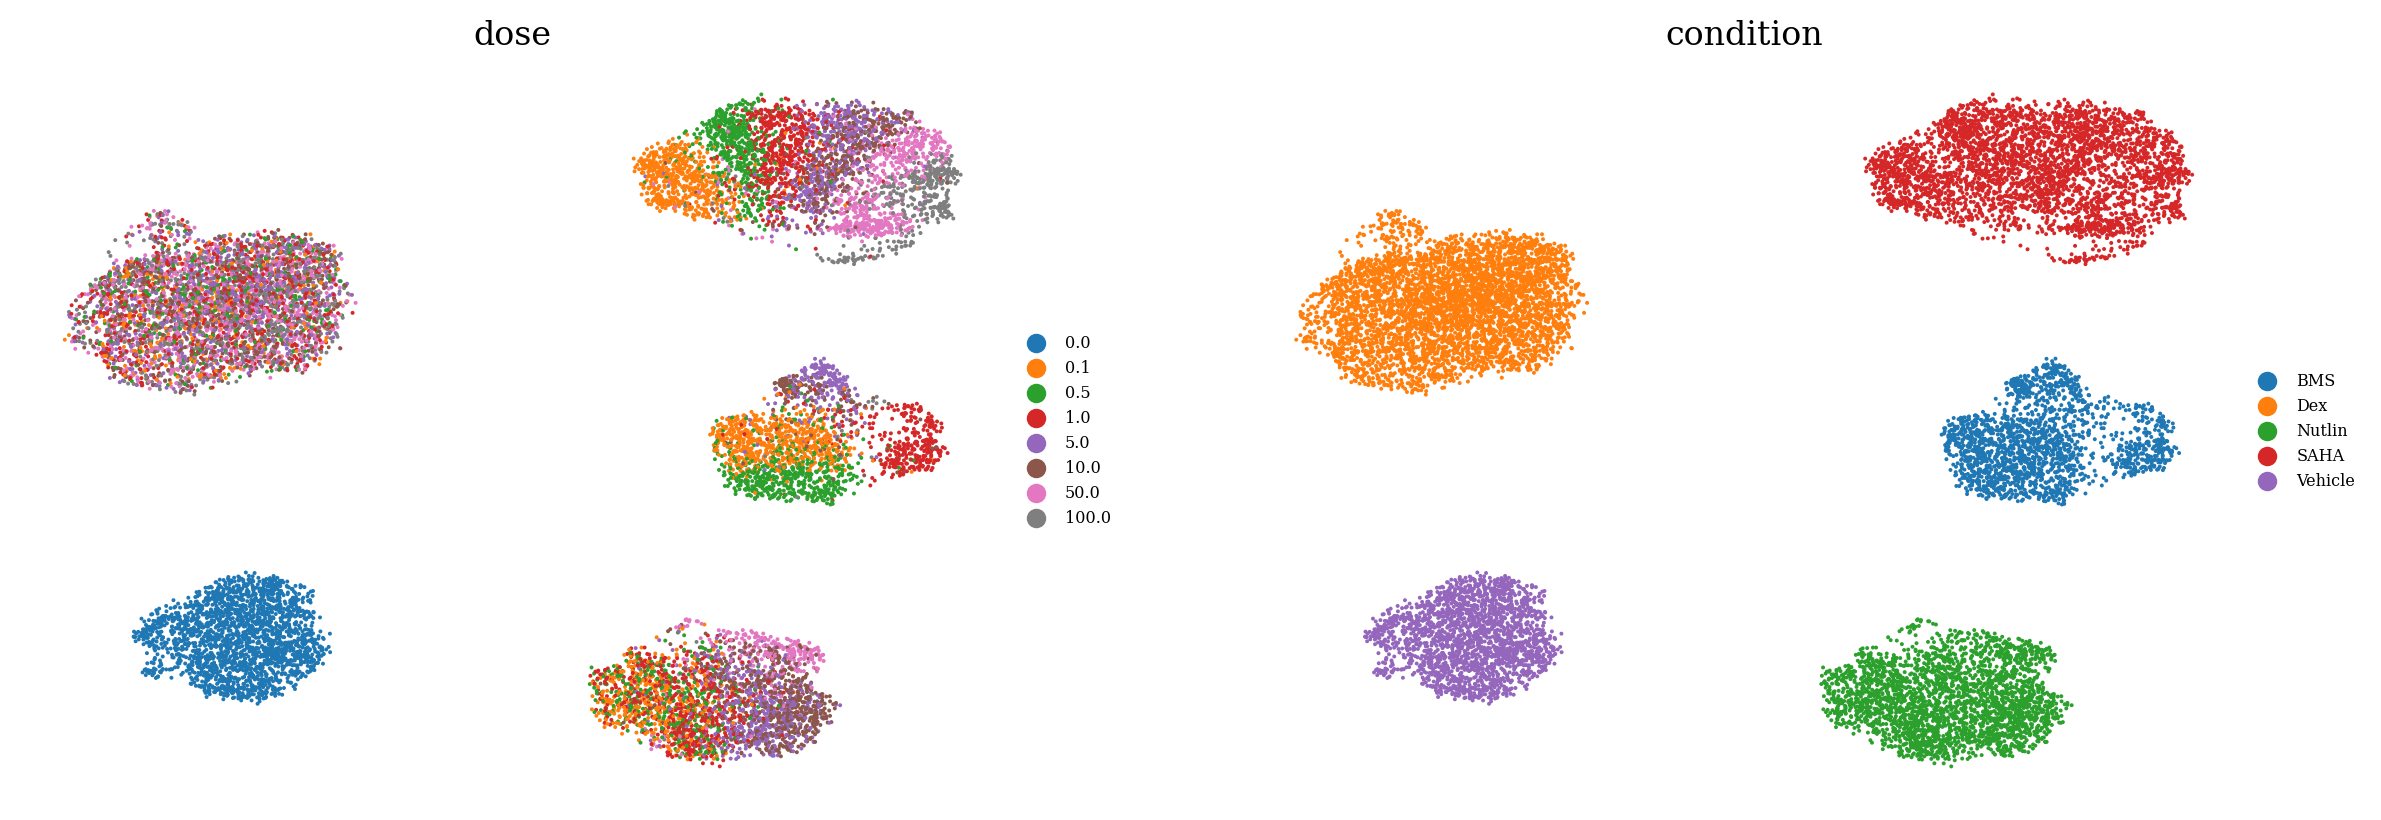

In [23]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition"], 
        ncols=2,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [24]:
from tardis._disentanglementmanager import DisentanglementManager as DM

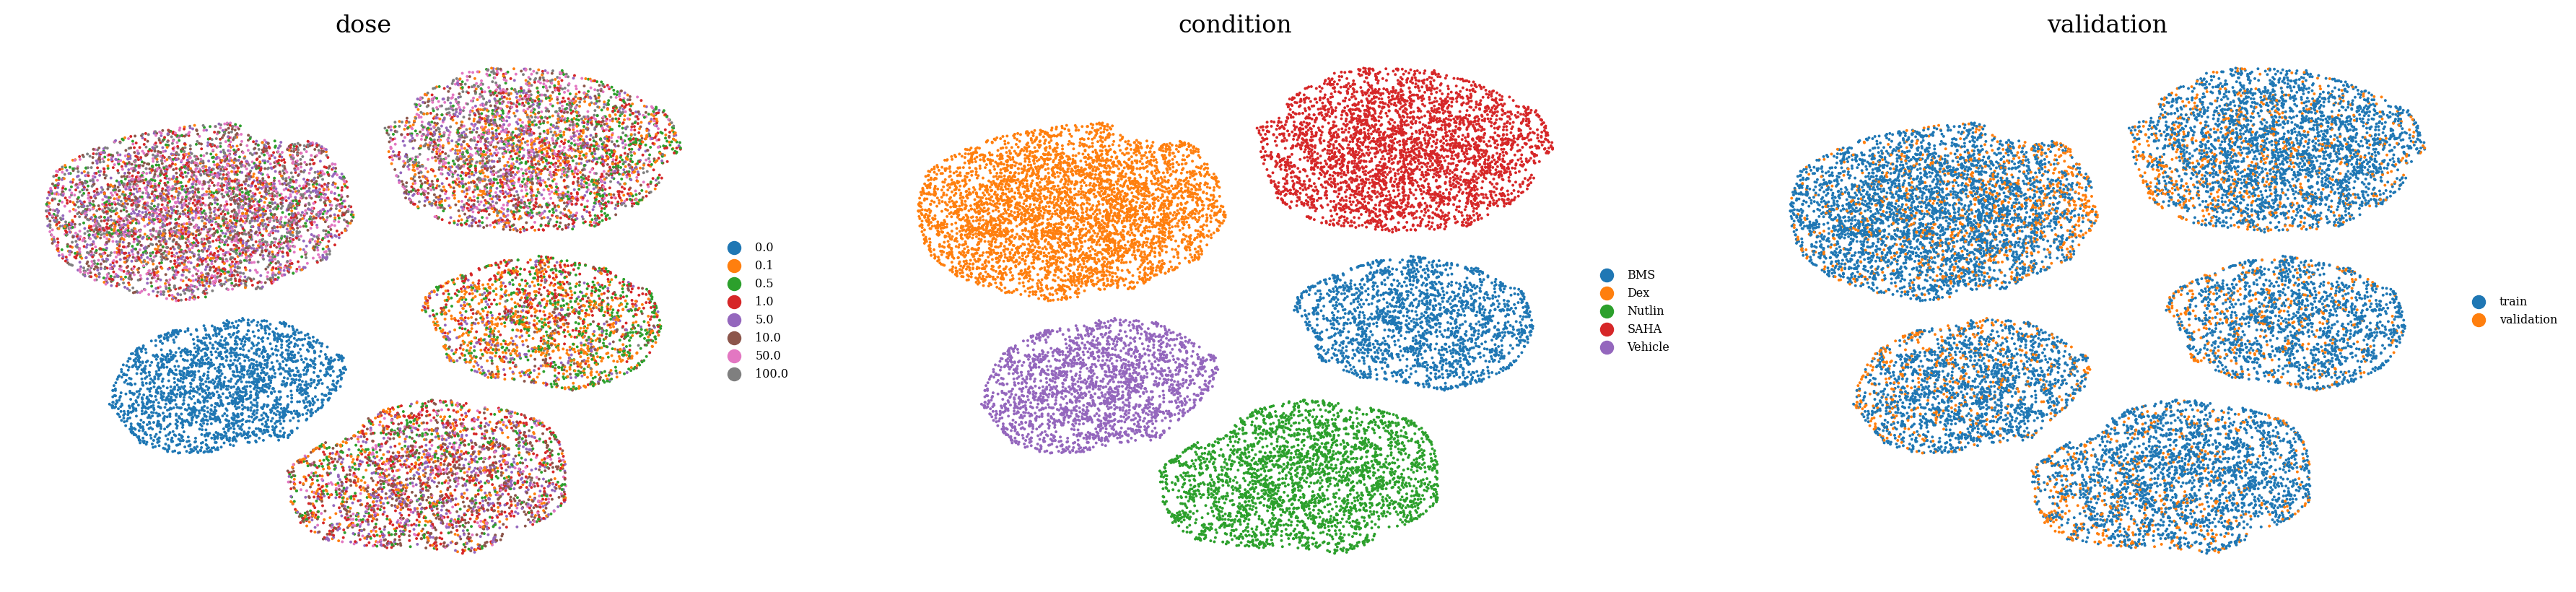

In [25]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DM.configurations.get_by_obs_key(obs_key).reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition", "validation"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )